# Training Transformer

### TA's Slide
[Slide](https://docs.google.com/presentation/d/1ga0d43mWyrfHjdkp7FG3iWcEKTGr8CdkifYhhi4LBY8/edit?usp=sharing)

### Description
In this assignment, we are tasked with utilizing a transformer decoder-only architecture for pretraining, with a focus on next-token prediction, applied to Pokémon images.

Please feel free to mail us if you have any questions.

ntu-ml-2025-spring-ta@googlegroups.com

# Utilities

### Download packages

In [1]:
!pip install datasets==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 3.3.1
    Uninstalling datasets-3.3.1:
      Successfully uninstalled datasets-3.3.1


### Import Packages

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoModelForCausalLM, GPT2Config, set_seed
from datasets import load_dataset
from typing import Dict, Any, Optional

### Check Devices

In [3]:
!nvidia-smi

Wed Mar 26 05:33:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Set Random Seed

In [4]:
set_seed(0)

# Prepare Data

### Data Augmentation

In [5]:
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(10)
])

def pixel_transform(pixel):
    img = torch.reshape(torch.tensor(pixel), (1,20,20))
    return transforms(img).flatten().tolist()

### Define Dataset

In [6]:
from typing import List, Tuple, Union
import torch
from torch.utils.data import Dataset

class PixelSequenceDataset(Dataset):
    def __init__(self, data: List[List[int]], mode: str = "train"):
        """
        A dataset class for handling pixel sequences.

        Args:
            data (List[List[int]]): A list of sequences, where each sequence is a list of integers.
            mode (str): The mode of operation, either "train", "dev", or "test".
                - "train": Returns (input_ids, labels) where input_ids are sequence[:-1] and labels are sequence[1:].
                - "dev": Returns (input_ids, labels) where input_ids are sequence[:-160] and labels are sequence[-160:].
                - "test": Returns only input_ids, as labels are not available.
        """
        self.data = data
        self.mode = mode

    def __len__(self) -> int:
        """Returns the total number of sequences in the dataset."""
        return len(self.data)

    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        """
        Fetches a sequence from the dataset and processes it based on the mode.

        Args:
            idx (int): The index of the sequence.

        Returns:
            - If mode == "train": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "dev": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "test": torch.Tensor -> input_ids
        """
        sequence = self.data[idx]

        if self.mode == "train":
            sequence = pixel_transform(sequence)
            input_ids = torch.tensor(sequence[:-1], dtype=torch.long)
            labels = torch.tensor(sequence[1:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "dev":
            input_ids = torch.tensor(sequence[:-160], dtype=torch.long)
            labels = torch.tensor(sequence[-160:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "test":
            input_ids = torch.tensor(sequence, dtype=torch.long)
            return input_ids

        raise ValueError(f"Invalid mode: {self.mode}. Choose from 'train', 'dev', or 'test'.")

### Download Dataset & Prepare Dataloader

In [7]:
# Load the pokemon dataset from Hugging Face Hub
pokemon_dataset = load_dataset("lca0503/ml2025-hw4-pokemon")

# Load the colormap from Hugging Face Hub
colormap = list(load_dataset("lca0503/ml2025-hw4-colormap")["train"]["color"])

# Define number of classes
num_classes = len(colormap)

# Define batch size
batch_size = 16

# === Prepare Dataset and DataLoader for Training ===
train_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["train"]["pixel_color"], mode="train"
)
train_dataloader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# === Prepare Dataset and DataLoader for Validation ===
dev_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["dev"]["pixel_color"], mode="dev"
)
dev_dataloader: DataLoader = DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=False
)

# === Prepare Dataset and DataLoader for Testing ===
test_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["test"]["pixel_color"], mode="test"
)
test_dataloader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

README.md:   0%|          | 0.00/501 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/175k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/632 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/80 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/80 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/297 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/167 [00:00<?, ? examples/s]

### Visualization

In [8]:
def pixel_to_image(pixel_color: List[int], colormap: List[List[int]]) -> Image.Image:
    """
    Converts a list of pixel indices into a 20x20 RGB image using a colormap.

    Args:
        pixel_color (List[int]): A list of pixel indices representing colors.
        colormap (List[List[int]]): A list where each index maps to an RGB color [R, G, B].

    Returns:
        Image.Image: A PIL Image object representing the reconstructed image.
    """
    # Ensure the pixel_color list has at least 400 elements (pad with 0s if needed)
    while len(pixel_color) < 400:
        pixel_color.append(0)

    # Map pixel indices to actual RGB colors using the colormap
    pixel_data = [colormap[pixel] for pixel in pixel_color]

    # Convert to numpy array and reshape to 20x20x3 (RGB image)
    image_array = np.array(pixel_data, dtype=np.uint8).reshape(20, 20, 3)

    # Create a PIL Image from the array
    image = Image.fromarray(image_array)

    return image

def show_images(images: List[Image.Image]) -> None:
    """
    Displays a grid of up to 96 images using Matplotlib.

    Args:
        images (List[Image.Image]): A list of PIL Image objects to display.

    Returns:
        None
    """
    num_images = min(96, len(images))  # Limit to 96 images

    # Set up the figure size and grid layout (6 rows, 16 columns)
    fig, axes = plt.subplots(6, 16, figsize=(16, 6))
    axes = axes.flatten()  # Flatten to make iteration easier

    # Loop through images and display each one in the grid
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')  # Hide axis
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

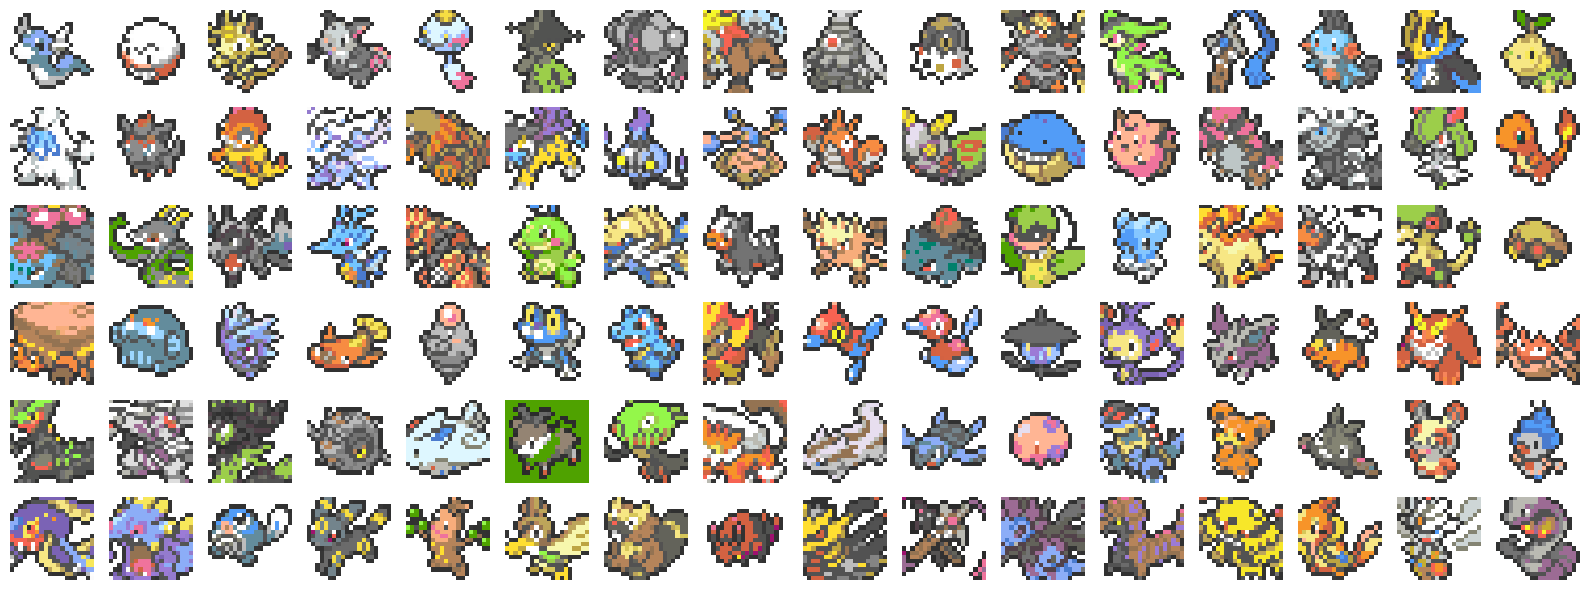

In [9]:
# Visualize train images
train_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["train"]]
show_images(train_images)

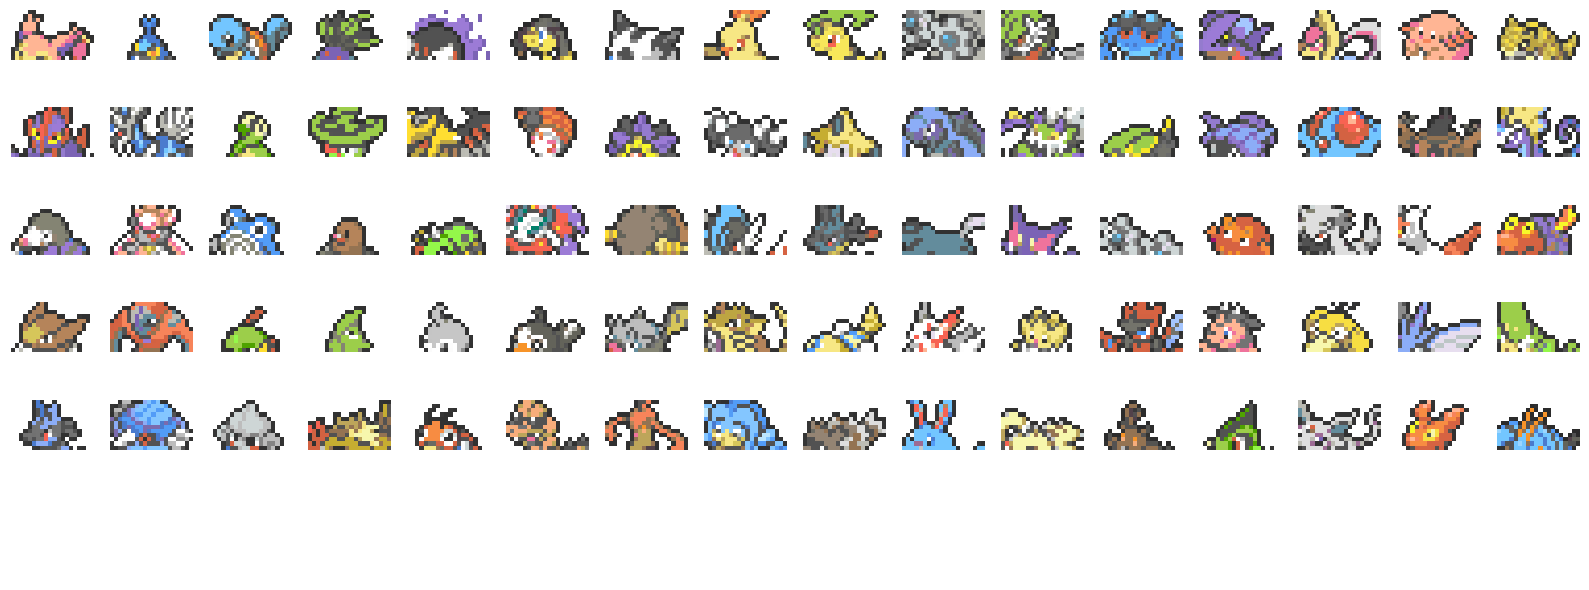

In [10]:
# Visualize test images
test_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["test"]]
show_images(test_images)

# Data Augmentation Show

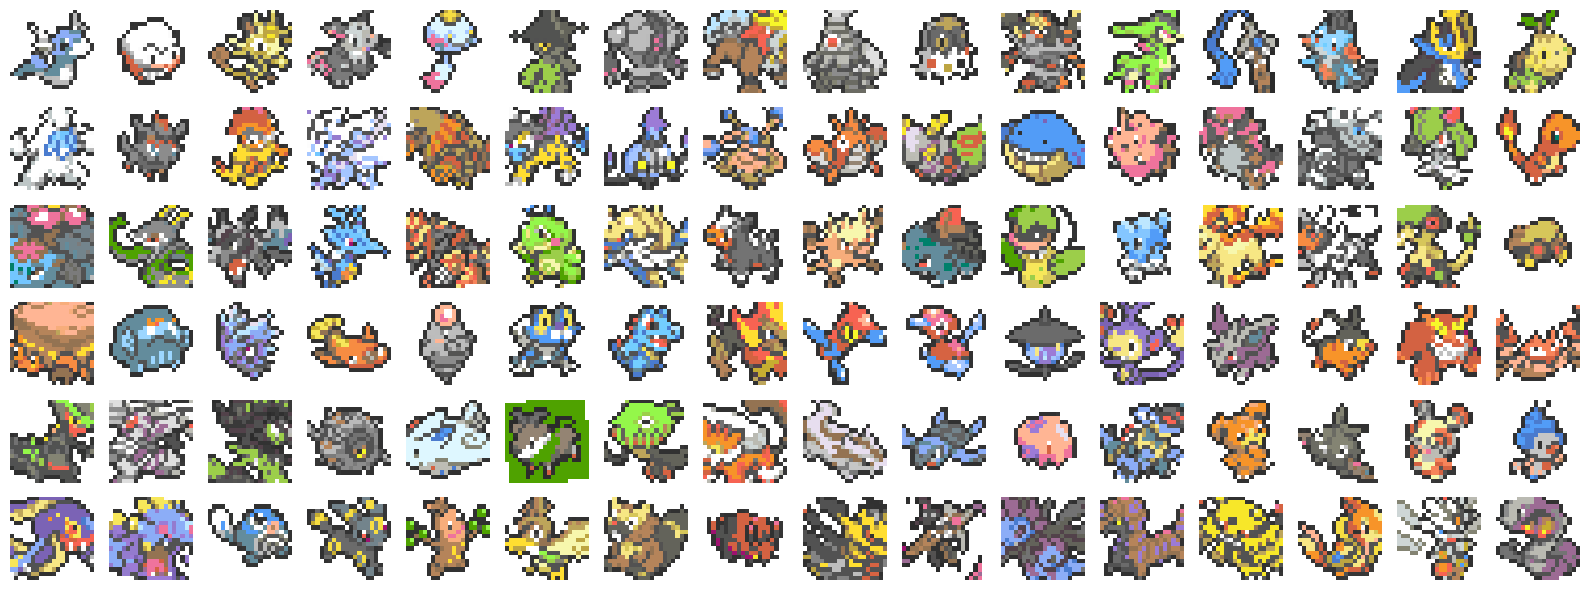

In [11]:
train_images = [pixel_to_image(pixel_transform(data["pixel_color"]), colormap) for data in pokemon_dataset["train"]]
show_images(train_images)

# Prepare Model

### Model Configuration
Here, we define the model configuration, including the architecture and key hyperparameters such as the number of attention heads, layers, embedding size, and more.
*   Hint 1: Adjust hyperparameters here for improved performance.
*   Hint 2: Experiment with different model architectures, such as Llama, Mistral, or Qwen, to enhance performance.
  * [LlamaConfig](https://huggingface.co/docs/transformers/model_doc/llama#transformers.LlamaConfig)
  * [MistralConfig](https://huggingface.co/docs/transformers/model_doc/mistral#transformers.MistralConfig)
  * [Qwen2Config](https://huggingface.co/docs/transformers/model_doc/qwen2#transformers.Qwen2Config)


In [12]:
# https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2Config

# Define GPT-2 model configuration as a dictionary
gpt2_config = {
    "activation_function": "gelu_new",    # Activation function used in the model
    "architectures": ["GPT2LMHeadModel"],  # Specifies the model type
    "attn_pdrop": 0.1,            # Dropout rate for attention layers
    "embd_pdrop": 0.1,            # Dropout rate for embeddings
    "initializer_range": 0.02,        # Standard deviation for weight initialization
    "layer_norm_epsilon": 1e-05,       # Small constant to improve numerical stability in layer norm
    "model_type": "gpt2",           # Type of model
    "n_ctx": 512,               # Context size (maximum sequence length)
    "n_embd": 768,              # Embedding size
    "n_head": 12,               # Number of attention heads
    "n_layer": 12,              # Number of transformer layers
    "n_positions": 1024,           # Maximum number of token positions
    "resid_pdrop": 0.1,           # Dropout rate for residual connections
    "vocab_size": num_classes,       # Number of unique tokens in vocabulary
    "pad_token_id": None,          # Padding token ID (None means no padding token)
    "eos_token_id": None,          # End-of-sequence token ID (None means not explicitly defined)
}

# Load GPT-2 model configuration from dictionary
gpt2_config = GPT2Config.from_dict(gpt2_config)

In [13]:
# https://huggingface.co/docs/transformers/model_doc/llama#transformers.LlamaConfig
from transformers import LlamaConfig

llama_config = {
    "hidden_size": 1024,  # 減少隱藏層大小
    "intermediate_size": 1024,  # 減少 MLP 層大小
    "num_hidden_layers": 24,  # 減少 Transformer 層數
    "num_attention_heads": 16,  # 減少注意力頭數
    "max_position_embeddings": 8192,  # 減少最大位置嵌入
    "vocab_size": num_classes,       # Number of unique tokens in vocabulary
    "pad_token_id": None,          # Padding token ID (None means no padding token)
    "eos_token_id": None,          # End-of-sequence token ID (None means not explicitly defined)
}

llama_config = LlamaConfig.from_dict(llama_config)

In [14]:
# https://huggingface.co/docs/transformers/model_doc/mistral#transformers.MistralConfig
from transformers import MistralConfig

mistral_config = {
    "hidden_size": 512,  # 降低隱藏層大小
    "intermediate_size": 1024,  # 減少 MLP 層的計算量
    "num_hidden_layers": 24,  # 減少 Transformer 層數
    "num_attention_heads": 16,  # 減少注意力頭數
    "num_key_value_heads": 8,  # 減少 key-value heads
    "max_position_embeddings": 8192,  # 減少最大序列長度
    "sliding_window": 2048,  # 調整窗口大小，減少記憶體佔用
    "vocab_size": num_classes,       # Number of unique tokens in vocabulary
    "pad_token_id": None,          # Padding token ID (None means no padding token)
    "eos_token_id": None,          # End-of-sequence token ID (None means not explicitly defined)
}

mistral_config = MistralConfig.from_dict(mistral_config)

In [15]:
# https://huggingface.co/docs/transformers/model_doc/qwen2#transformers.Qwen2Config
from transformers import Qwen2Config

qwen2_config = {
    "hidden_size": 512,  # 降低隱藏層大小
    "intermediate_size": 1024,  # 減少 MLP 層計算量
    "num_hidden_layers": 24,  # 減少 Transformer 層數
    "num_attention_heads": 16,  # 減少注意力頭數
    "num_key_value_heads": 8,  # 減少 key-value heads
    "max_position_embeddings": 8192,  # 減少最大序列長度
    "use_sliding_window": True,  # 開啟 sliding window
    "sliding_window": 2048,  # 調整窗口大小
    "max_window_layers": 12,  # 減少 sliding window 層數
    "vocab_size": num_classes,       # Number of unique tokens in vocabulary
    "pad_token_id": None,          # Padding token ID (None means no padding token)
    "eos_token_id": None,          # End-of-sequence token ID (None means not explicitly defined)
}

qwen2_config = Qwen2Config.from_dict(qwen2_config)

### Load Model

In [16]:
# Load the model using the configuration defined above
model = AutoModelForCausalLM.from_config(llama_config)
config = llama_config

# model = AutoModelForCausalLM.from_config(mistral_config)
# config = mistral_config

# model = AutoModelForCausalLM.from_config(qwen2_config, attn_implementation='sdpa')
# config = qwen2_config

print(model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {trainable_params:,}")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(167, 1024)
    (layers): ModuleList(
      (0-23): 24 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (up_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (down_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((1024,), eps=1e-06)
      )
    )
    (norm): 

# Train and Inference

### Training Arguments
Here, we define the number of epochs for training, the learning rate, the optimizer, and the loss function.
*   Hint 3: Adjust the number of epochs and learning rate here to improve performance.

In [17]:
# Training Parameters
epochs = 100                                      # Number of training epochs
learning_rate = 1e-4                                 # Learning rate for optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     # Check if CUDA is available for GPU
save_dir = "checkpoints"                               # Directory to save model checkpoints

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()                          # Loss function for classification tasks
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1) # AdamW optimizer with weight decay

### Save Model Function

In [18]:
def save_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, epoch: int, loss: float, save_dir: str, filename: str = "best_model.pth") -> None:
    """
    Saves the model state, optimizer state, current epoch, and loss to a specified directory.

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer whose state will be saved.
        epoch (int): The current epoch number (used for checkpointing).
        loss (float): The current loss value to track model performance.
        save_dir (str): The directory where the model checkpoint will be saved.
        filename (str, optional): The name of the file to save the model. Defaults to "best_model.pth".

    Returns:
        None
    """
    # Construct the full path for saving the model checkpoint
    save_path = os.path.join(save_dir, filename)

    # Save the model, optimizer state, and additional metadata (epoch and loss)
    torch.save({
        'epoch': epoch + 1,                # Save epoch + 1 for easier tracking
        'model_state_dict': model.state_dict(),       # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state (important for resuming training)
        'loss': loss                     # Save the current loss value
    }, save_path)

    # Print a confirmation message indicating the model has been saved
    print(f"Model saved at {save_path} (Loss: {loss:.4f}, Epoch: {epoch + 1})")

### Train

We save the checkpoint with the lowest training loss since validation set reconstruction accuracy doesn't directly reflect the model's image generation quality.
*   Hint 4: Train a classifier to check if an image looks like a Pokémon or not. (Optional)

Training Epoch 1/100: 100%|██████████| 40/40 [01:29<00:00,  2.25s/it]


Epoch 1/100, Loss: 3.6324


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.72s/it]


Epoch 1/100, Reconstruction Accuracy: 0.4056
Model saved at checkpoints/best_model.pth (Loss: 3.6324, Epoch: 1)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


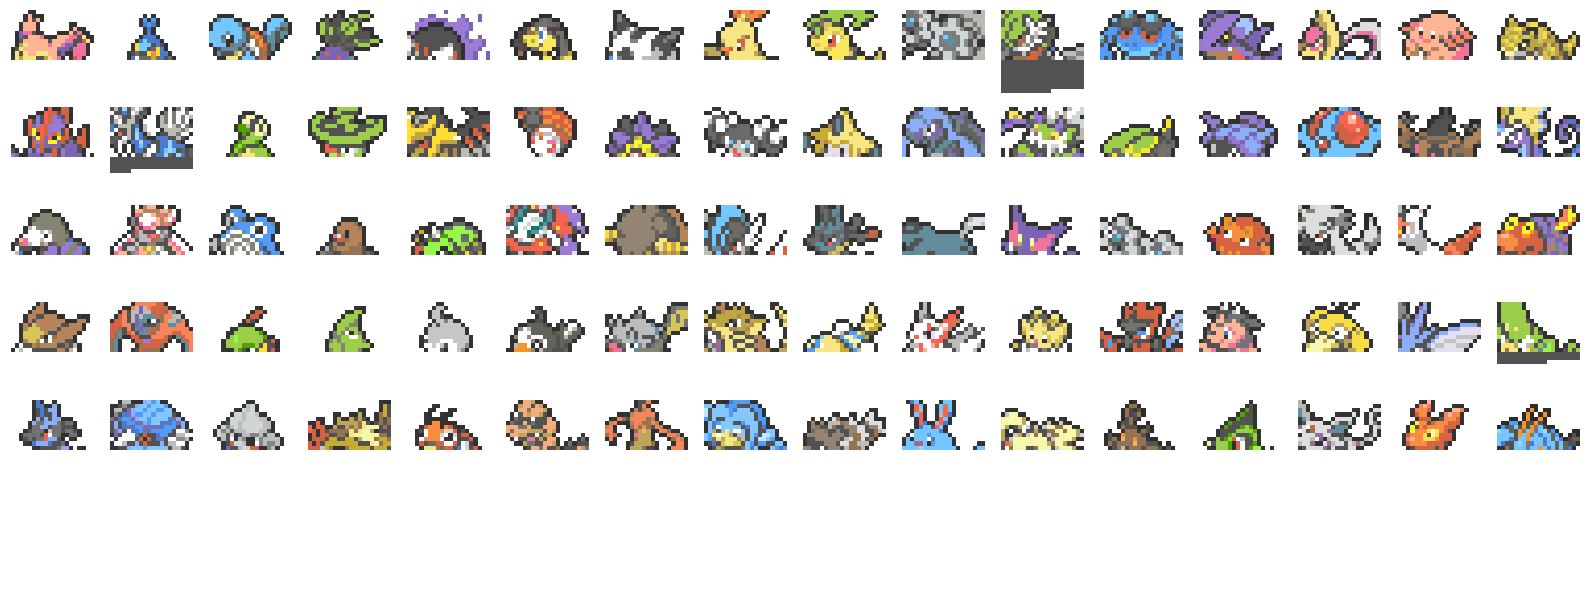

Training Epoch 2/100: 100%|██████████| 40/40 [01:44<00:00,  2.60s/it]


Epoch 2/100, Loss: 3.0483


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.89s/it]


Epoch 2/100, Reconstruction Accuracy: 0.3893
Model saved at checkpoints/best_model.pth (Loss: 3.0483, Epoch: 2)


Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.93s/it]


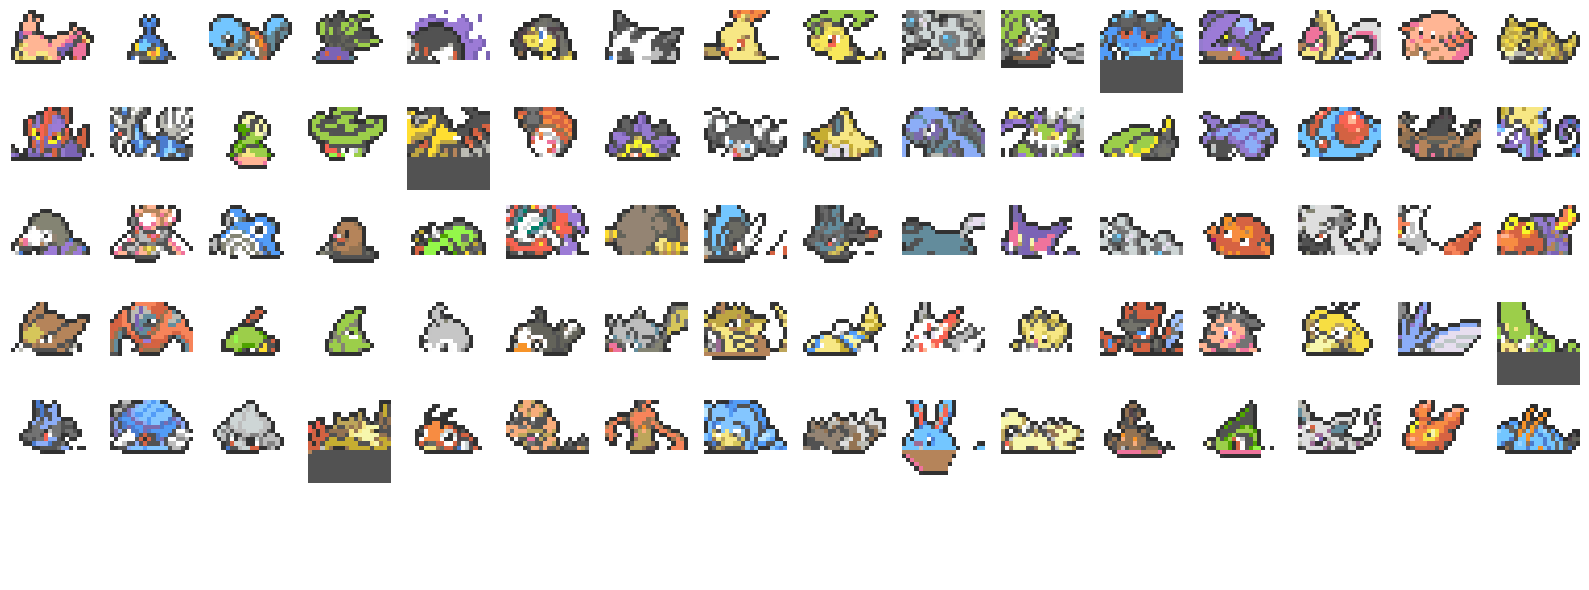

Training Epoch 3/100: 100%|██████████| 40/40 [01:44<00:00,  2.61s/it]


Epoch 3/100, Loss: 2.6679


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.89s/it]


Epoch 3/100, Reconstruction Accuracy: 0.3739
Model saved at checkpoints/best_model.pth (Loss: 2.6679, Epoch: 3)


Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.92s/it]


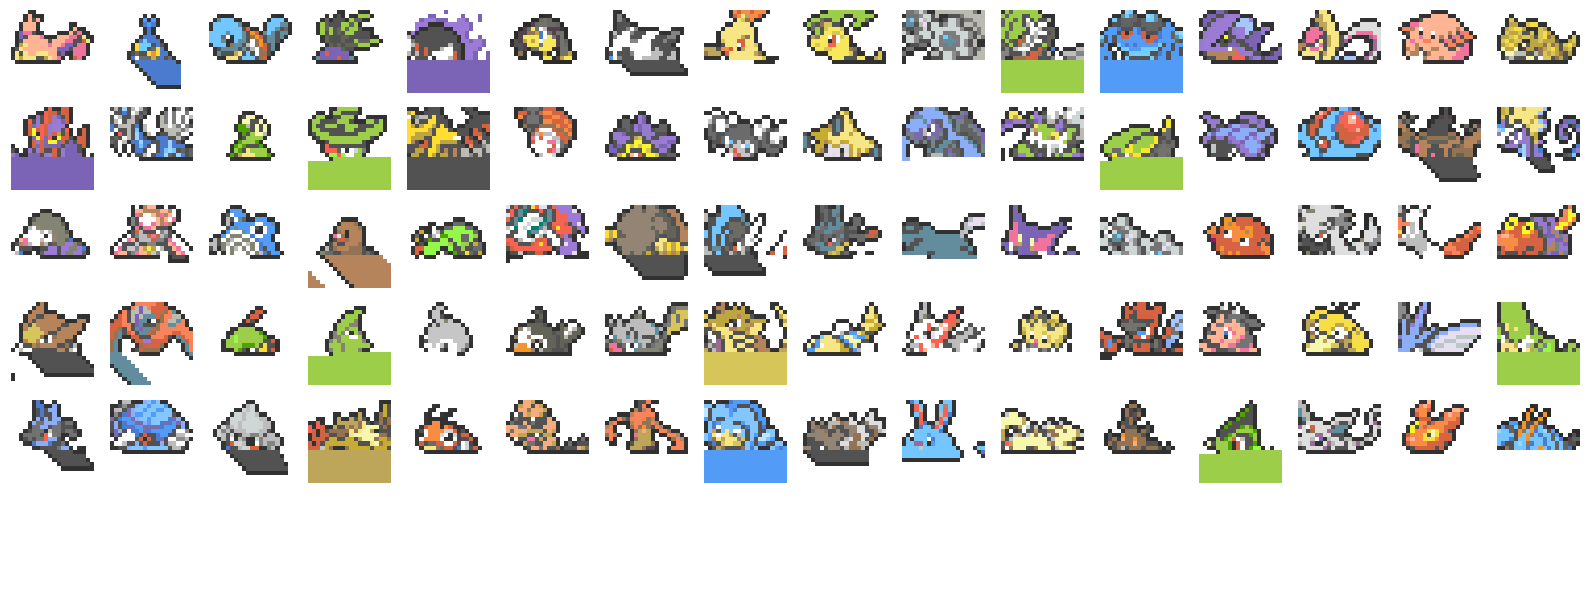

Training Epoch 4/100: 100%|██████████| 40/40 [01:44<00:00,  2.61s/it]


Epoch 4/100, Loss: 2.1532


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.89s/it]


Epoch 4/100, Reconstruction Accuracy: 0.3572
Model saved at checkpoints/best_model.pth (Loss: 2.1532, Epoch: 4)


Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.92s/it]


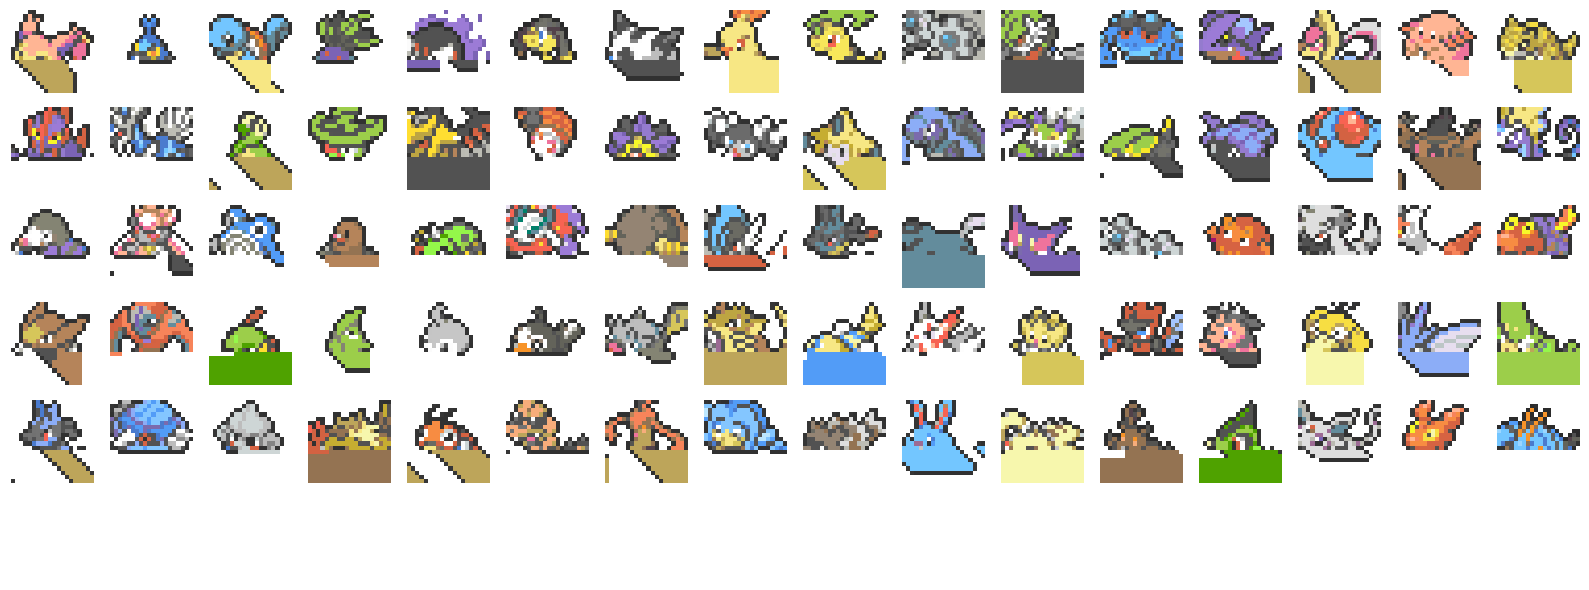

Training Epoch 5/100: 100%|██████████| 40/40 [01:44<00:00,  2.62s/it]


Epoch 5/100, Loss: 1.8696


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.91s/it]


Epoch 5/100, Reconstruction Accuracy: 0.3090
Model saved at checkpoints/best_model.pth (Loss: 1.8696, Epoch: 5)


Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.92s/it]


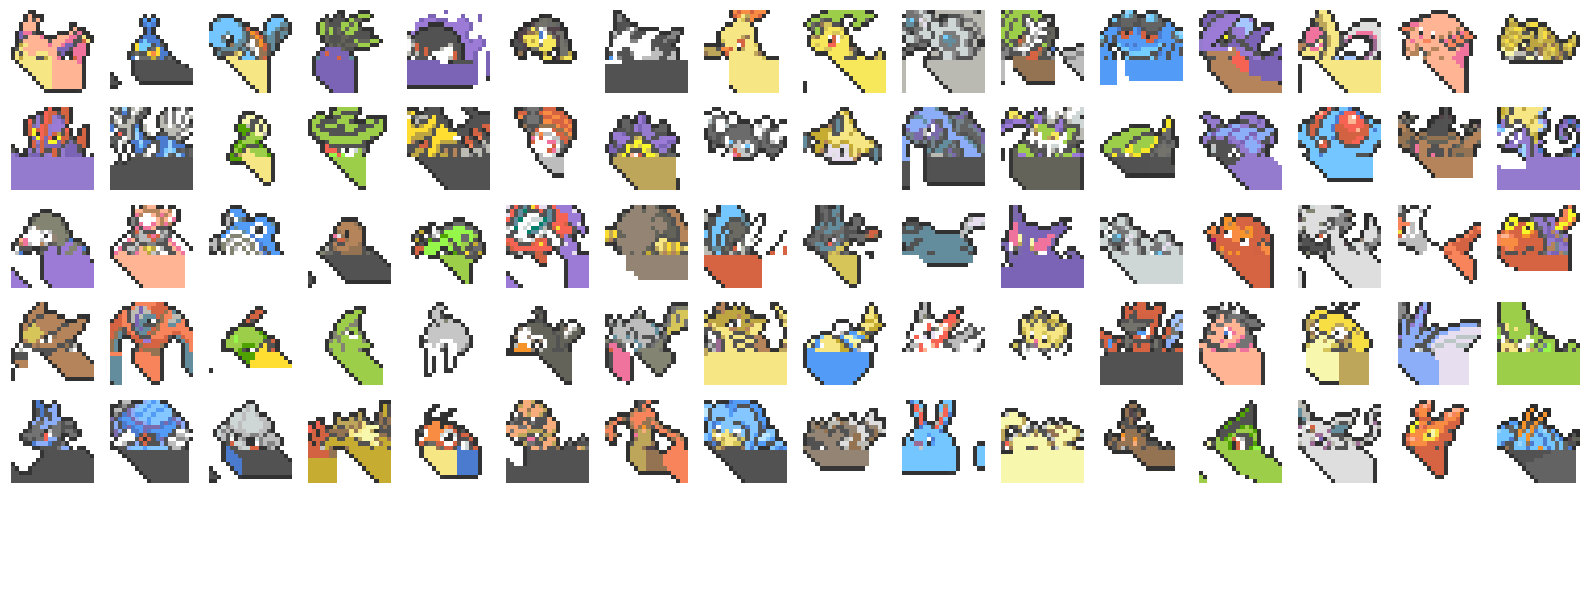

Training Epoch 6/100: 100%|██████████| 40/40 [01:44<00:00,  2.62s/it]


Epoch 6/100, Loss: 1.7323


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.89s/it]


Epoch 6/100, Reconstruction Accuracy: 0.3334
Model saved at checkpoints/best_model.pth (Loss: 1.7323, Epoch: 6)


Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.92s/it]


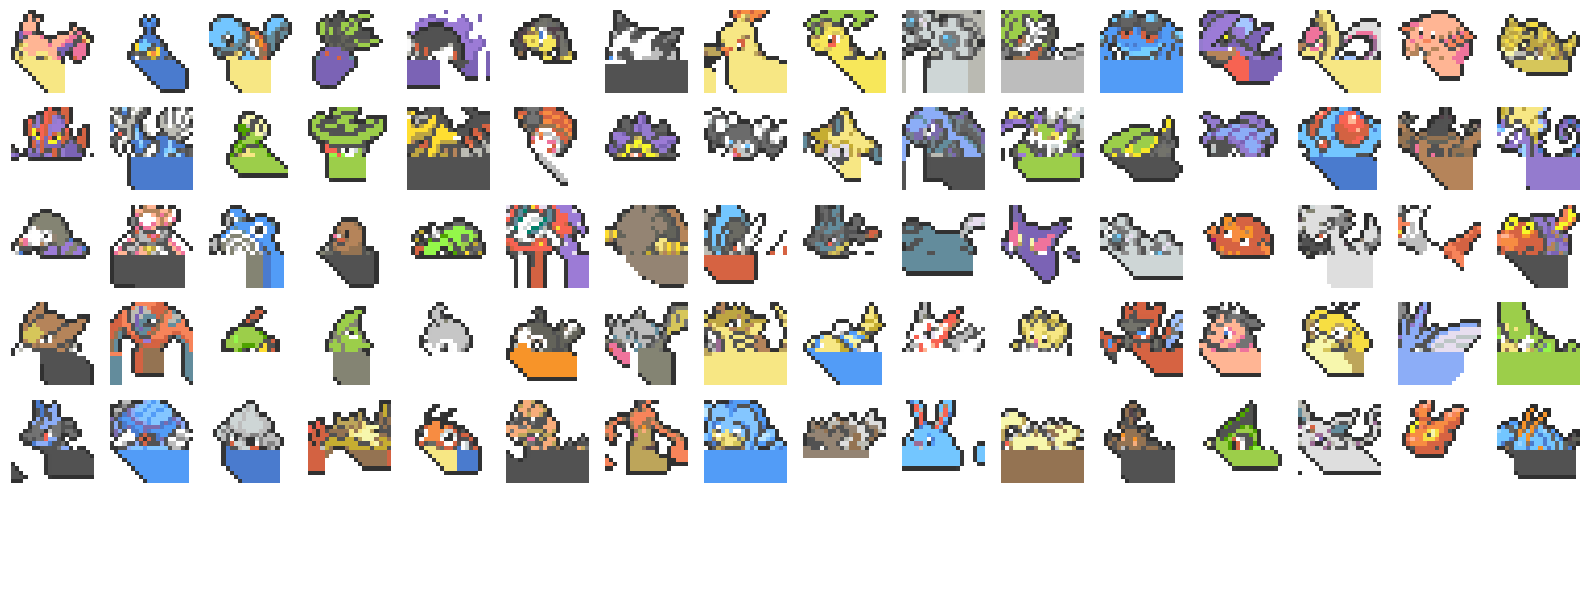

Training Epoch 7/100: 100%|██████████| 40/40 [01:44<00:00,  2.62s/it]


Epoch 7/100, Loss: 1.6623


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.88s/it]


Epoch 7/100, Reconstruction Accuracy: 0.3485
Model saved at checkpoints/best_model.pth (Loss: 1.6623, Epoch: 7)


Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.90s/it]


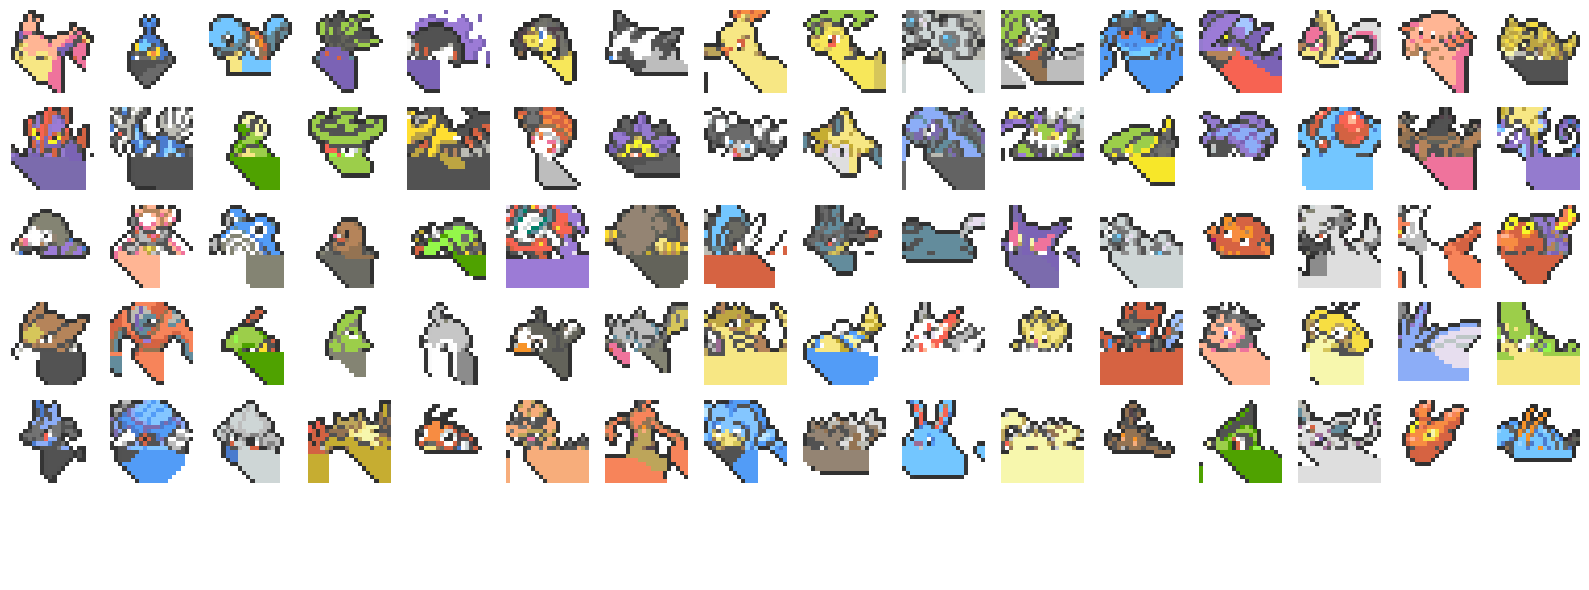

Training Epoch 8/100: 100%|██████████| 40/40 [01:44<00:00,  2.62s/it]


Epoch 8/100, Loss: 1.5847


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.88s/it]


Epoch 8/100, Reconstruction Accuracy: 0.3403
Model saved at checkpoints/best_model.pth (Loss: 1.5847, Epoch: 8)


Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.90s/it]


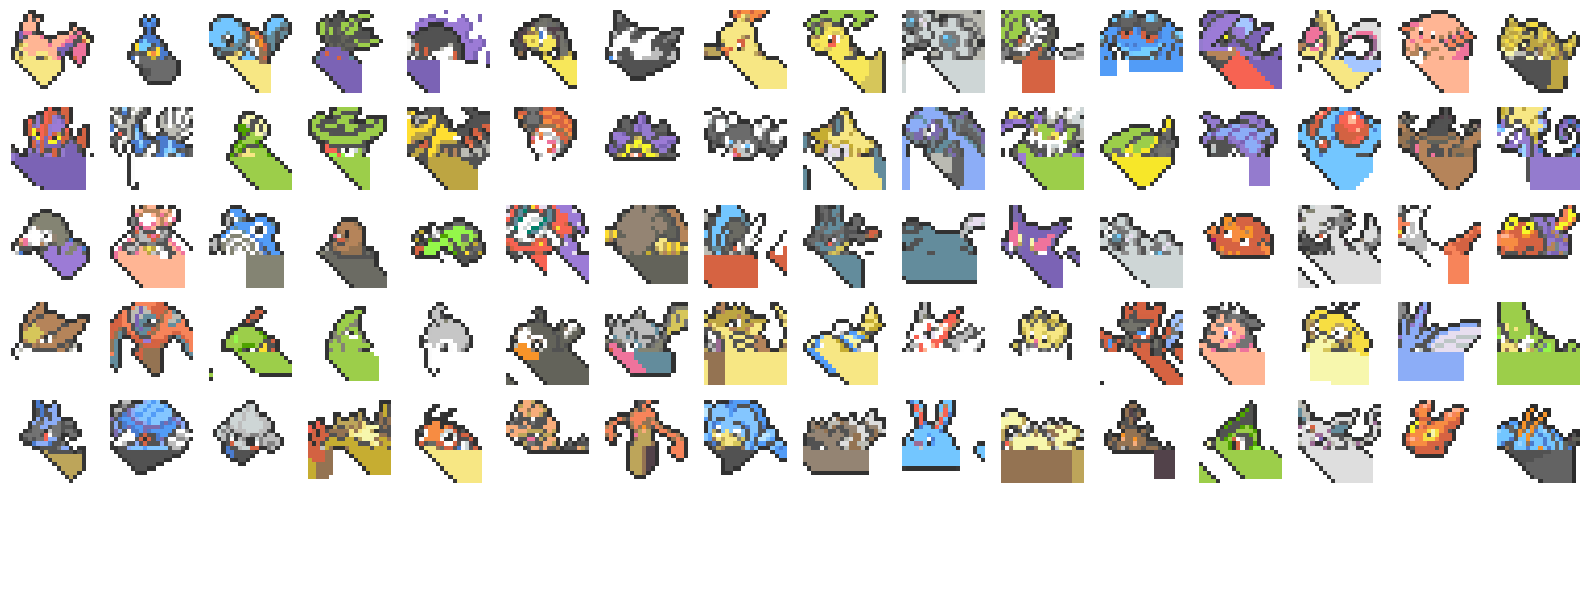

Training Epoch 9/100: 100%|██████████| 40/40 [01:44<00:00,  2.62s/it]


Epoch 9/100, Loss: 1.5200


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.88s/it]


Epoch 9/100, Reconstruction Accuracy: 0.3430
Model saved at checkpoints/best_model.pth (Loss: 1.5200, Epoch: 9)


Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.93s/it]


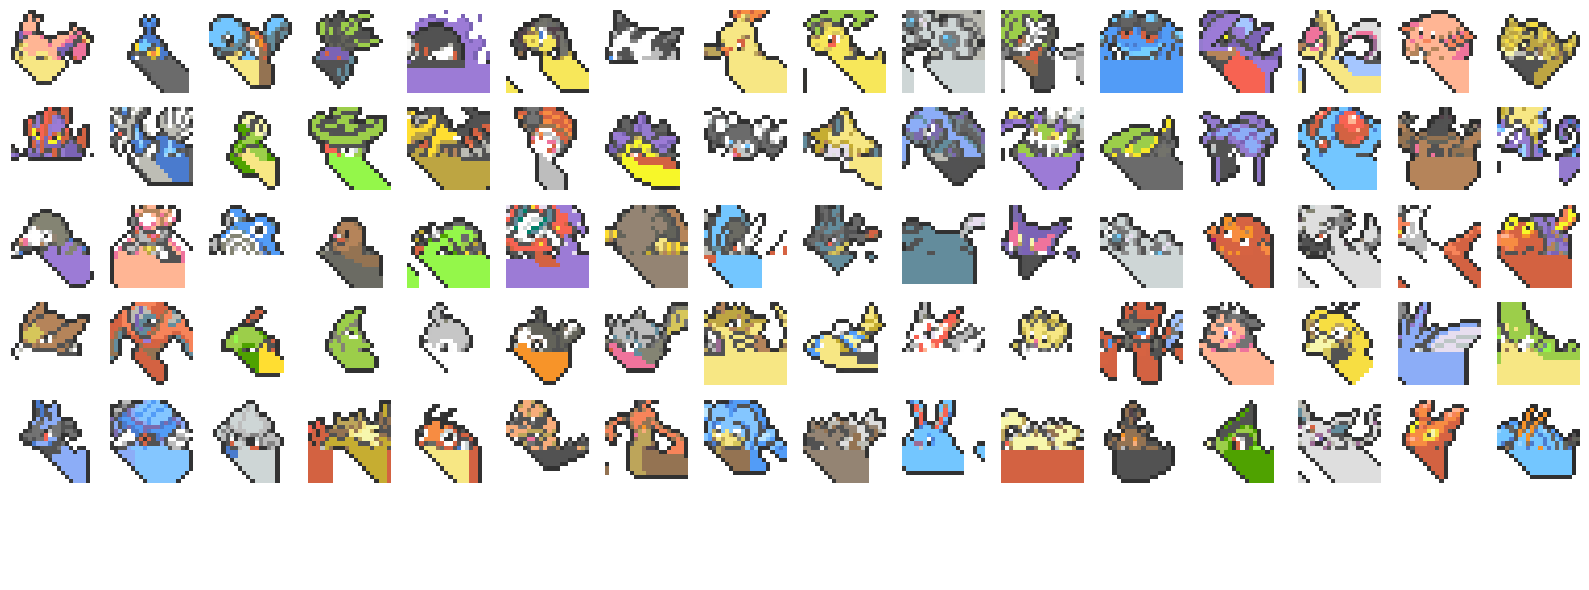

Training Epoch 10/100: 100%|██████████| 40/40 [01:44<00:00,  2.62s/it]


Epoch 10/100, Loss: 1.4806


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.89s/it]


Epoch 10/100, Reconstruction Accuracy: 0.3377
Model saved at checkpoints/best_model.pth (Loss: 1.4806, Epoch: 10)


Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.93s/it]


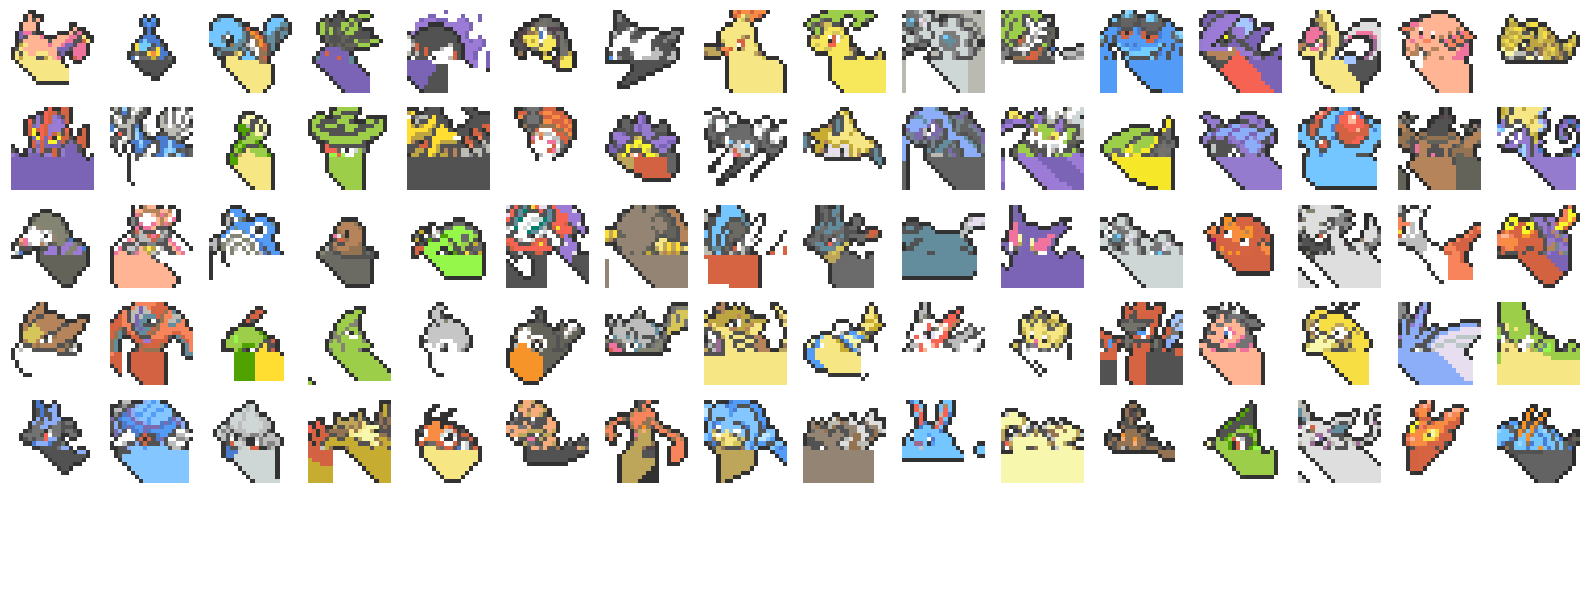

Training Epoch 11/100: 100%|██████████| 40/40 [01:44<00:00,  2.62s/it]


Epoch 11/100, Loss: 1.4378


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.89s/it]


Epoch 11/100, Reconstruction Accuracy: 0.3515
Model saved at checkpoints/best_model.pth (Loss: 1.4378, Epoch: 11)


Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.90s/it]


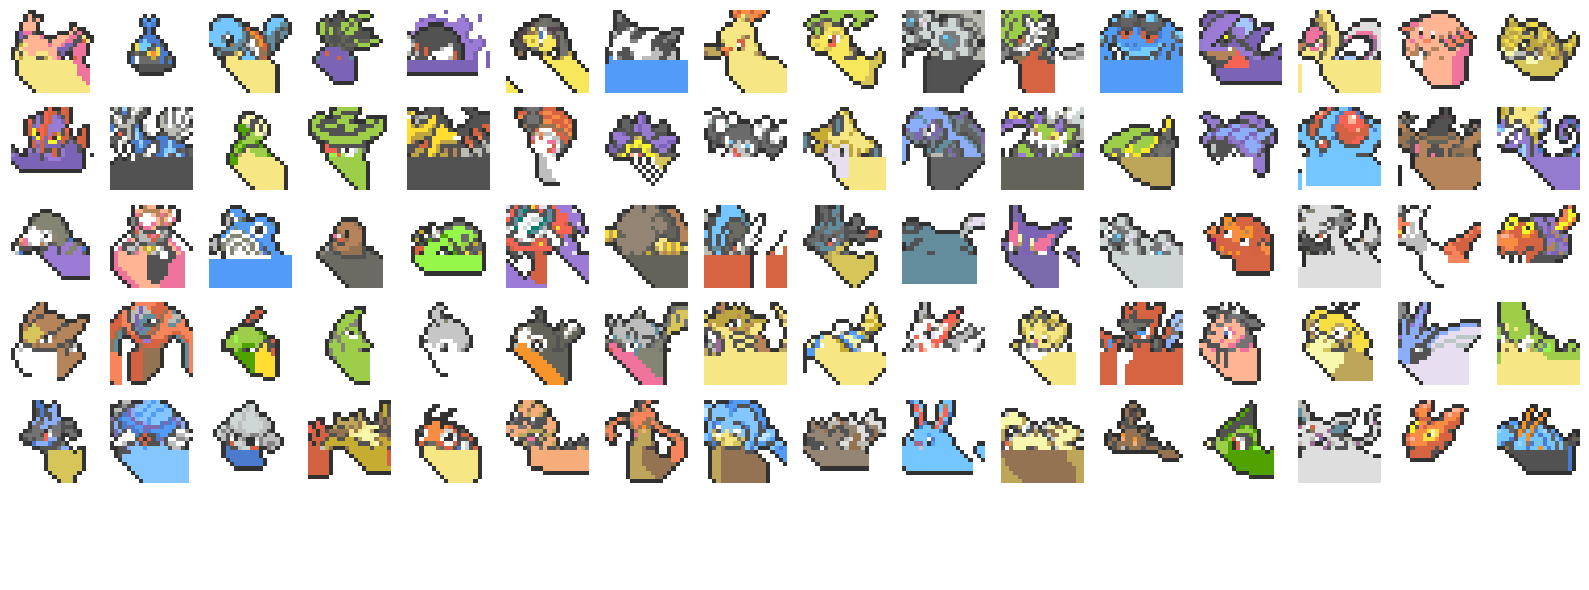

Training Epoch 12/100: 100%|██████████| 40/40 [01:44<00:00,  2.62s/it]


Epoch 12/100, Loss: 1.4048


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.89s/it]


Epoch 12/100, Reconstruction Accuracy: 0.3122
Model saved at checkpoints/best_model.pth (Loss: 1.4048, Epoch: 12)


Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.88s/it]


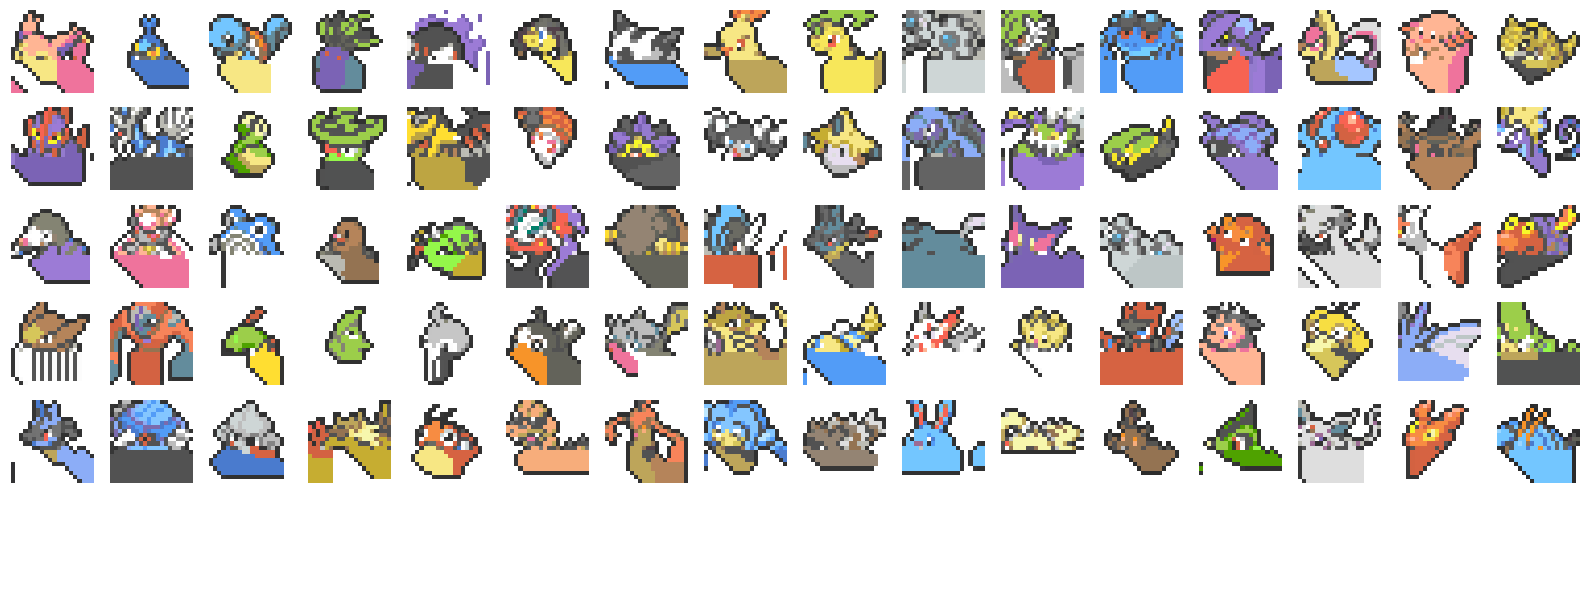

Training Epoch 13/100: 100%|██████████| 40/40 [01:42<00:00,  2.56s/it]


Epoch 13/100, Loss: 1.3725


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.83s/it]


Epoch 13/100, Reconstruction Accuracy: 0.3274
Model saved at checkpoints/best_model.pth (Loss: 1.3725, Epoch: 13)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


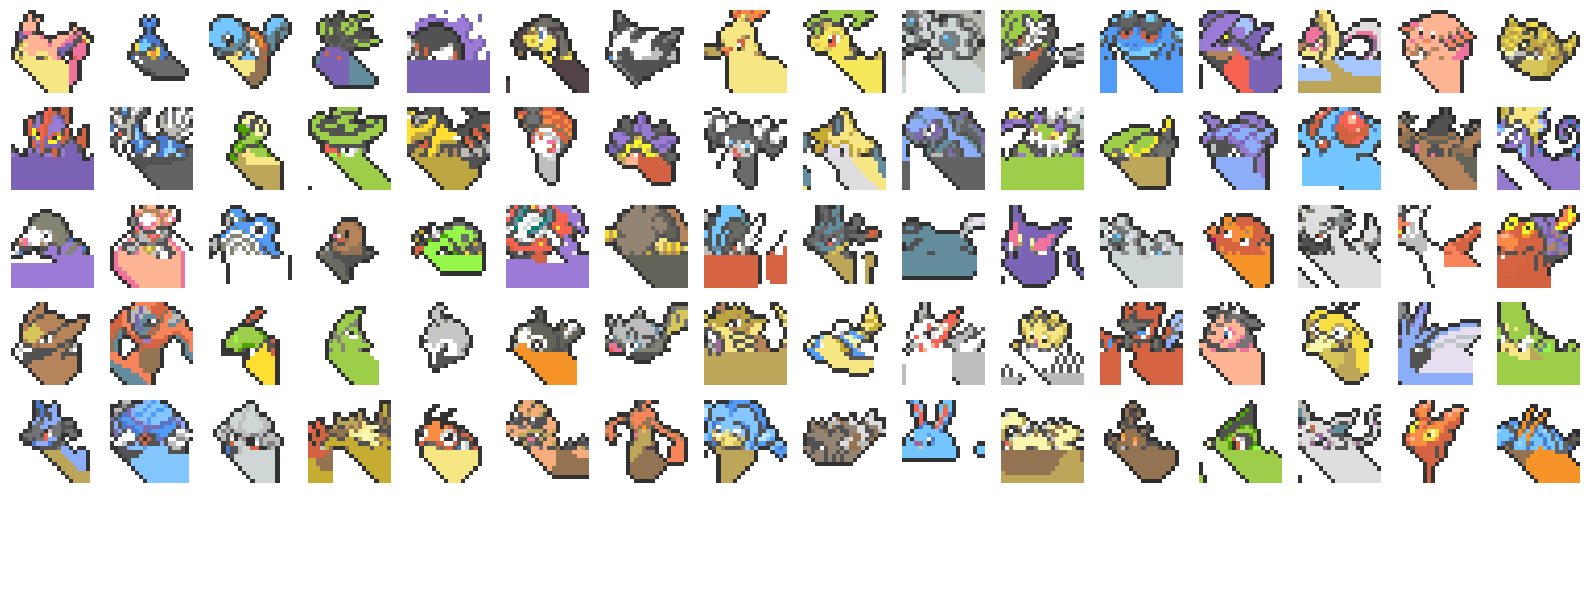

Training Epoch 14/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 14/100, Loss: 1.3401


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 14/100, Reconstruction Accuracy: 0.3459
Model saved at checkpoints/best_model.pth (Loss: 1.3401, Epoch: 14)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


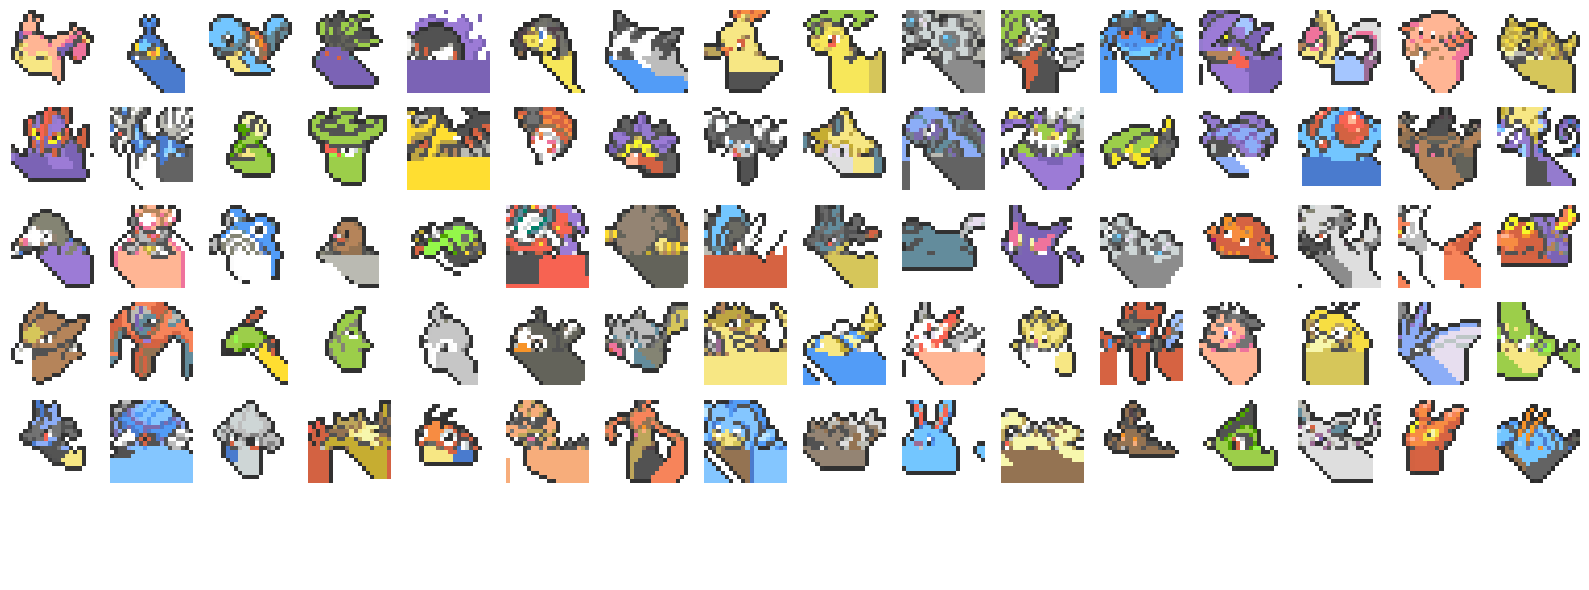

Training Epoch 15/100: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


Epoch 15/100, Loss: 1.3023


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 15/100, Reconstruction Accuracy: 0.3827
Model saved at checkpoints/best_model.pth (Loss: 1.3023, Epoch: 15)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


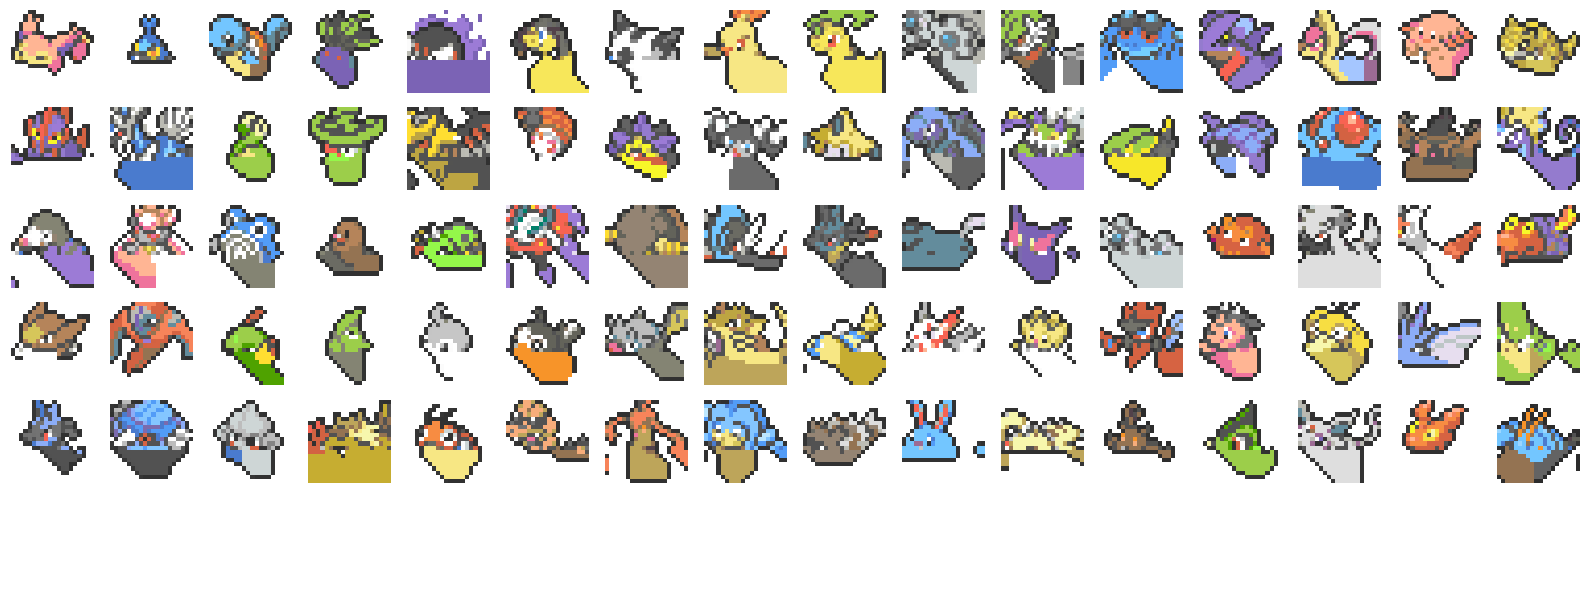

Training Epoch 16/100: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


Epoch 16/100, Loss: 1.2758


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 16/100, Reconstruction Accuracy: 0.3532
Model saved at checkpoints/best_model.pth (Loss: 1.2758, Epoch: 16)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


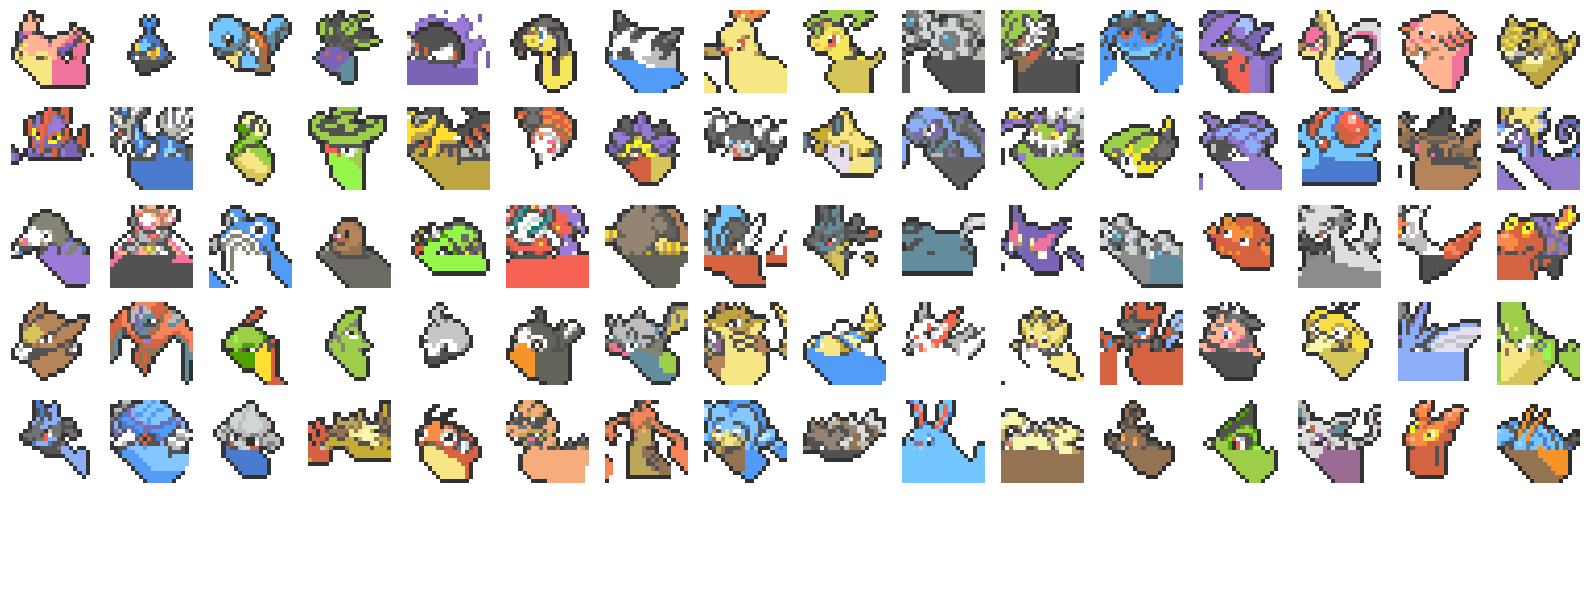

Training Epoch 17/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 17/100, Loss: 1.2412


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Epoch 17/100, Reconstruction Accuracy: 0.3480
Model saved at checkpoints/best_model.pth (Loss: 1.2412, Epoch: 17)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


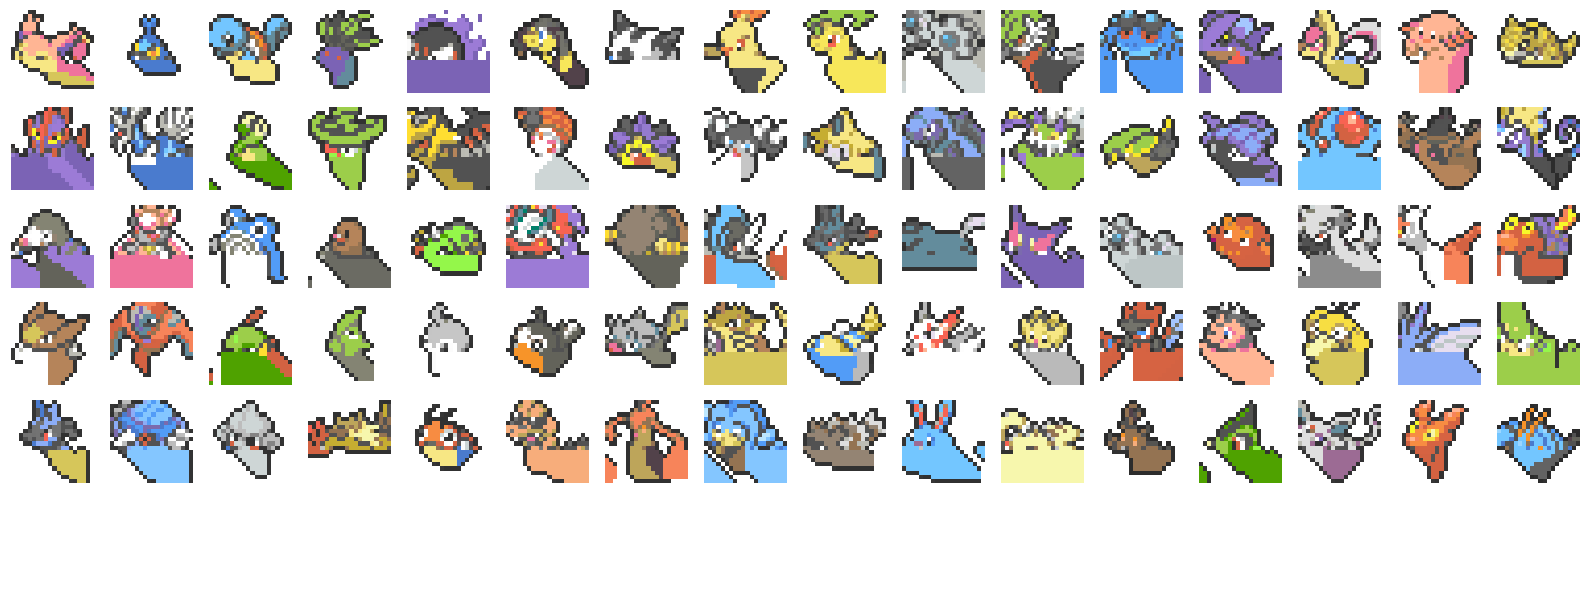

Training Epoch 18/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 18/100, Loss: 1.2024


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 18/100, Reconstruction Accuracy: 0.3465
Model saved at checkpoints/best_model.pth (Loss: 1.2024, Epoch: 18)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


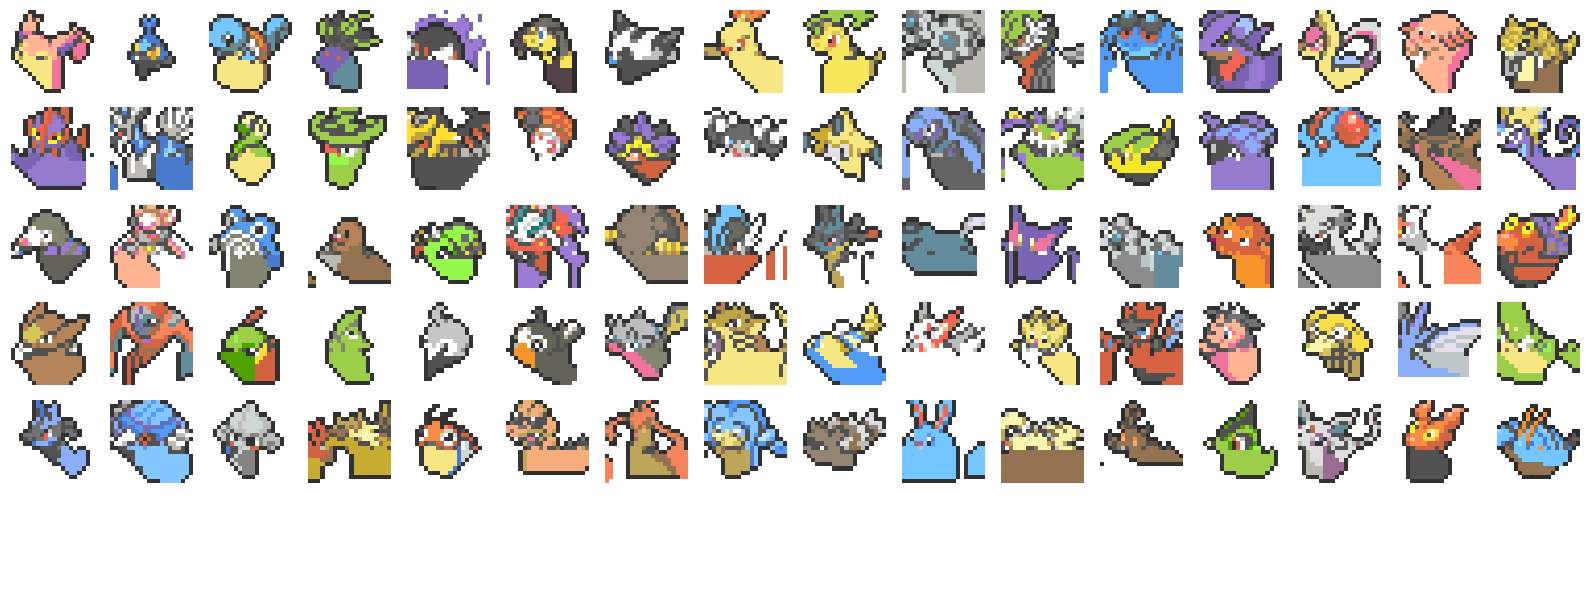

Training Epoch 19/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 19/100, Loss: 1.1727


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 19/100, Reconstruction Accuracy: 0.3632
Model saved at checkpoints/best_model.pth (Loss: 1.1727, Epoch: 19)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


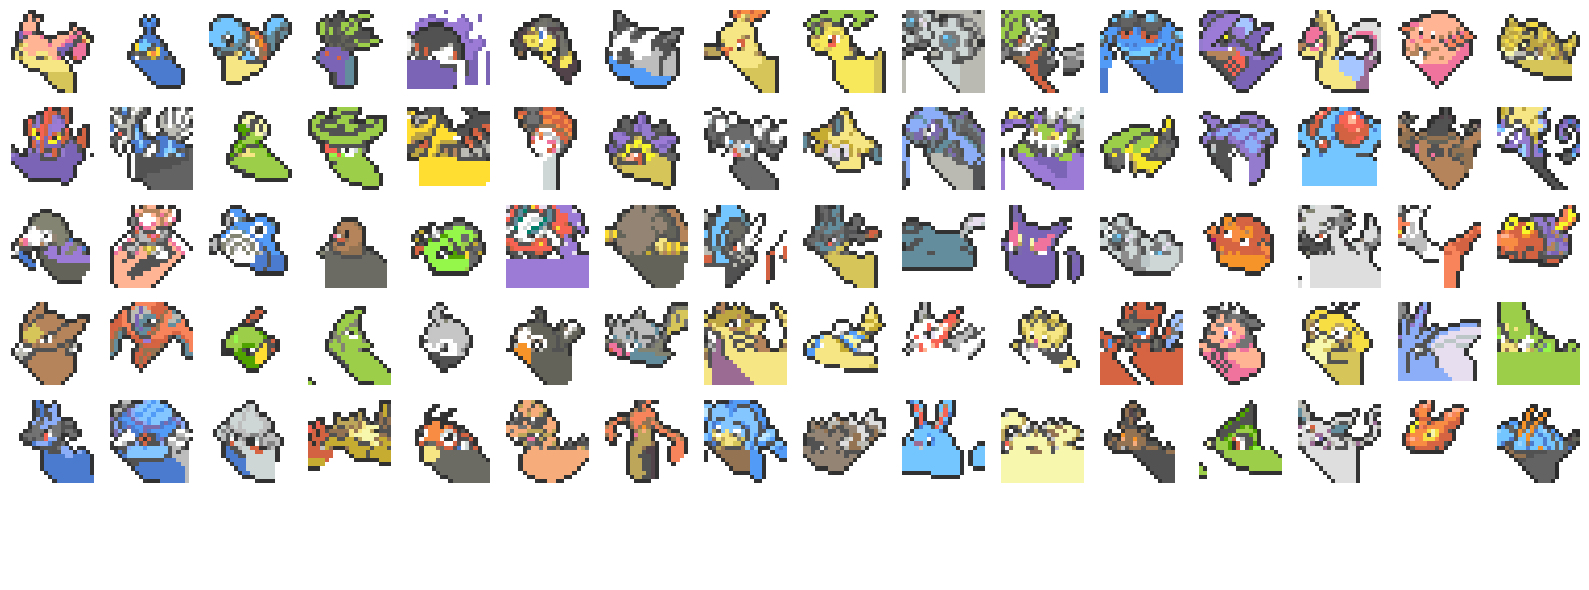

Training Epoch 20/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 20/100, Loss: 1.1459


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Epoch 20/100, Reconstruction Accuracy: 0.3338
Model saved at checkpoints/best_model.pth (Loss: 1.1459, Epoch: 20)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


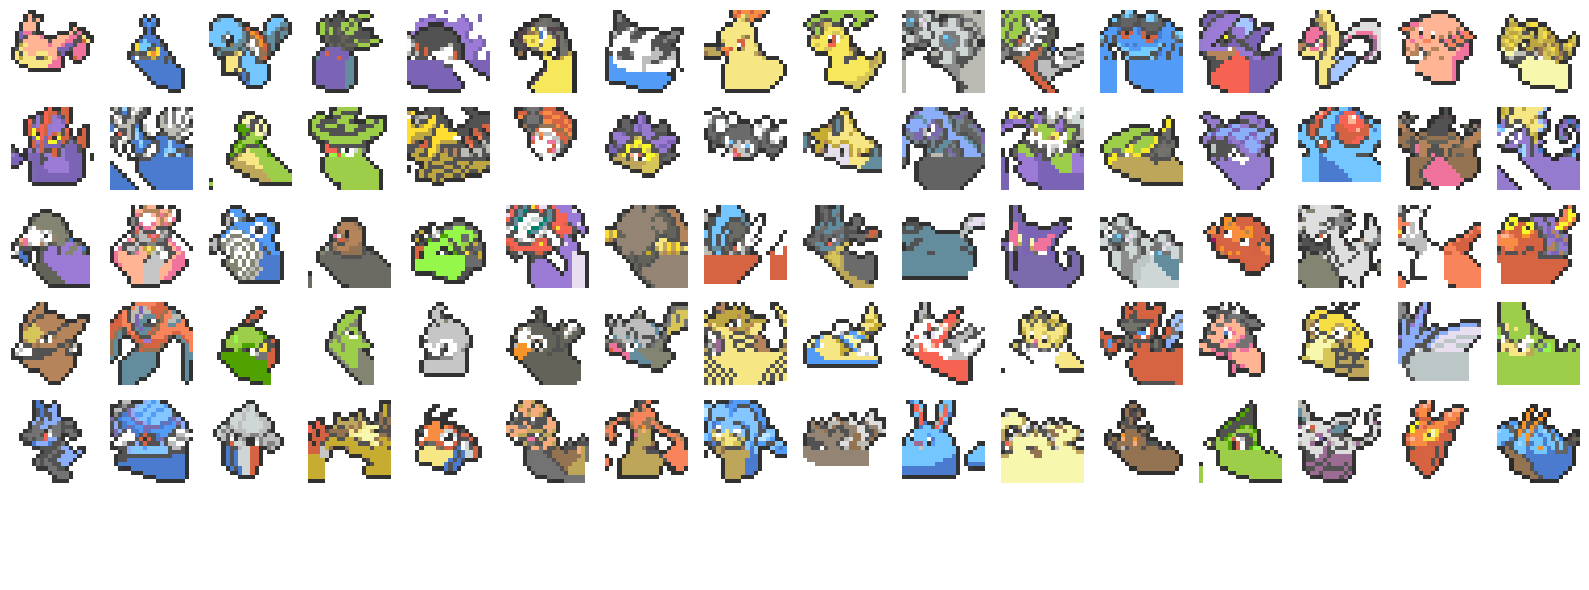

Training Epoch 21/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 21/100, Loss: 1.1201


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 21/100, Reconstruction Accuracy: 0.3630
Model saved at checkpoints/best_model.pth (Loss: 1.1201, Epoch: 21)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


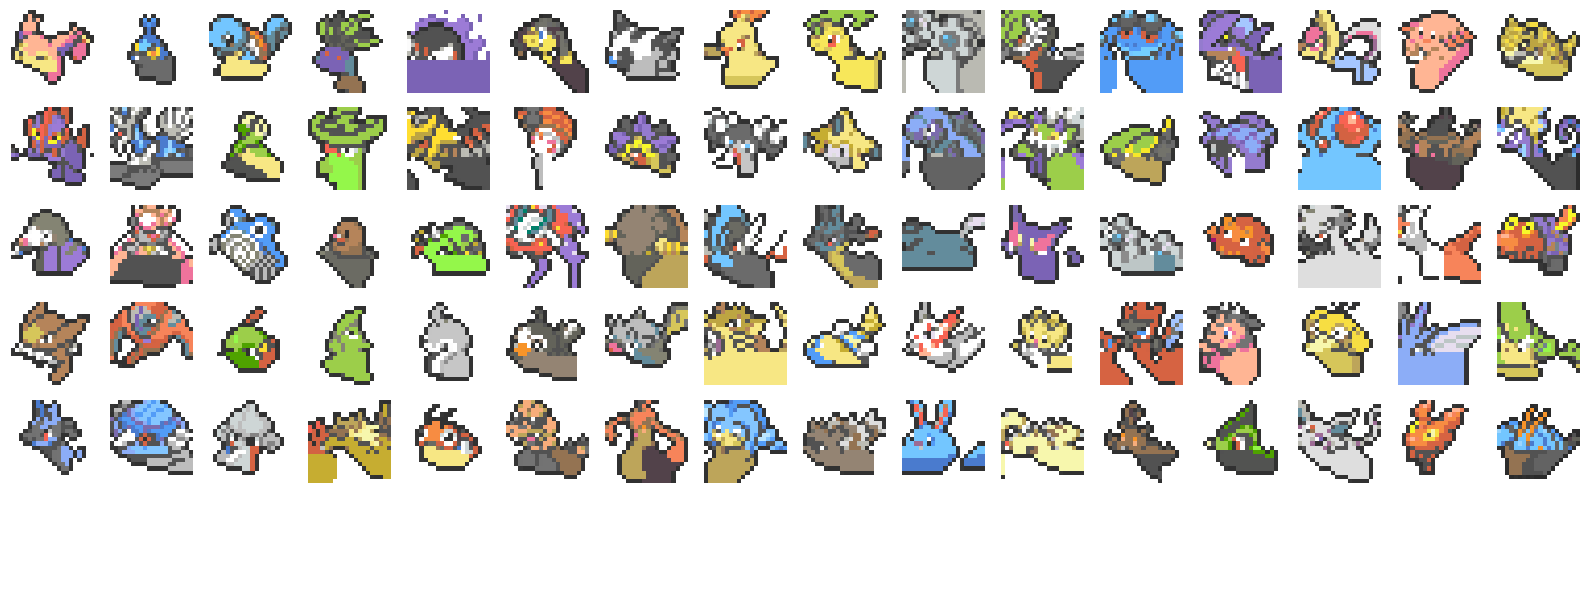

Training Epoch 22/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 22/100, Loss: 1.0809


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 22/100, Reconstruction Accuracy: 0.3864
Model saved at checkpoints/best_model.pth (Loss: 1.0809, Epoch: 22)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


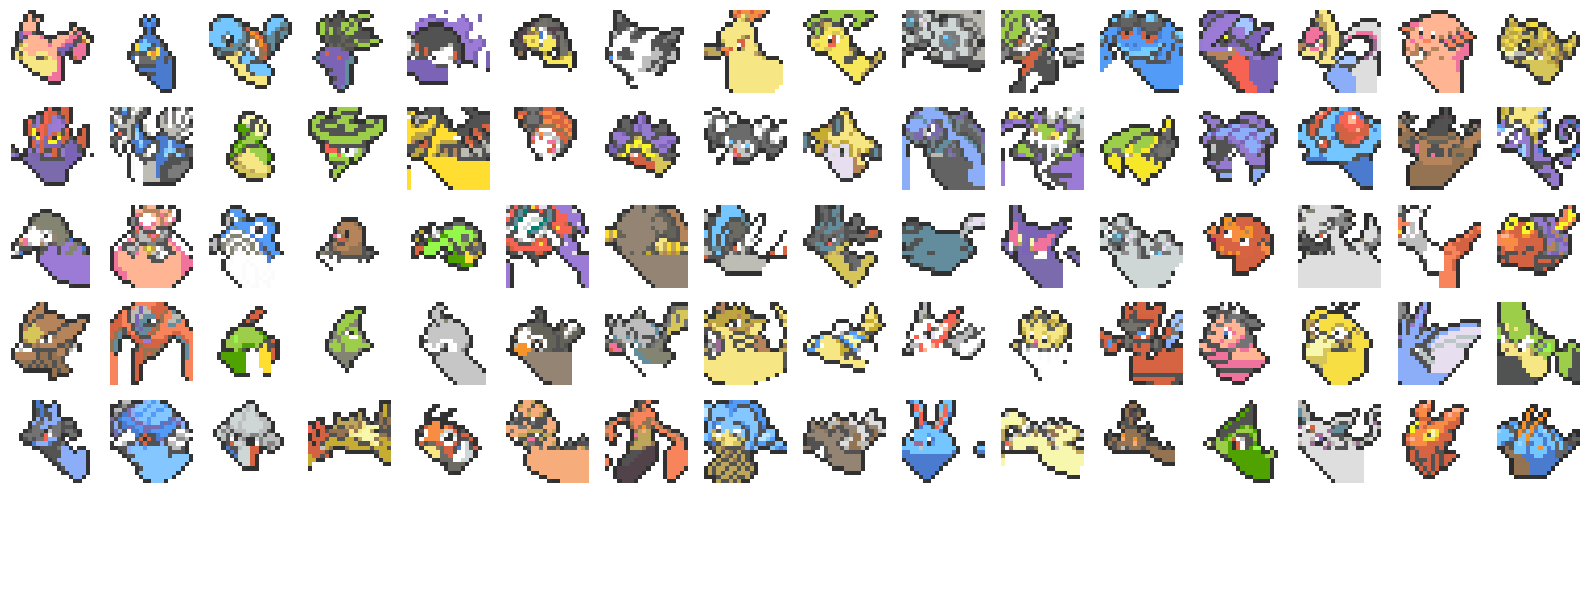

Training Epoch 23/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 23/100, Loss: 1.0440


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 23/100, Reconstruction Accuracy: 0.3636
Model saved at checkpoints/best_model.pth (Loss: 1.0440, Epoch: 23)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


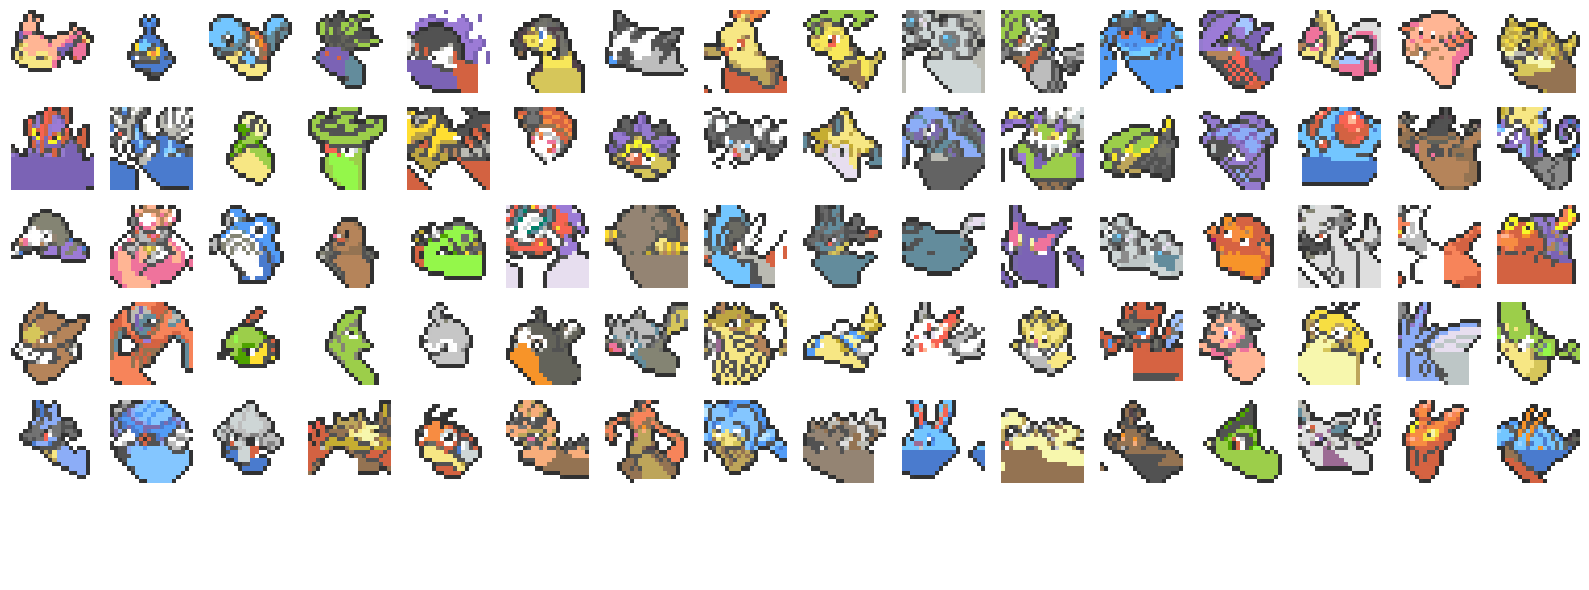

Training Epoch 24/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 24/100, Loss: 1.0134


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 24/100, Reconstruction Accuracy: 0.3517
Model saved at checkpoints/best_model.pth (Loss: 1.0134, Epoch: 24)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.75s/it]


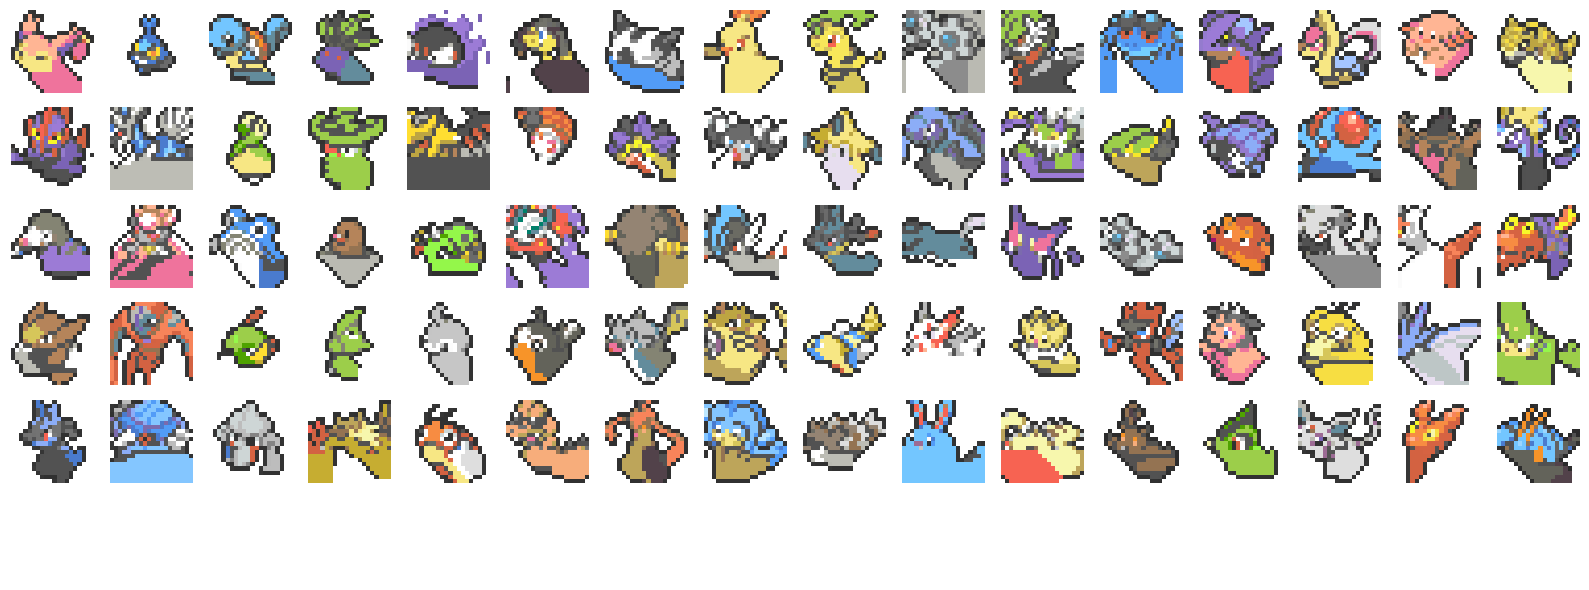

Training Epoch 25/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 25/100, Loss: 0.9802


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 25/100, Reconstruction Accuracy: 0.3778
Model saved at checkpoints/best_model.pth (Loss: 0.9802, Epoch: 25)


Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.81s/it]


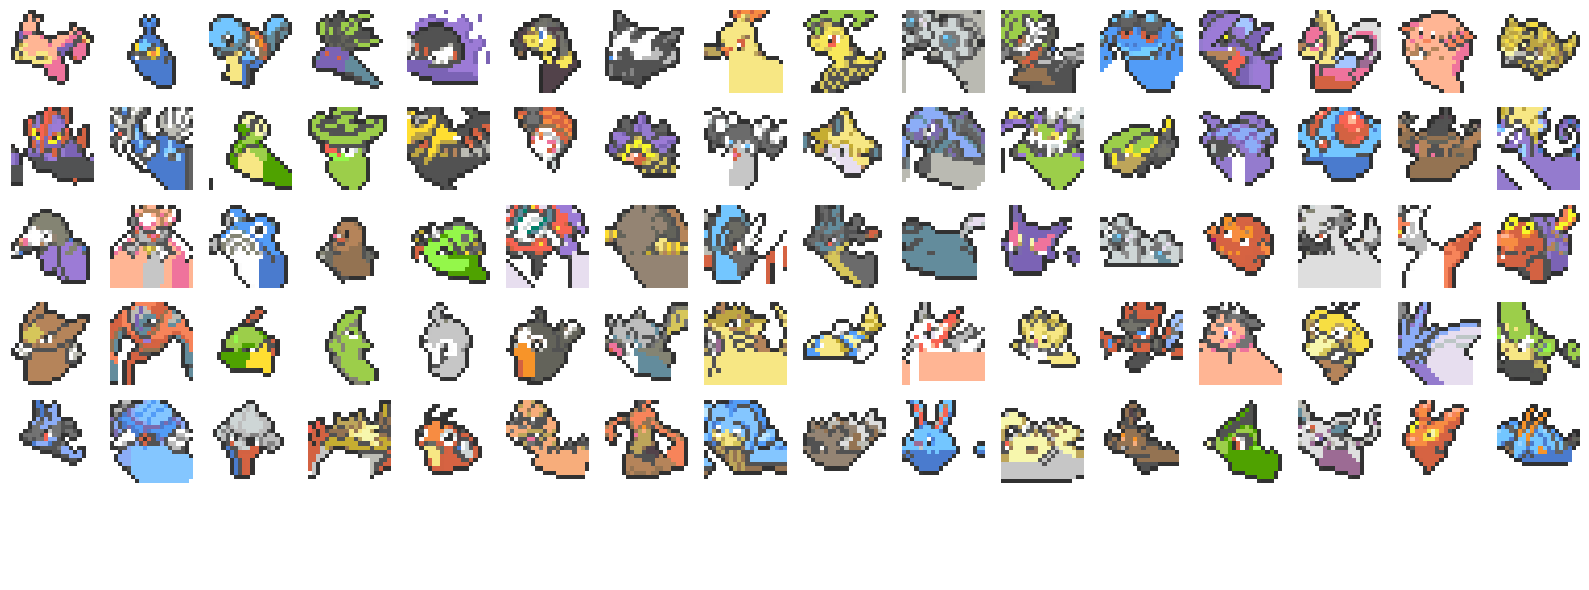

Training Epoch 26/100: 100%|██████████| 40/40 [01:41<00:00,  2.55s/it]


Epoch 26/100, Loss: 0.9510


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.81s/it]


Epoch 26/100, Reconstruction Accuracy: 0.3800
Model saved at checkpoints/best_model.pth (Loss: 0.9510, Epoch: 26)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


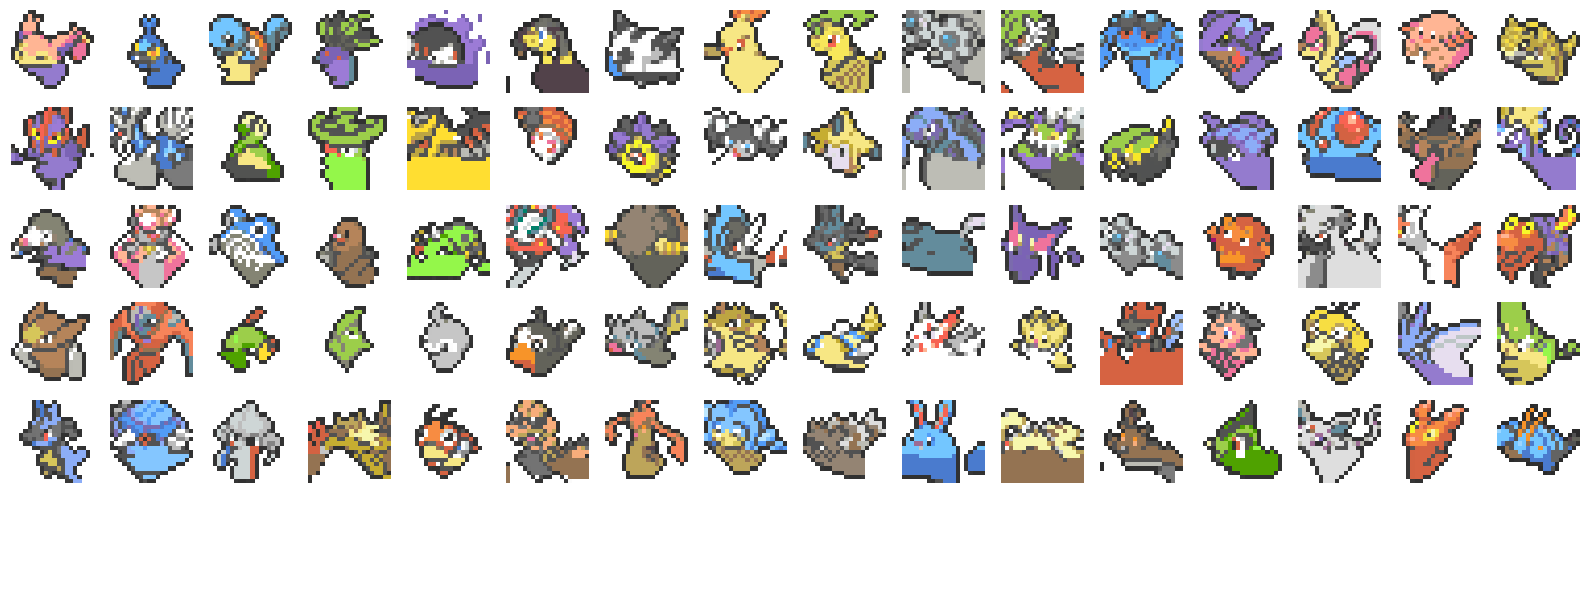

Training Epoch 27/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 27/100, Loss: 0.9188


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 27/100, Reconstruction Accuracy: 0.3680
Model saved at checkpoints/best_model.pth (Loss: 0.9188, Epoch: 27)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


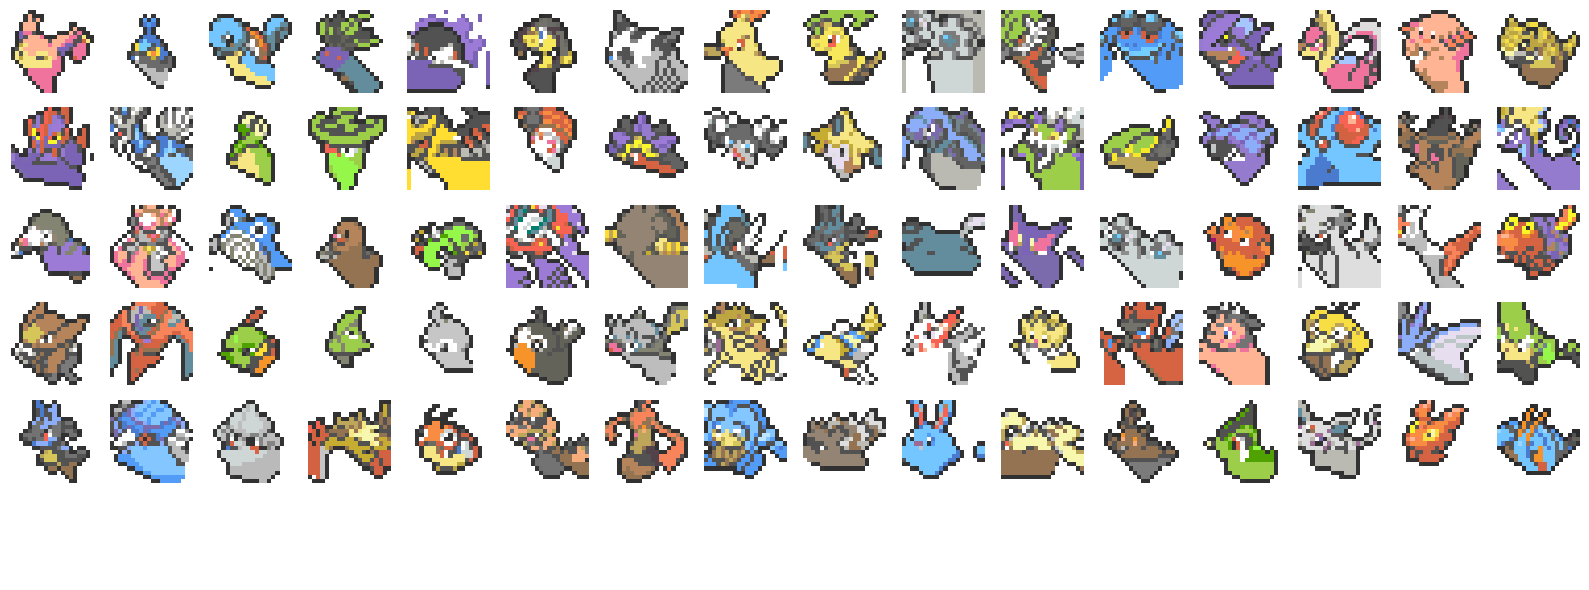

Training Epoch 28/100: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


Epoch 28/100, Loss: 0.8910


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


Epoch 28/100, Reconstruction Accuracy: 0.3535
Model saved at checkpoints/best_model.pth (Loss: 0.8910, Epoch: 28)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.74s/it]


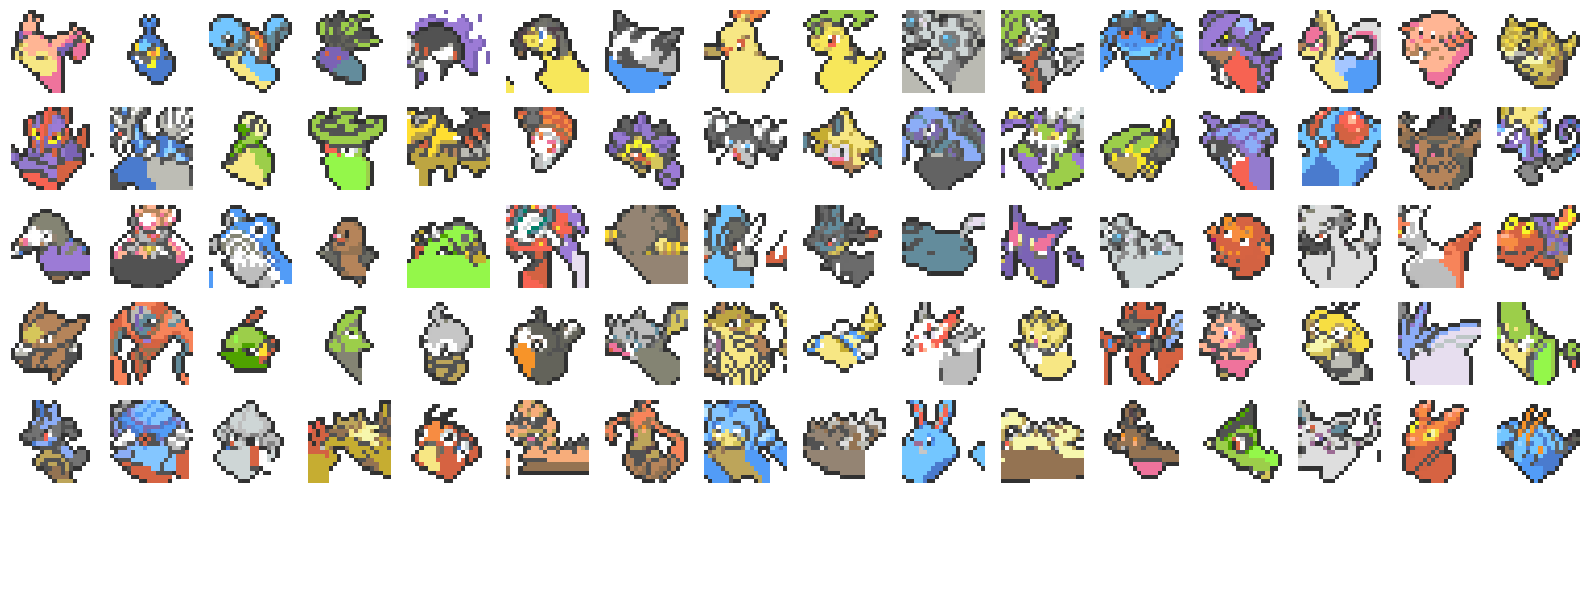

Training Epoch 29/100: 100%|██████████| 40/40 [01:39<00:00,  2.49s/it]


Epoch 29/100, Loss: 0.8585


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Epoch 29/100, Reconstruction Accuracy: 0.3602
Model saved at checkpoints/best_model.pth (Loss: 0.8585, Epoch: 29)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.75s/it]


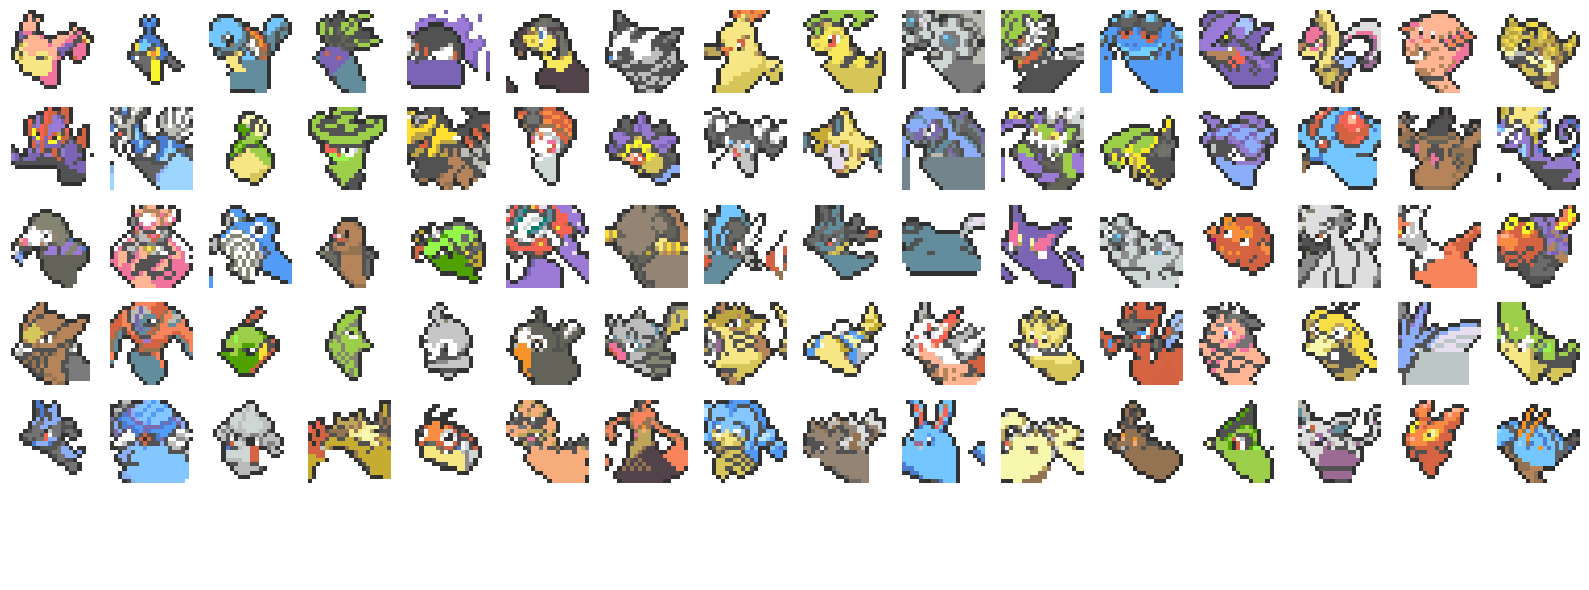

Training Epoch 30/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 30/100, Loss: 0.8294


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Epoch 30/100, Reconstruction Accuracy: 0.3643
Model saved at checkpoints/best_model.pth (Loss: 0.8294, Epoch: 30)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


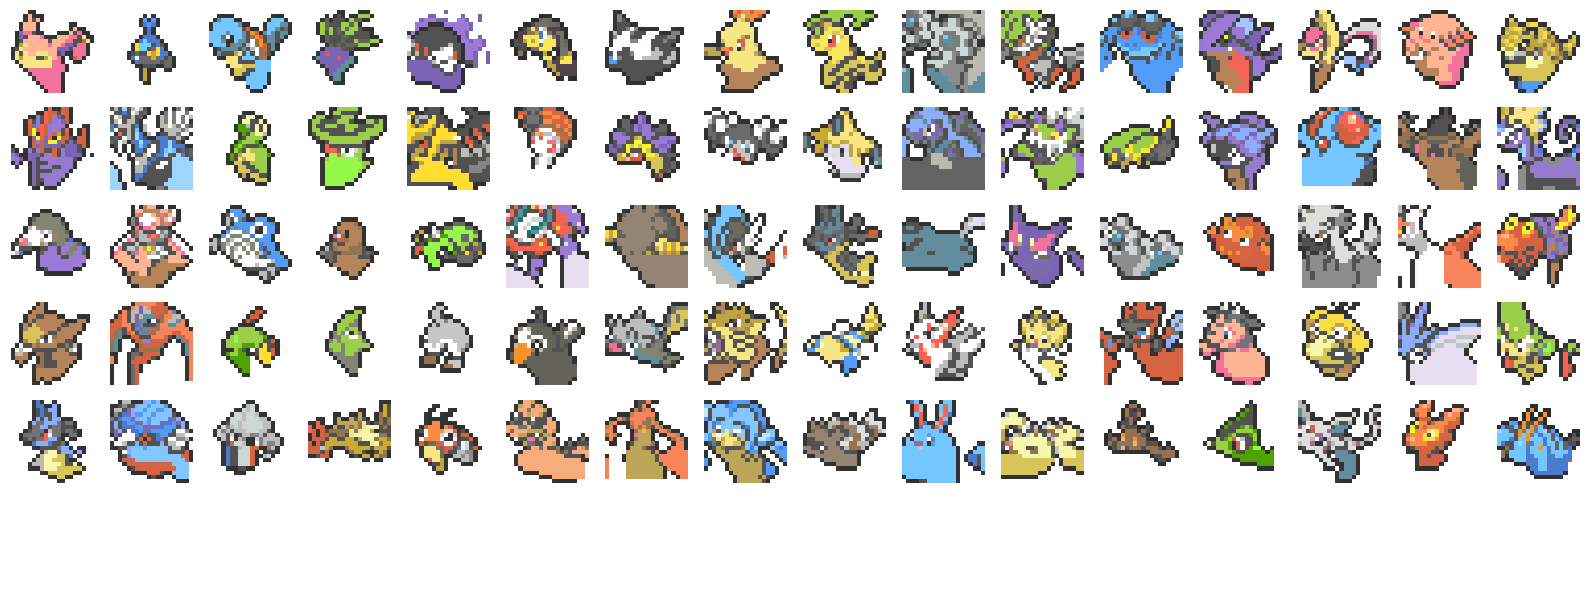

Training Epoch 31/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 31/100, Loss: 0.7977


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 31/100, Reconstruction Accuracy: 0.3759
Model saved at checkpoints/best_model.pth (Loss: 0.7977, Epoch: 31)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.75s/it]


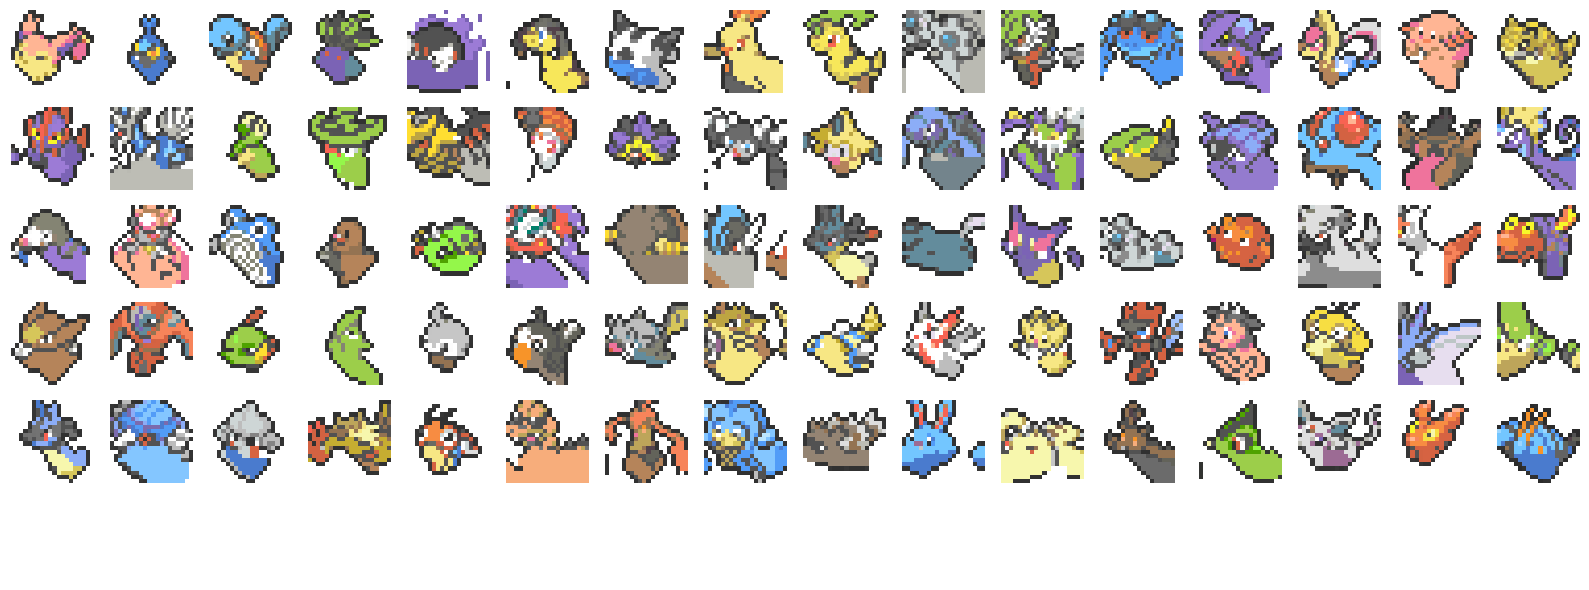

Training Epoch 32/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 32/100, Loss: 0.7702


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 32/100, Reconstruction Accuracy: 0.3694
Model saved at checkpoints/best_model.pth (Loss: 0.7702, Epoch: 32)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


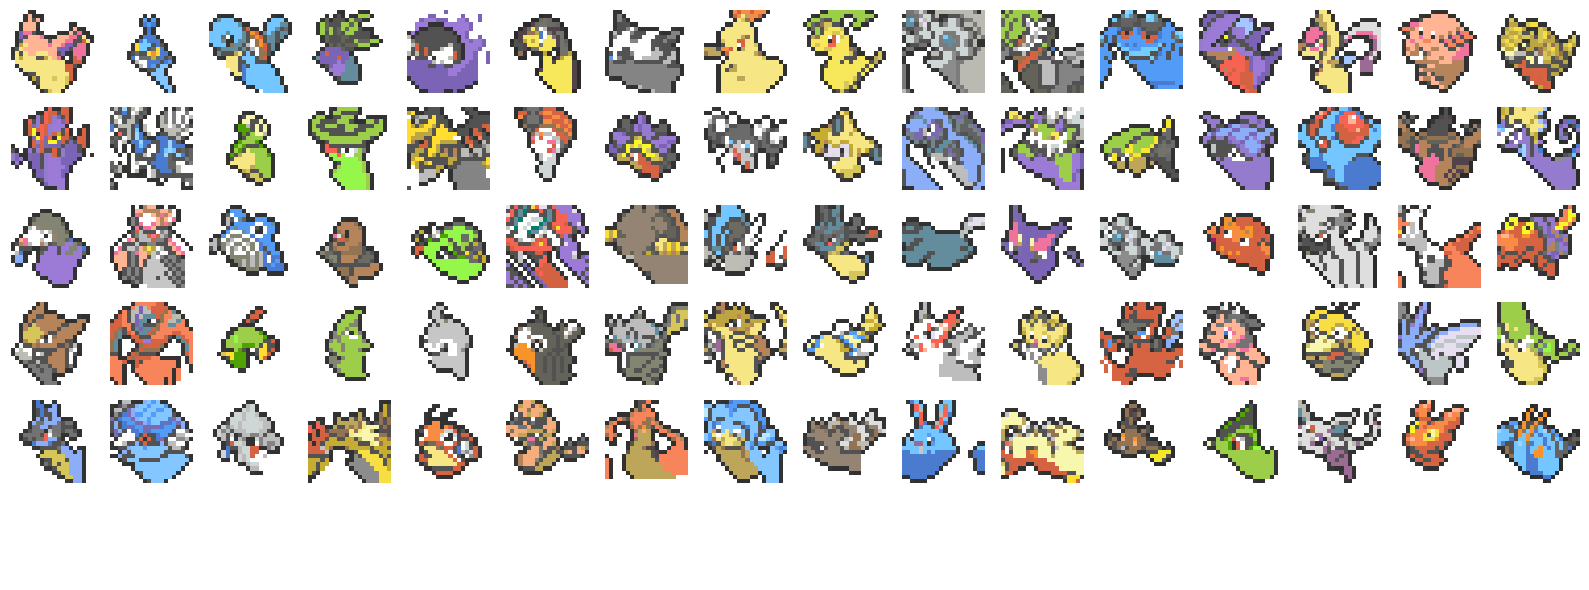

Training Epoch 33/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 33/100, Loss: 0.7342


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 33/100, Reconstruction Accuracy: 0.3497
Model saved at checkpoints/best_model.pth (Loss: 0.7342, Epoch: 33)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


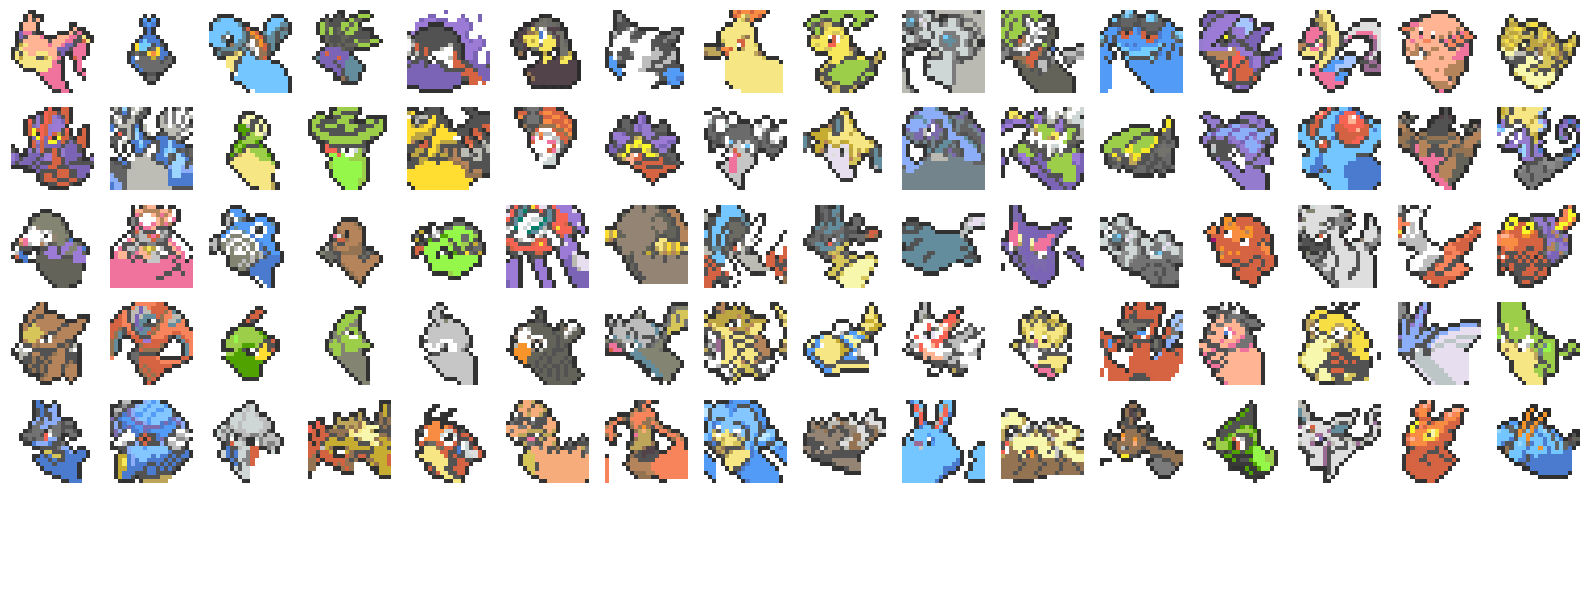

Training Epoch 34/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 34/100, Loss: 0.7103


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 34/100, Reconstruction Accuracy: 0.3660
Model saved at checkpoints/best_model.pth (Loss: 0.7103, Epoch: 34)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


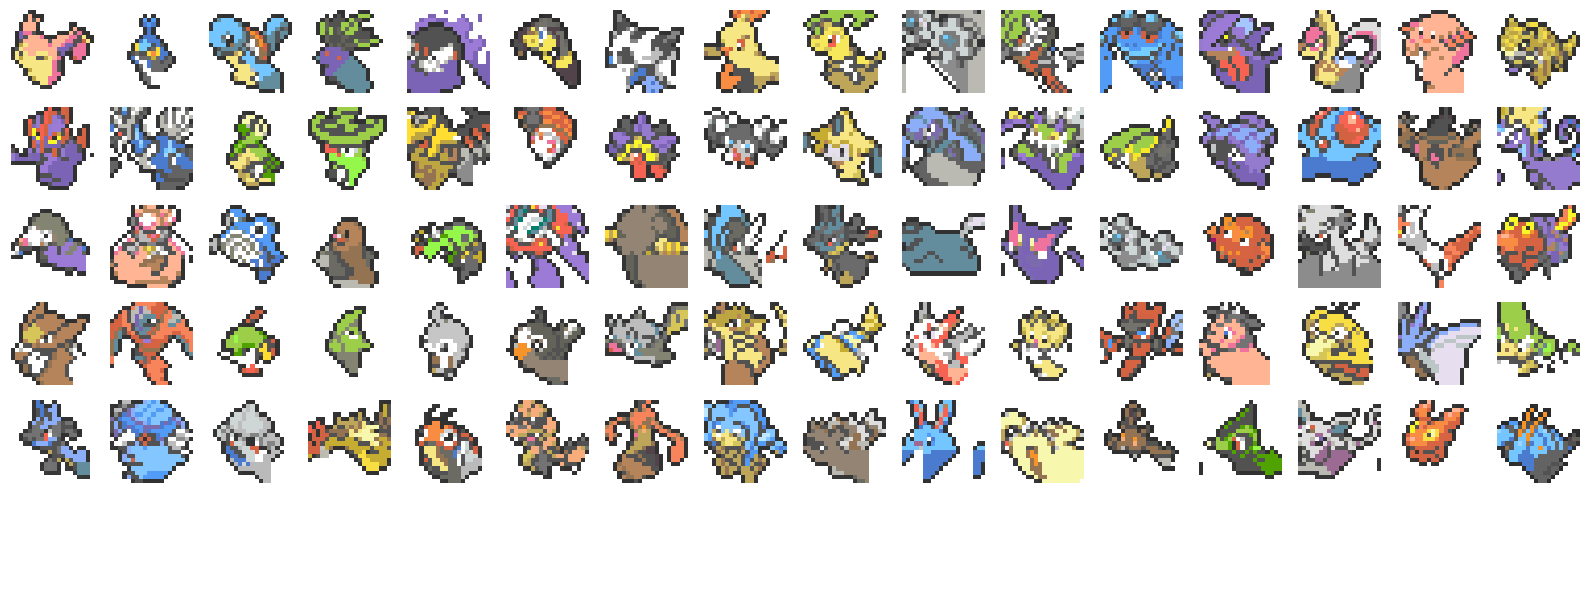

Training Epoch 35/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 35/100, Loss: 0.6858


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 35/100, Reconstruction Accuracy: 0.3522
Model saved at checkpoints/best_model.pth (Loss: 0.6858, Epoch: 35)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


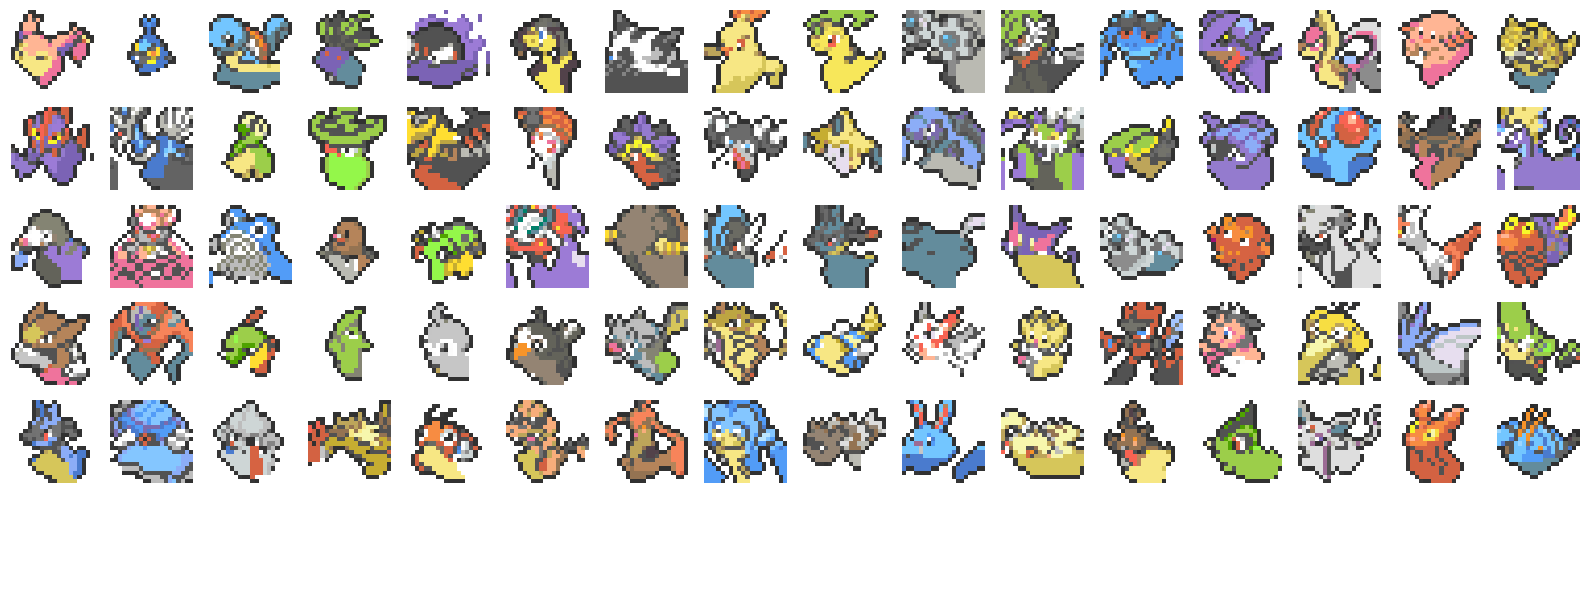

Training Epoch 36/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 36/100, Loss: 0.6532


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 36/100, Reconstruction Accuracy: 0.3727
Model saved at checkpoints/best_model.pth (Loss: 0.6532, Epoch: 36)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


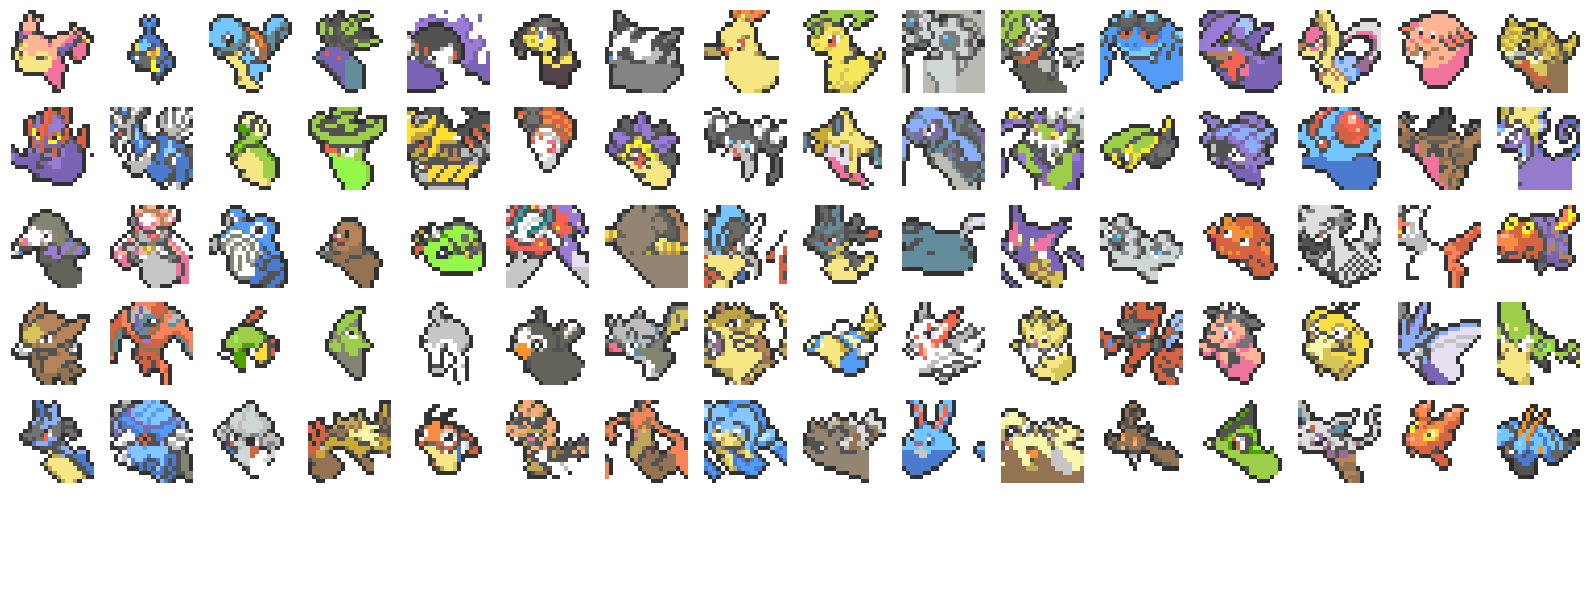

Training Epoch 37/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 37/100, Loss: 0.6347


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 37/100, Reconstruction Accuracy: 0.3909
Model saved at checkpoints/best_model.pth (Loss: 0.6347, Epoch: 37)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


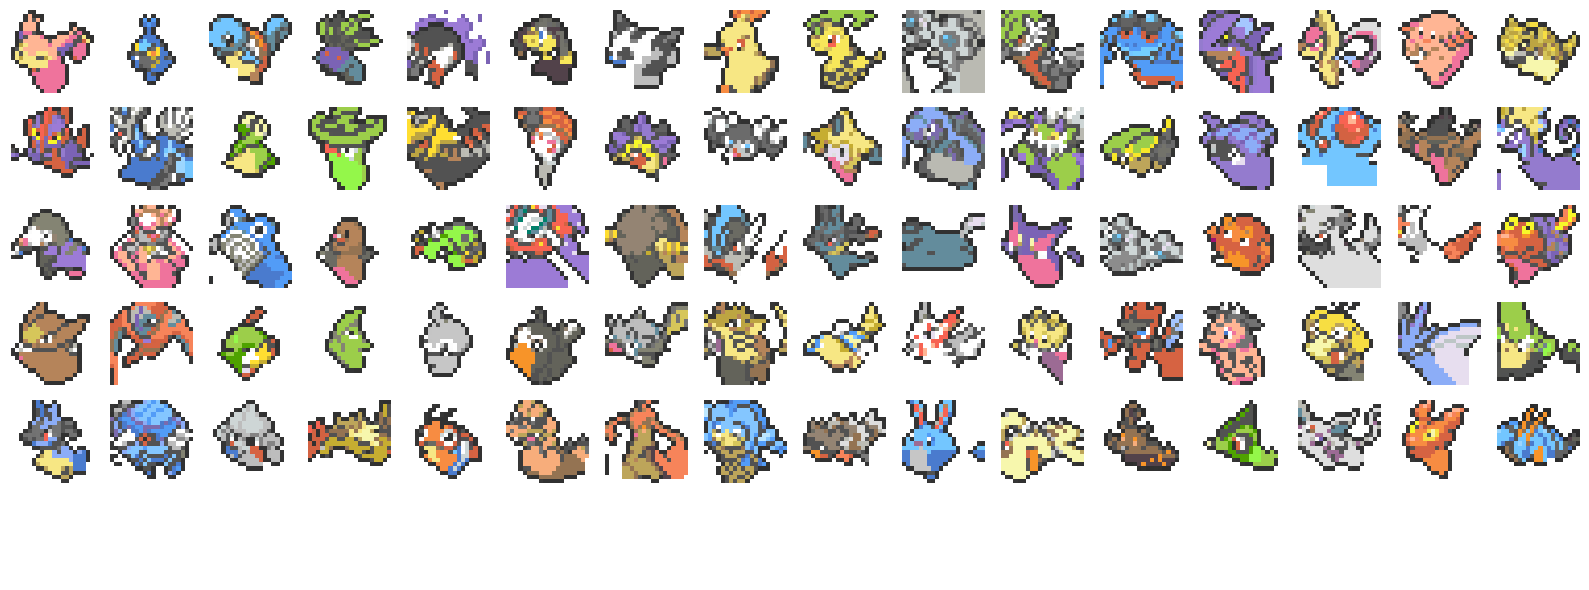

Training Epoch 38/100: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


Epoch 38/100, Loss: 0.6180


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 38/100, Reconstruction Accuracy: 0.3870
Model saved at checkpoints/best_model.pth (Loss: 0.6180, Epoch: 38)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


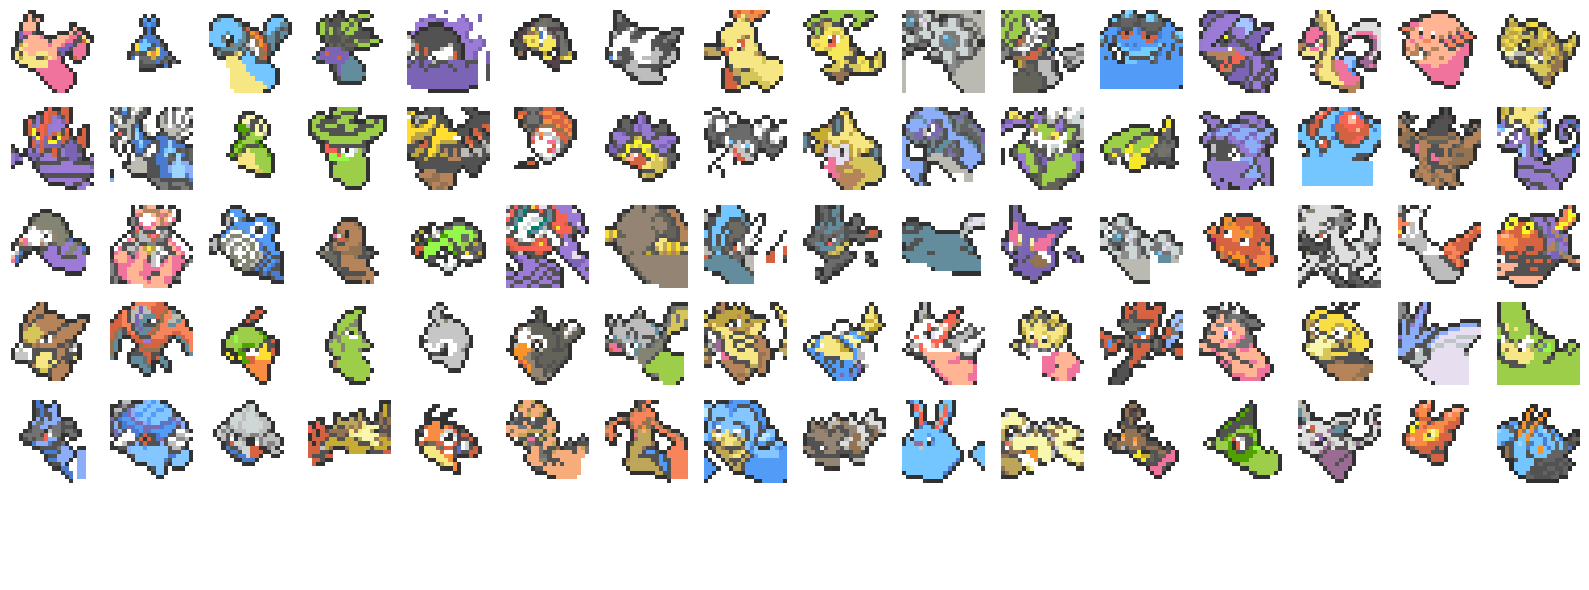

Training Epoch 39/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 39/100, Loss: 0.5903


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 39/100, Reconstruction Accuracy: 0.3868
Model saved at checkpoints/best_model.pth (Loss: 0.5903, Epoch: 39)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


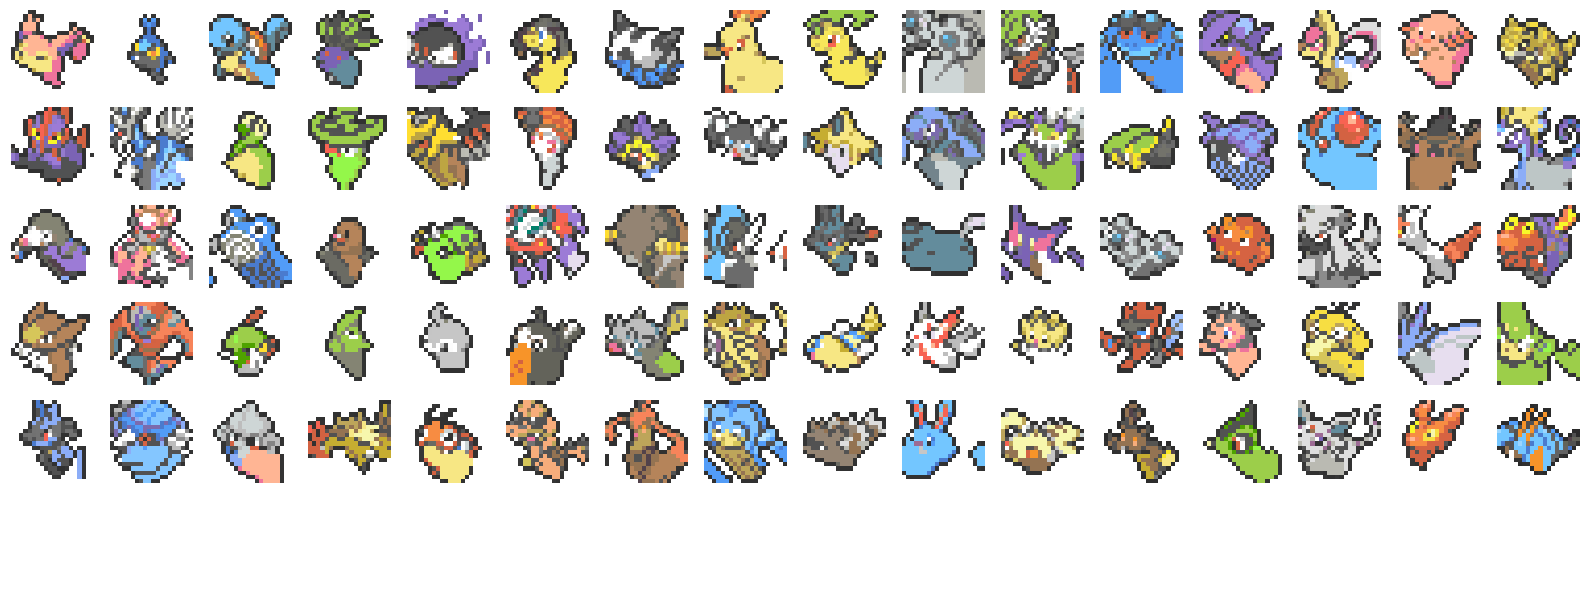

Training Epoch 40/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 40/100, Loss: 0.5490


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 40/100, Reconstruction Accuracy: 0.3931
Model saved at checkpoints/best_model.pth (Loss: 0.5490, Epoch: 40)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


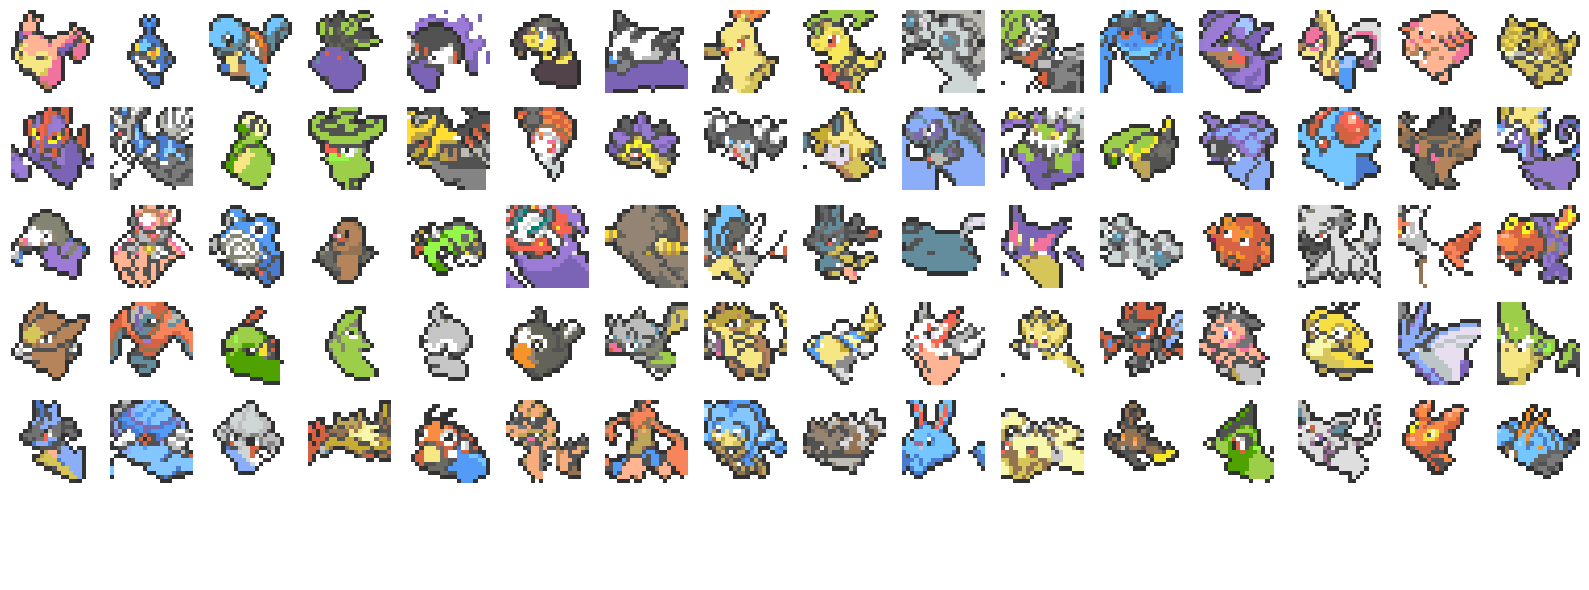

Training Epoch 41/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 41/100, Loss: 0.5548


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Epoch 41/100, Reconstruction Accuracy: 0.3807


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


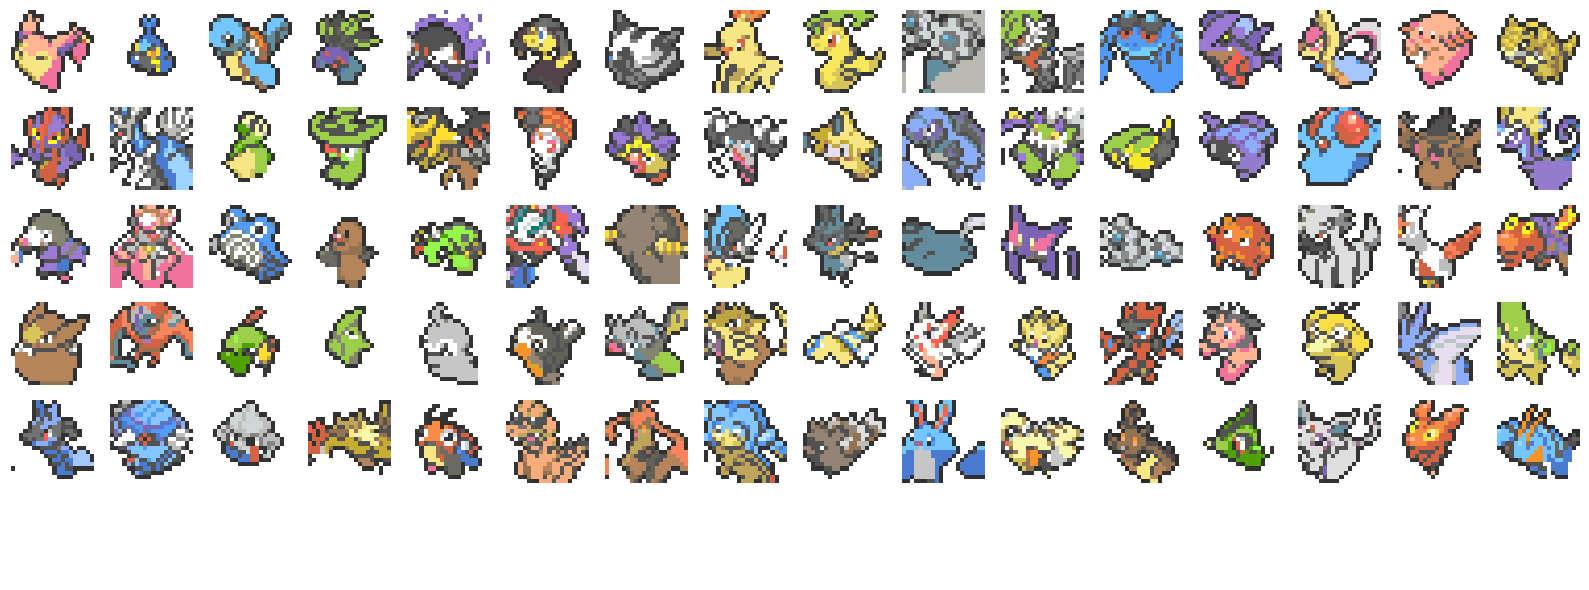

Training Epoch 42/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 42/100, Loss: 0.5271


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 42/100, Reconstruction Accuracy: 0.3884
Model saved at checkpoints/best_model.pth (Loss: 0.5271, Epoch: 42)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


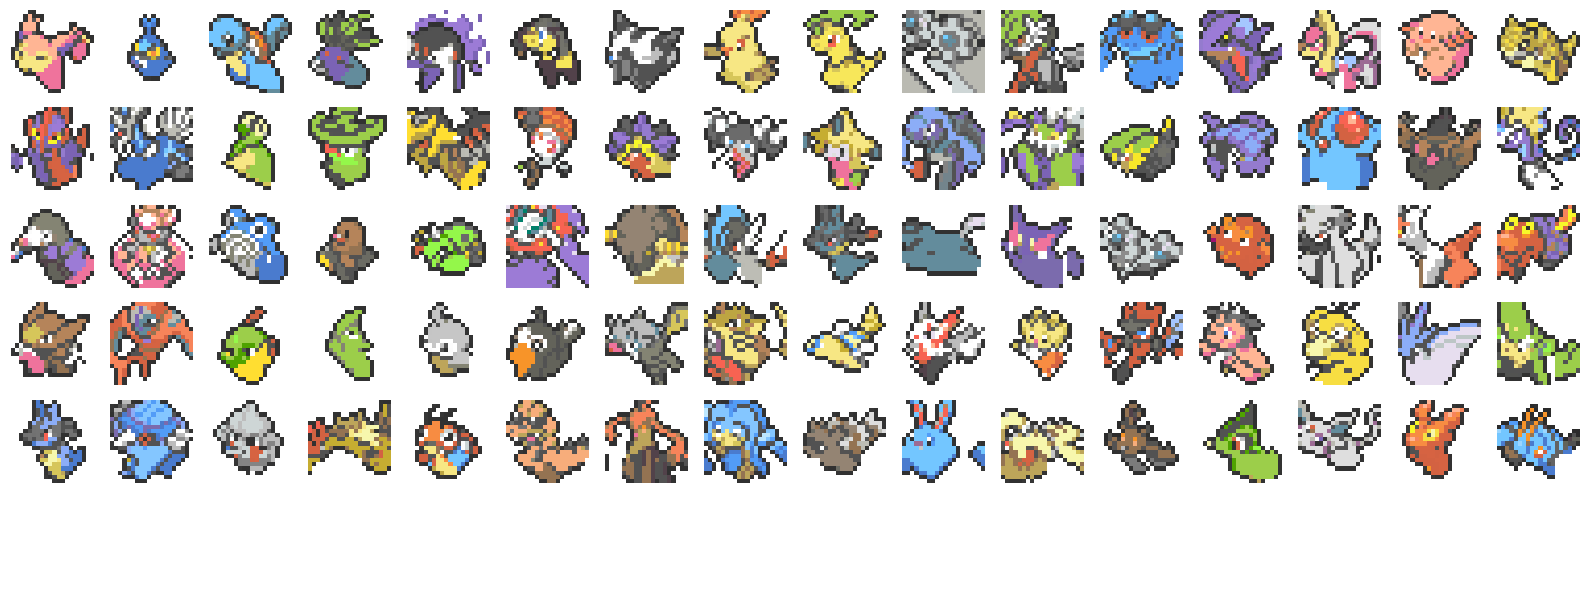

Training Epoch 43/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 43/100, Loss: 0.5197


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 43/100, Reconstruction Accuracy: 0.3679
Model saved at checkpoints/best_model.pth (Loss: 0.5197, Epoch: 43)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


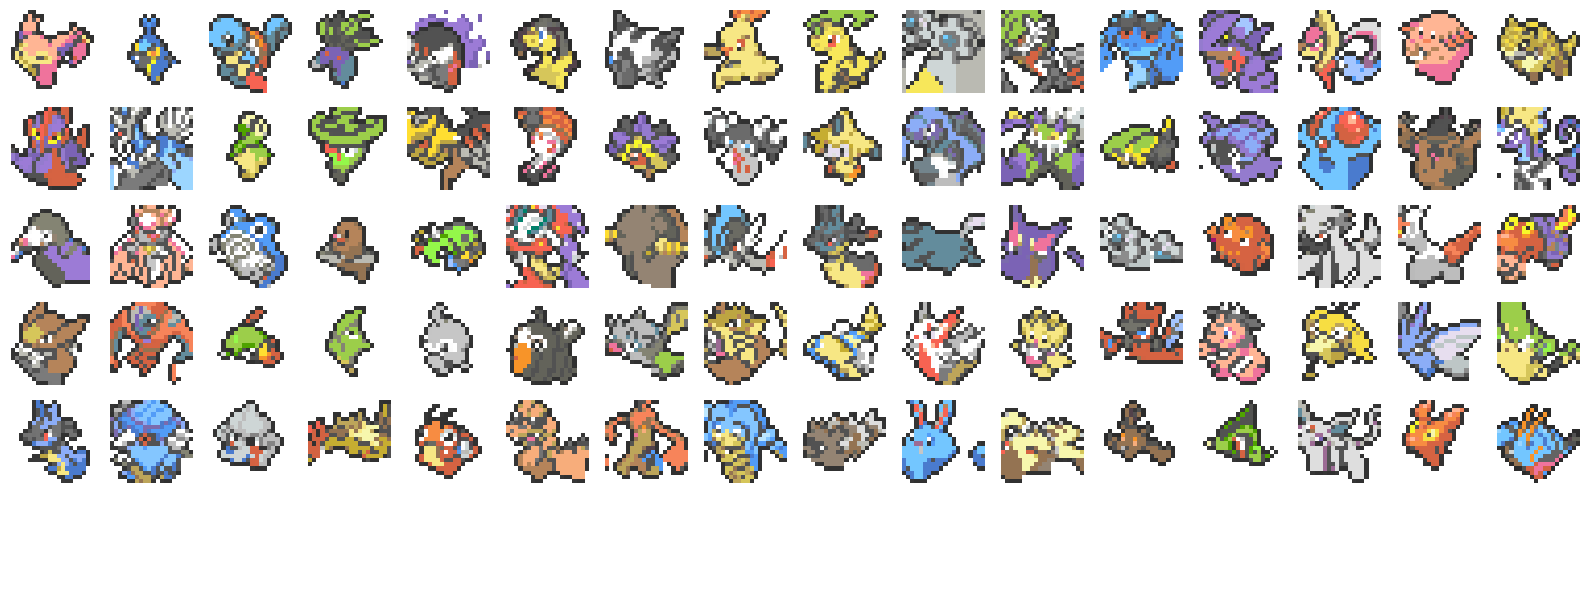

Training Epoch 44/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 44/100, Loss: 0.5058


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.89s/it]


Epoch 44/100, Reconstruction Accuracy: 0.3874
Model saved at checkpoints/best_model.pth (Loss: 0.5058, Epoch: 44)


Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.83s/it]


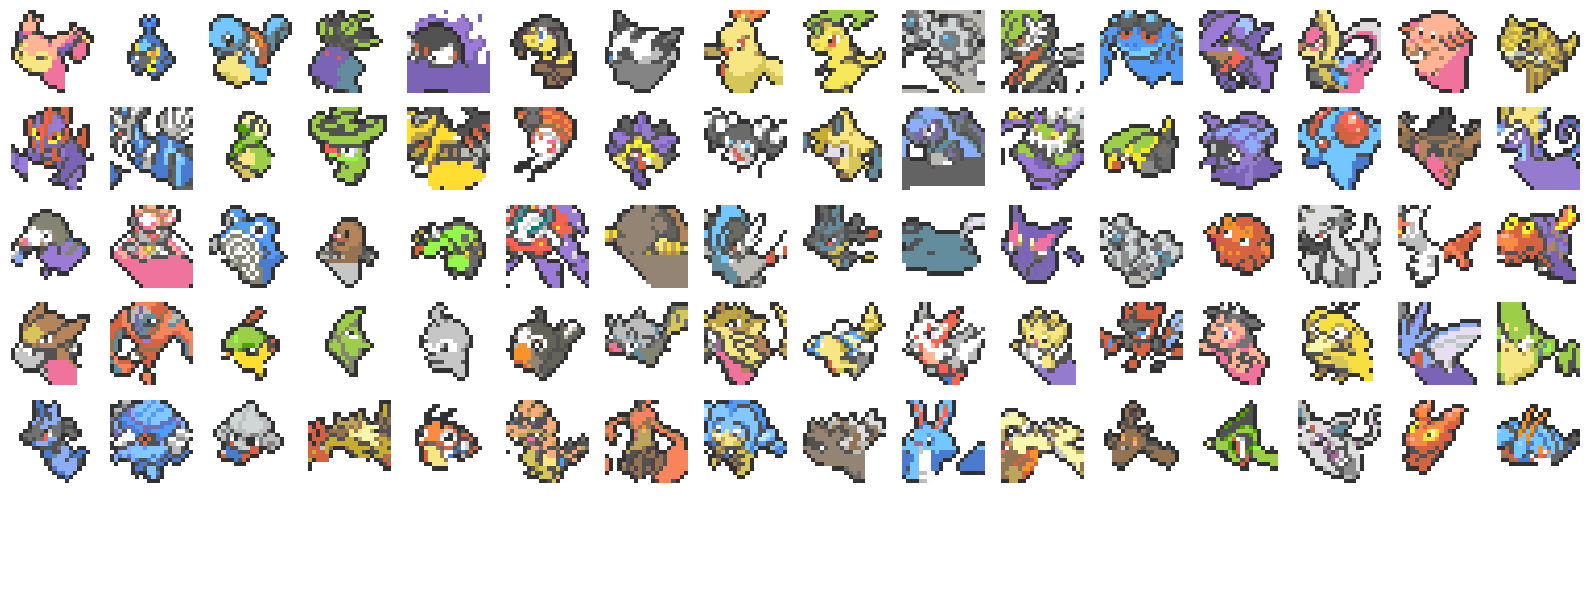

Training Epoch 45/100: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


Epoch 45/100, Loss: 0.4895


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 45/100, Reconstruction Accuracy: 0.3862
Model saved at checkpoints/best_model.pth (Loss: 0.4895, Epoch: 45)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


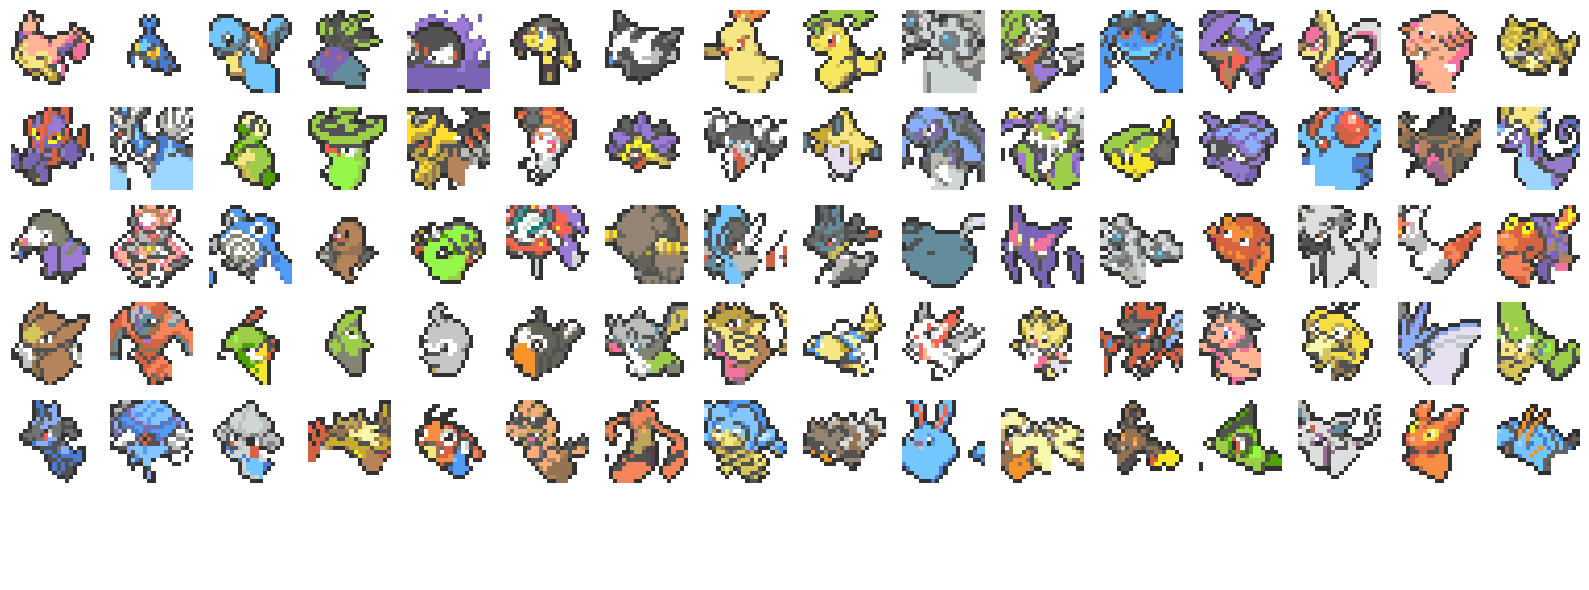

Training Epoch 46/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 46/100, Loss: 0.4892


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 46/100, Reconstruction Accuracy: 0.3805
Model saved at checkpoints/best_model.pth (Loss: 0.4892, Epoch: 46)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.75s/it]


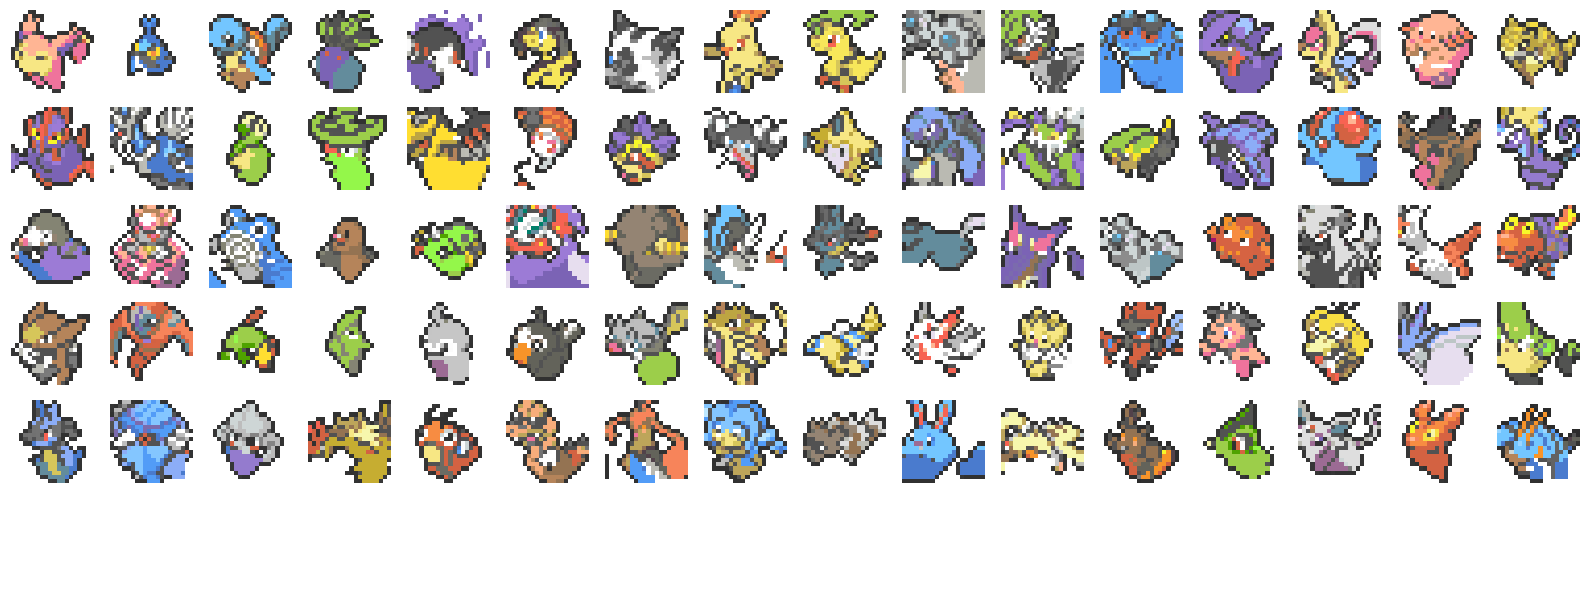

Training Epoch 47/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 47/100, Loss: 0.4491


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 47/100, Reconstruction Accuracy: 0.3898
Model saved at checkpoints/best_model.pth (Loss: 0.4491, Epoch: 47)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


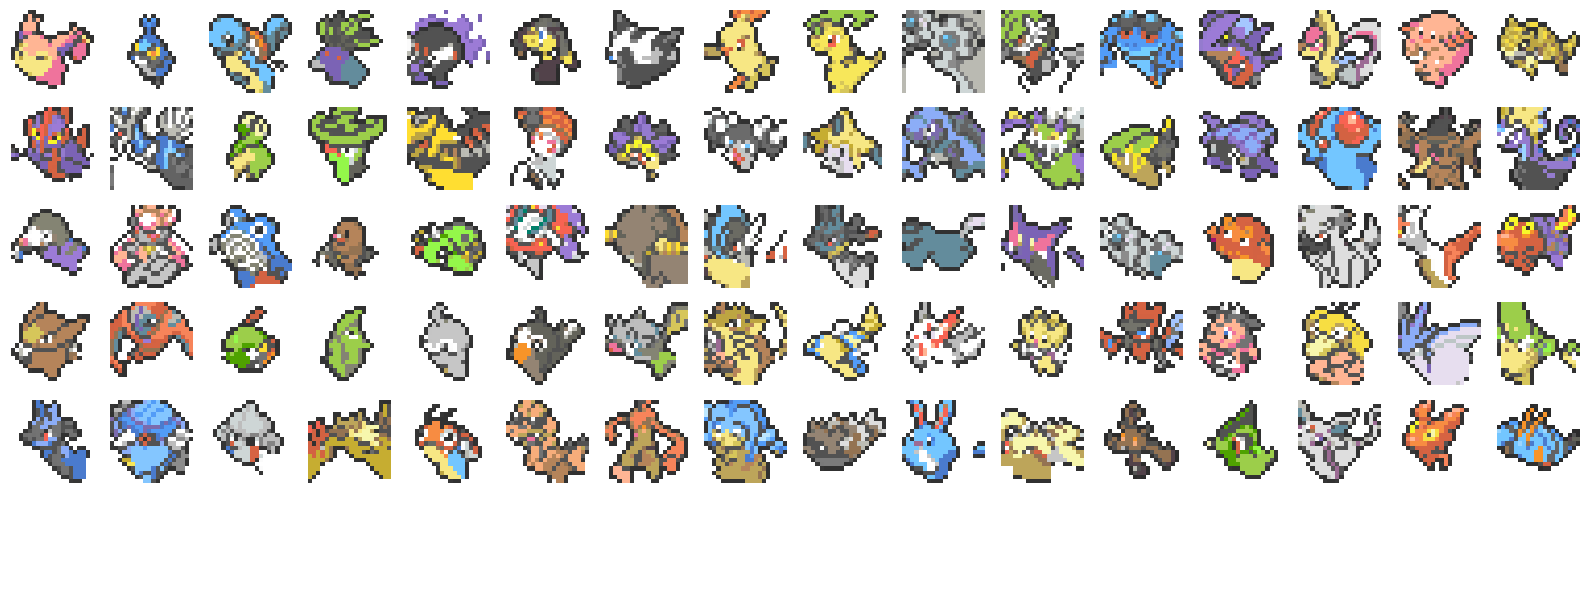

Training Epoch 48/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 48/100, Loss: 0.4589


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 48/100, Reconstruction Accuracy: 0.3728


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


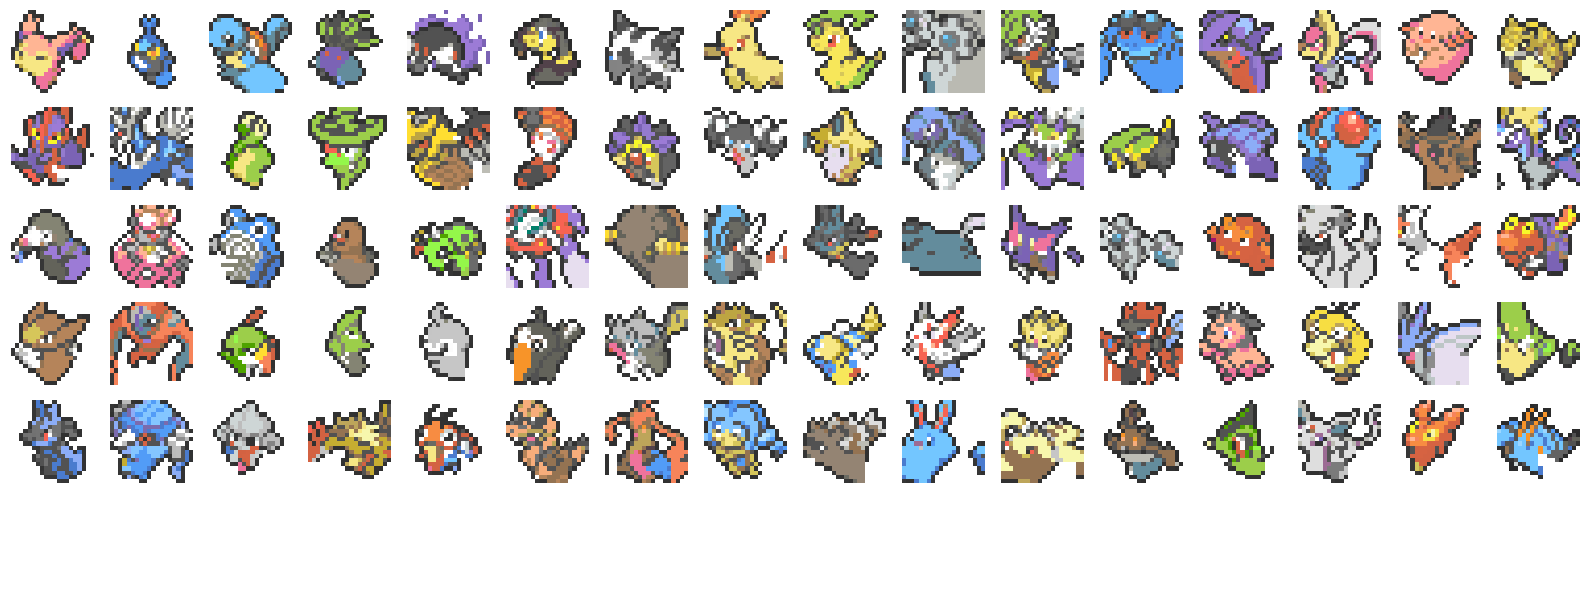

Training Epoch 49/100: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


Epoch 49/100, Loss: 0.4342


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 49/100, Reconstruction Accuracy: 0.3917
Model saved at checkpoints/best_model.pth (Loss: 0.4342, Epoch: 49)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


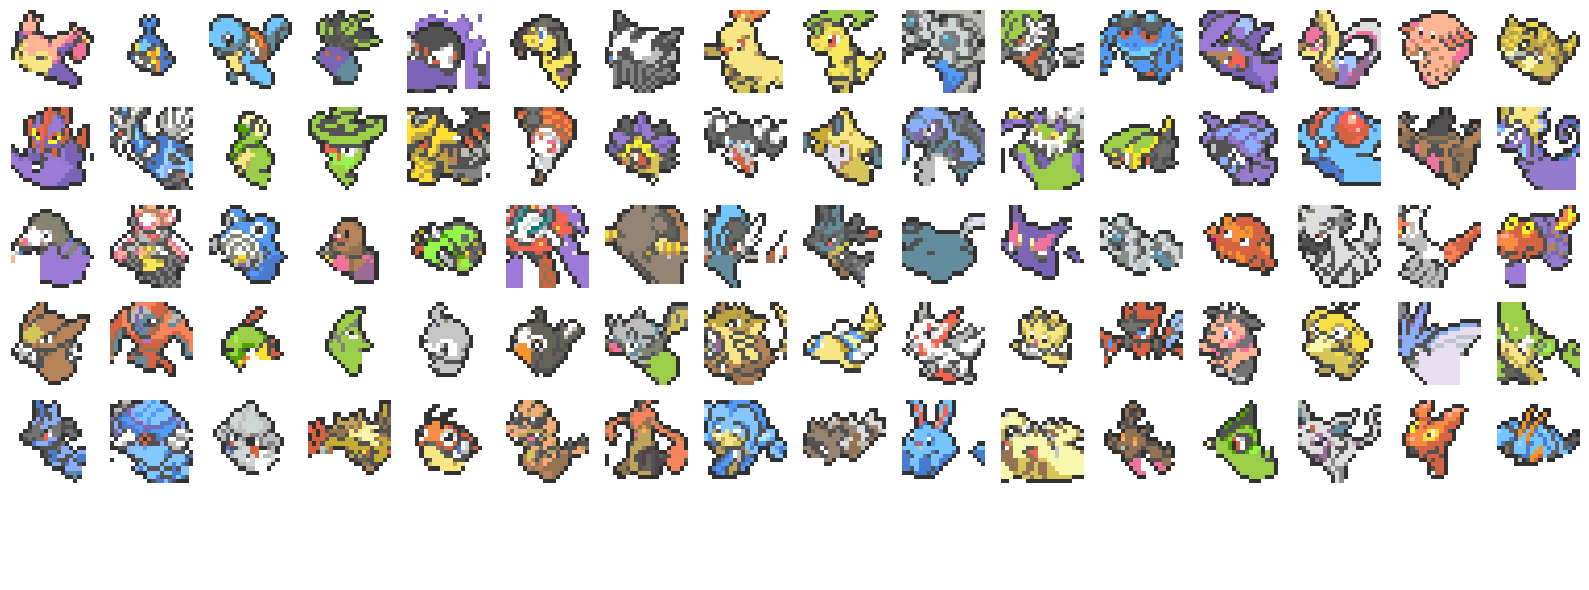

Training Epoch 50/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 50/100, Loss: 0.4397


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Epoch 50/100, Reconstruction Accuracy: 0.3824


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


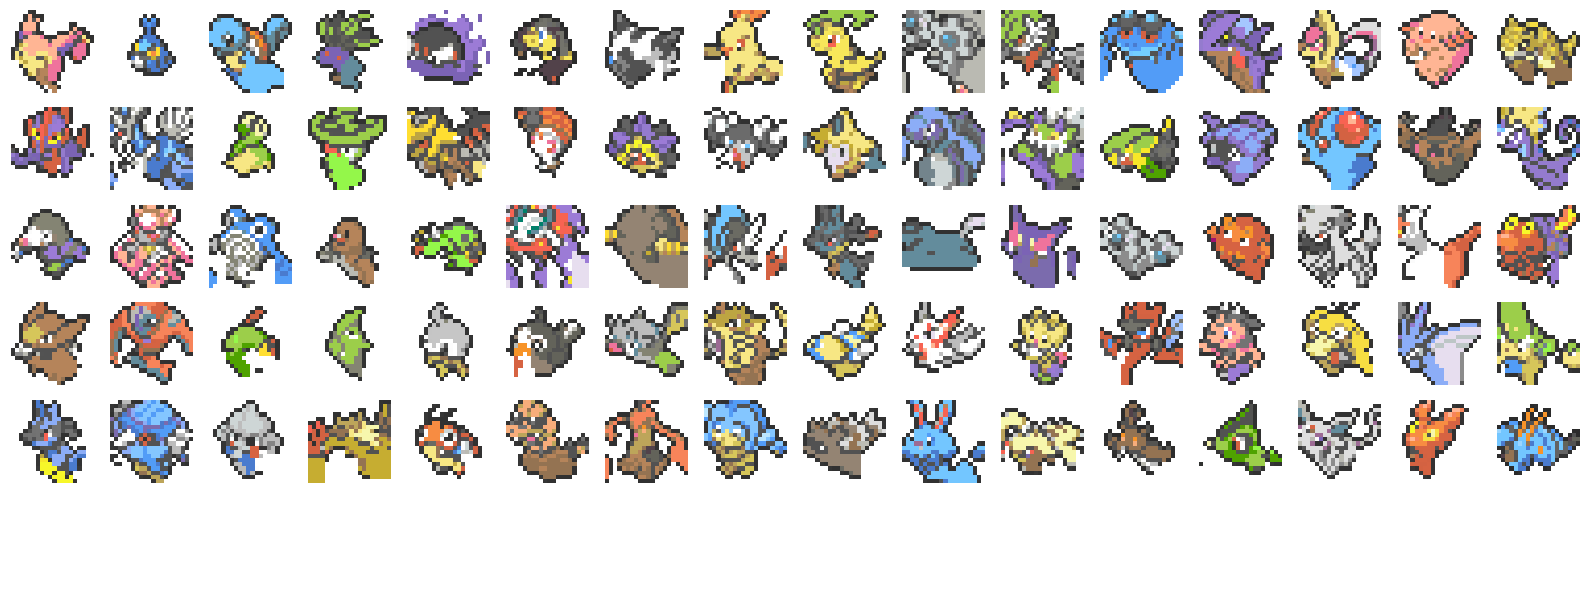

Training Epoch 51/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 51/100, Loss: 0.4182


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 51/100, Reconstruction Accuracy: 0.3736
Model saved at checkpoints/best_model.pth (Loss: 0.4182, Epoch: 51)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


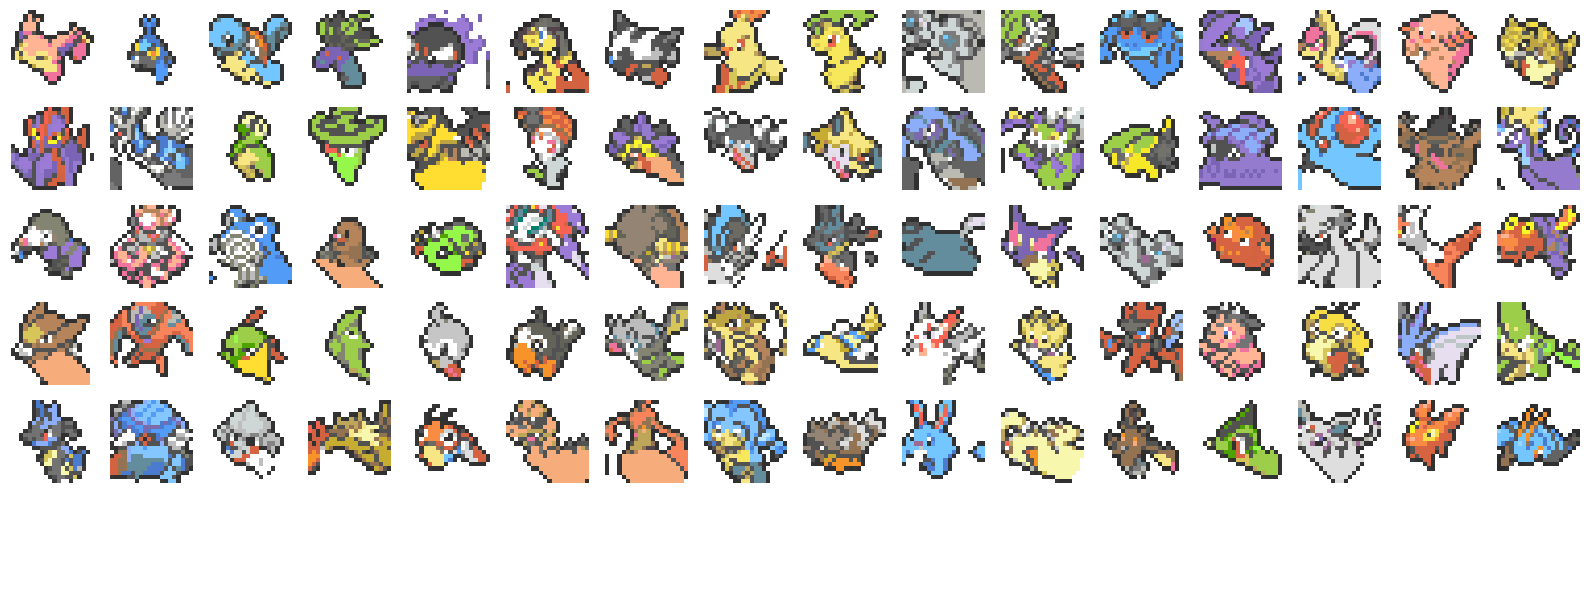

Training Epoch 52/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 52/100, Loss: 0.4008


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 52/100, Reconstruction Accuracy: 0.3897
Model saved at checkpoints/best_model.pth (Loss: 0.4008, Epoch: 52)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


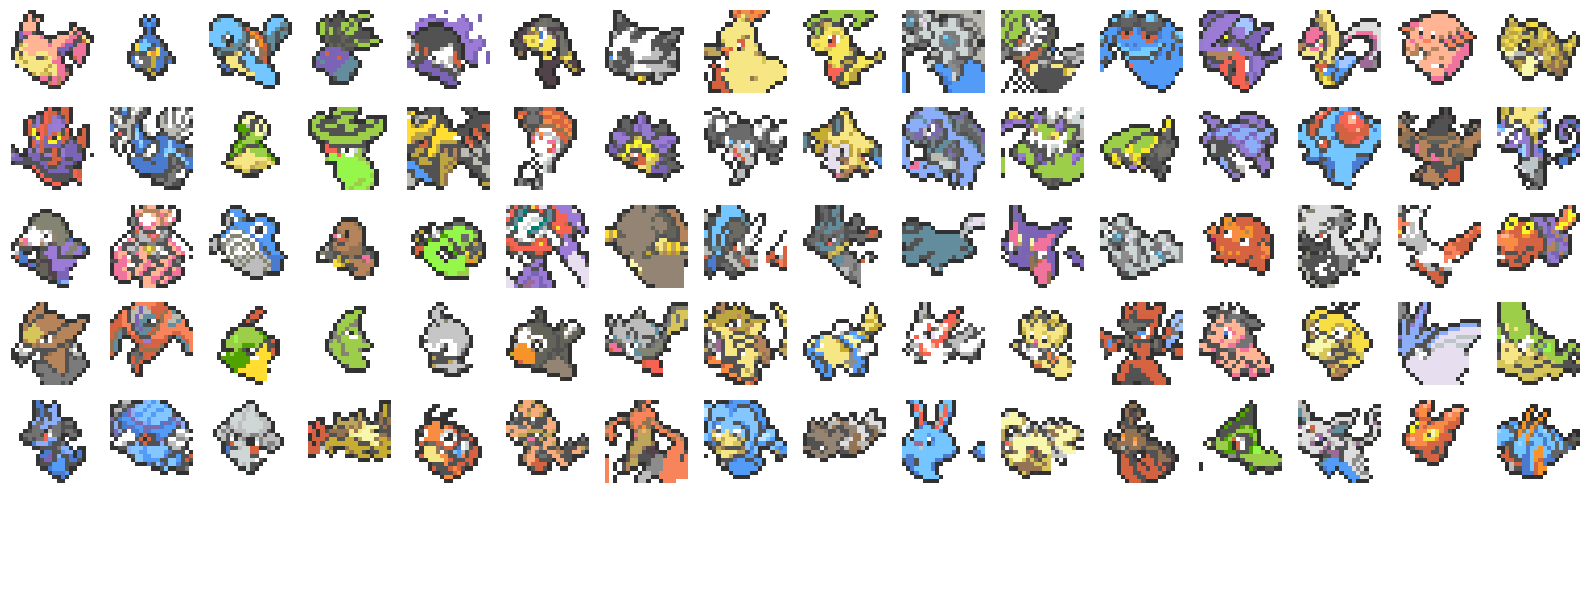

Training Epoch 53/100: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


Epoch 53/100, Loss: 0.3979


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Epoch 53/100, Reconstruction Accuracy: 0.3706
Model saved at checkpoints/best_model.pth (Loss: 0.3979, Epoch: 53)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.74s/it]


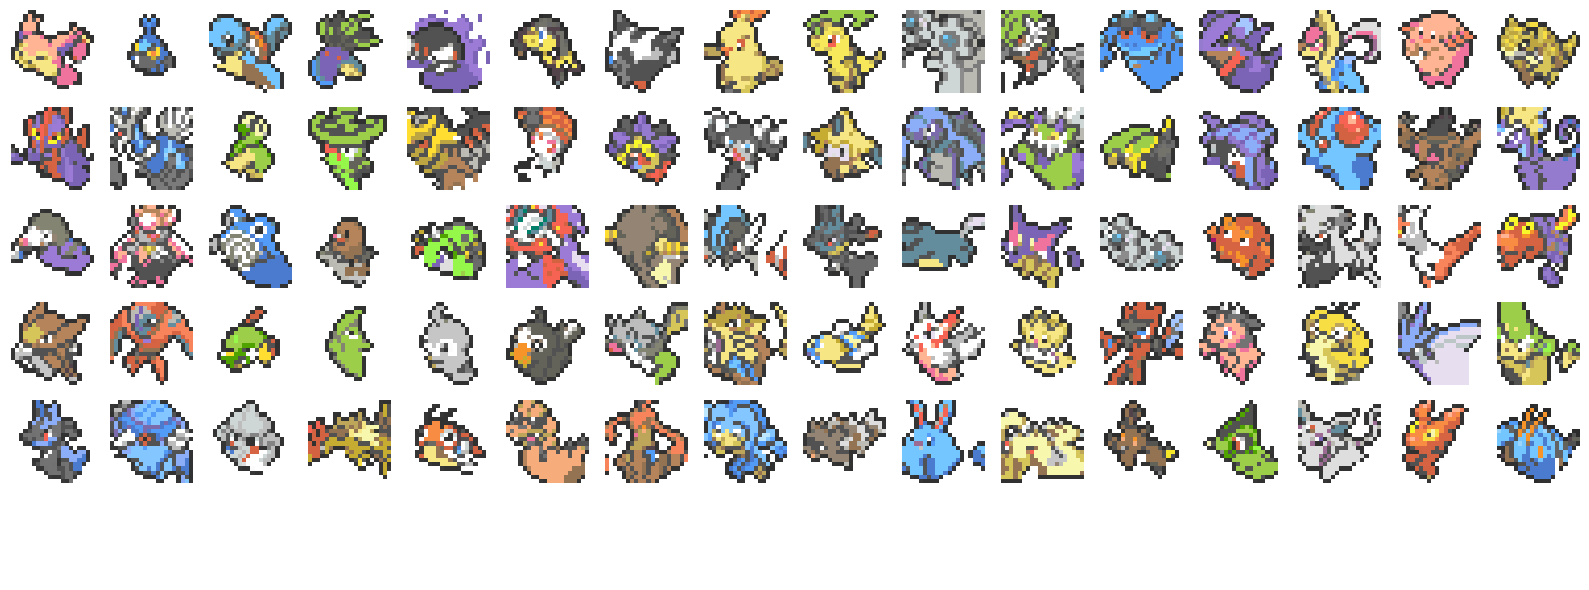

Training Epoch 54/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 54/100, Loss: 0.4037


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 54/100, Reconstruction Accuracy: 0.3869


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


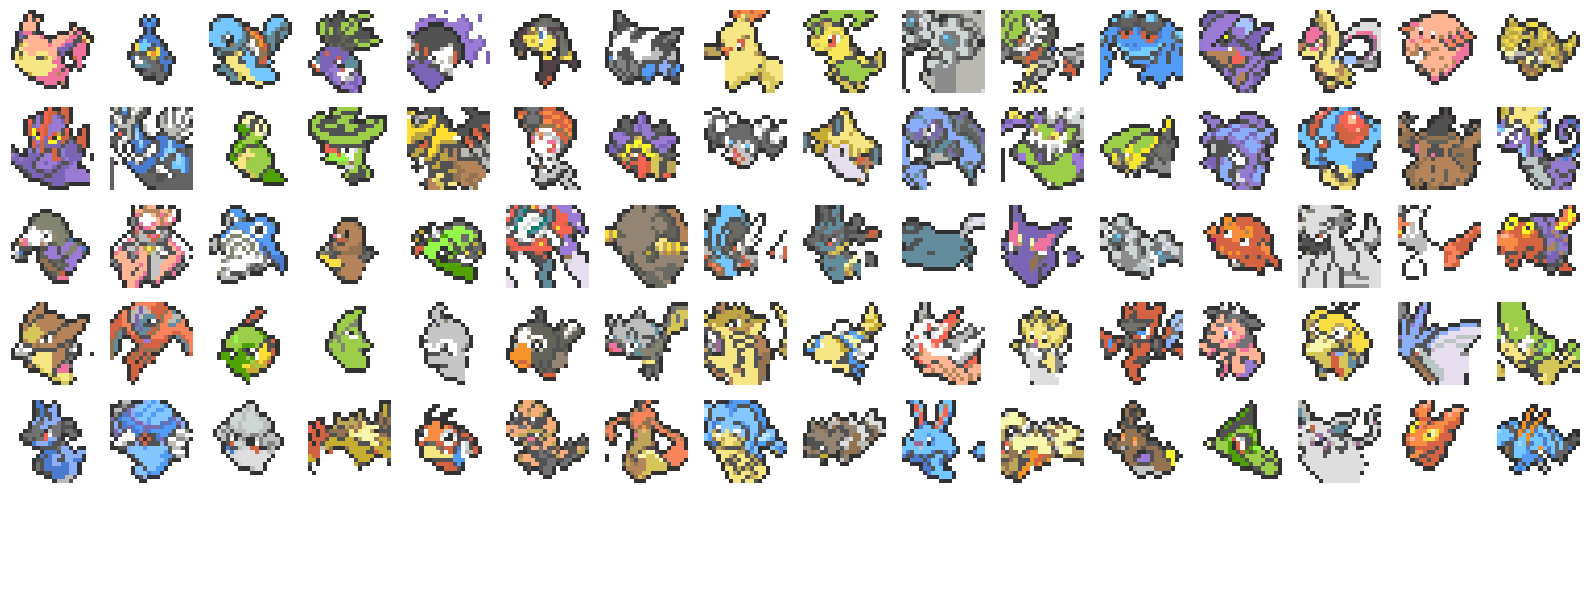

Training Epoch 55/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 55/100, Loss: 0.3888


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Epoch 55/100, Reconstruction Accuracy: 0.3818
Model saved at checkpoints/best_model.pth (Loss: 0.3888, Epoch: 55)


Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.84s/it]


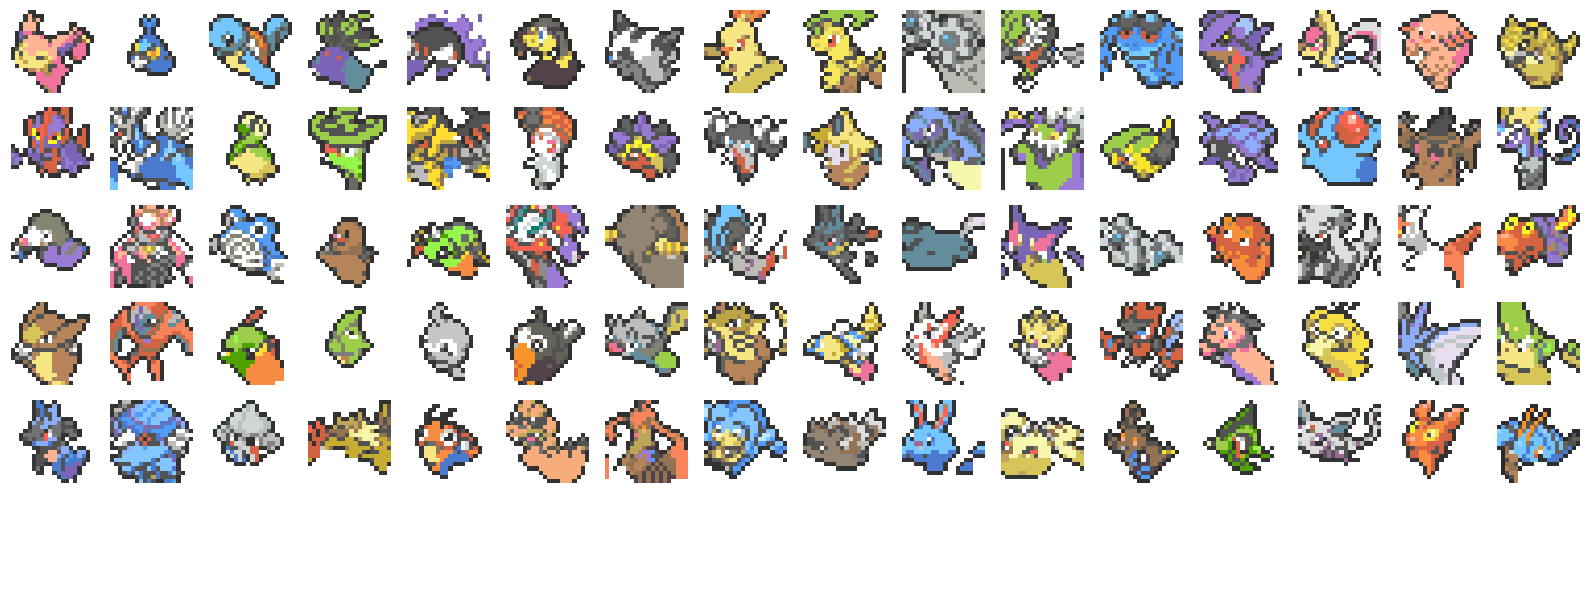

Training Epoch 56/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 56/100, Loss: 0.3789


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.81s/it]


Epoch 56/100, Reconstruction Accuracy: 0.3831
Model saved at checkpoints/best_model.pth (Loss: 0.3789, Epoch: 56)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


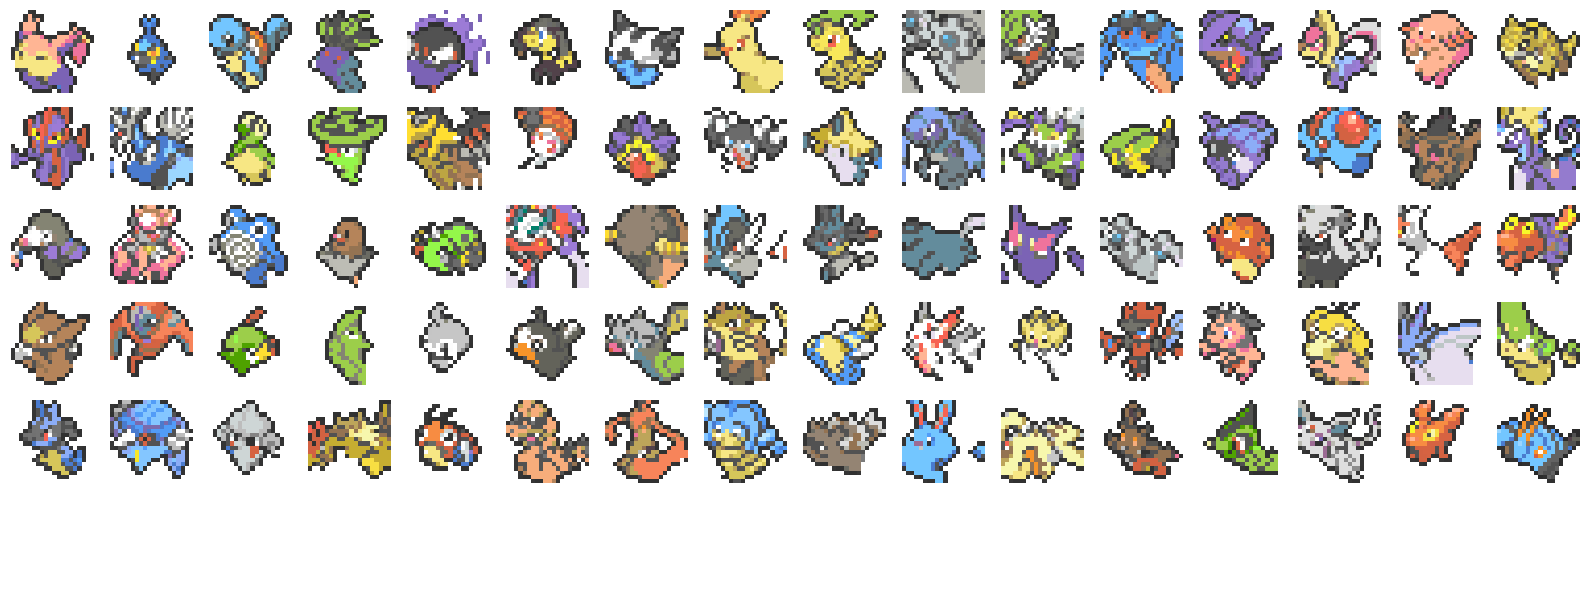

Training Epoch 57/100: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


Epoch 57/100, Loss: 0.3700


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Epoch 57/100, Reconstruction Accuracy: 0.3734
Model saved at checkpoints/best_model.pth (Loss: 0.3700, Epoch: 57)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


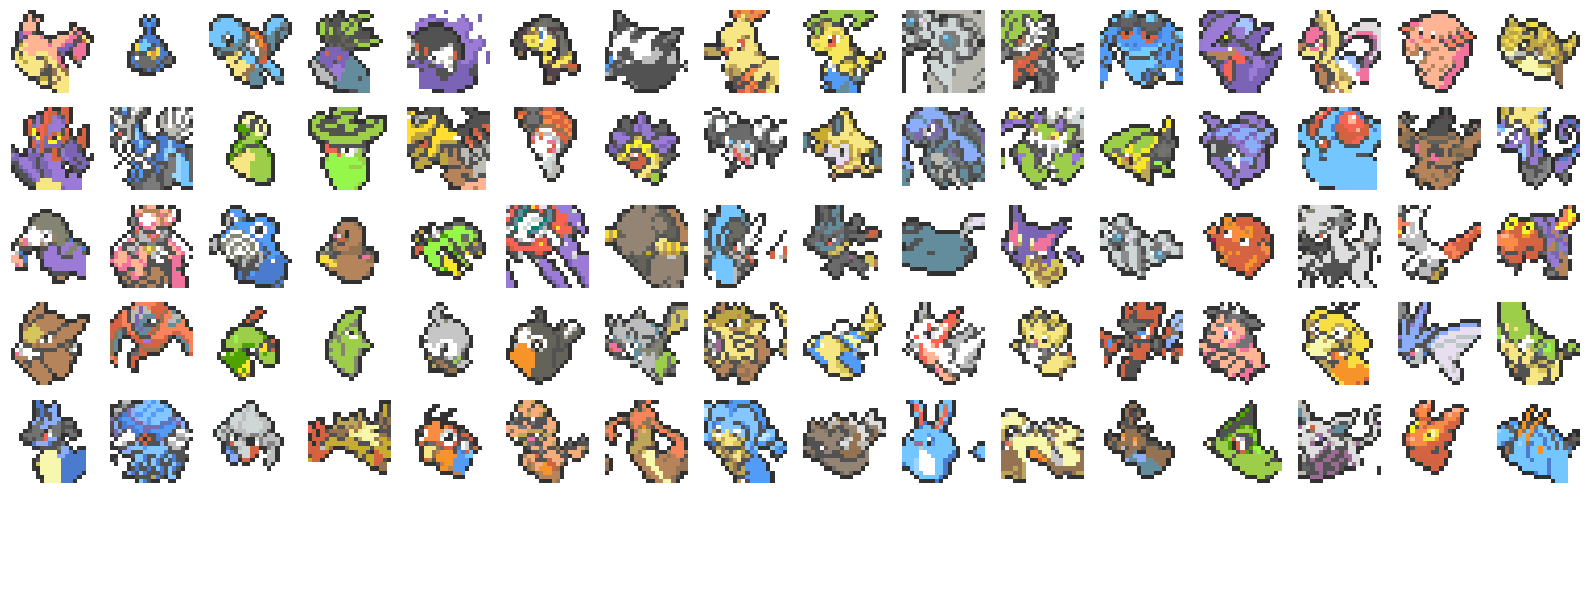

Training Epoch 58/100: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


Epoch 58/100, Loss: 0.3593


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.75s/it]


Epoch 58/100, Reconstruction Accuracy: 0.3936
Model saved at checkpoints/best_model.pth (Loss: 0.3593, Epoch: 58)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


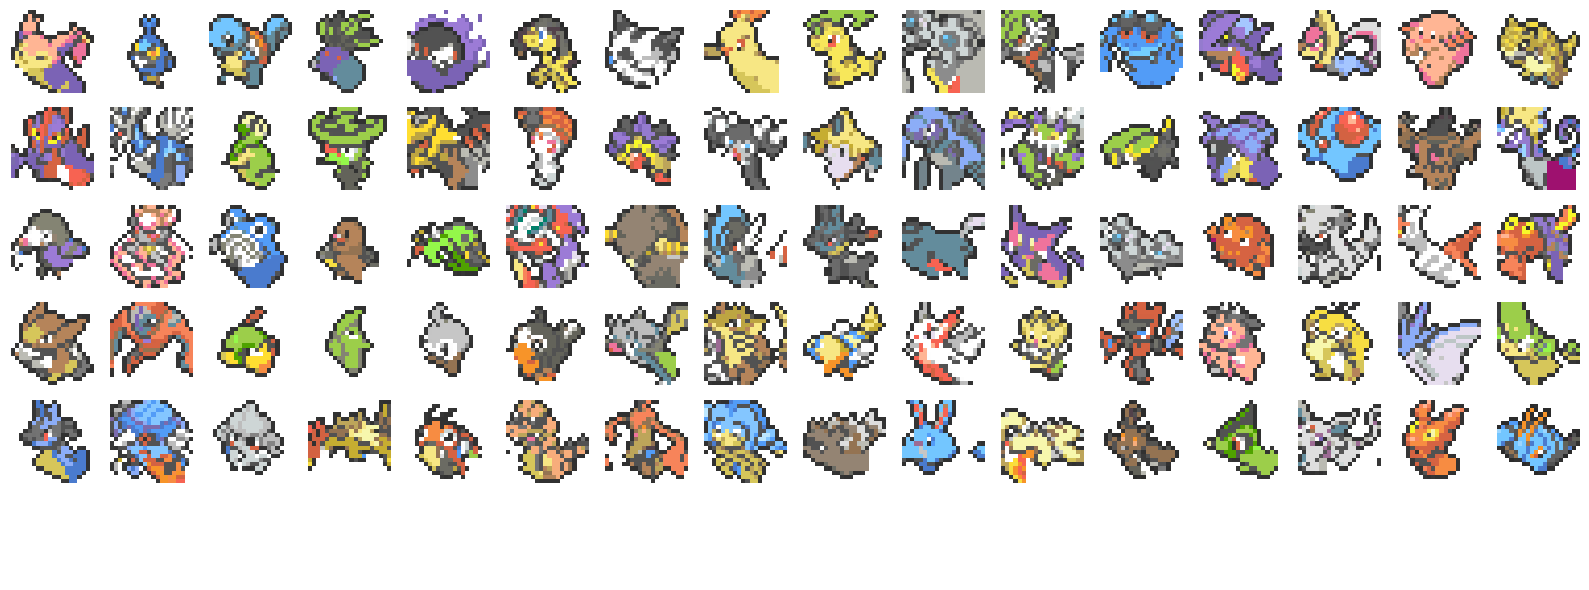

Training Epoch 59/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 59/100, Loss: 0.3590


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 59/100, Reconstruction Accuracy: 0.3931
Model saved at checkpoints/best_model.pth (Loss: 0.3590, Epoch: 59)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.75s/it]


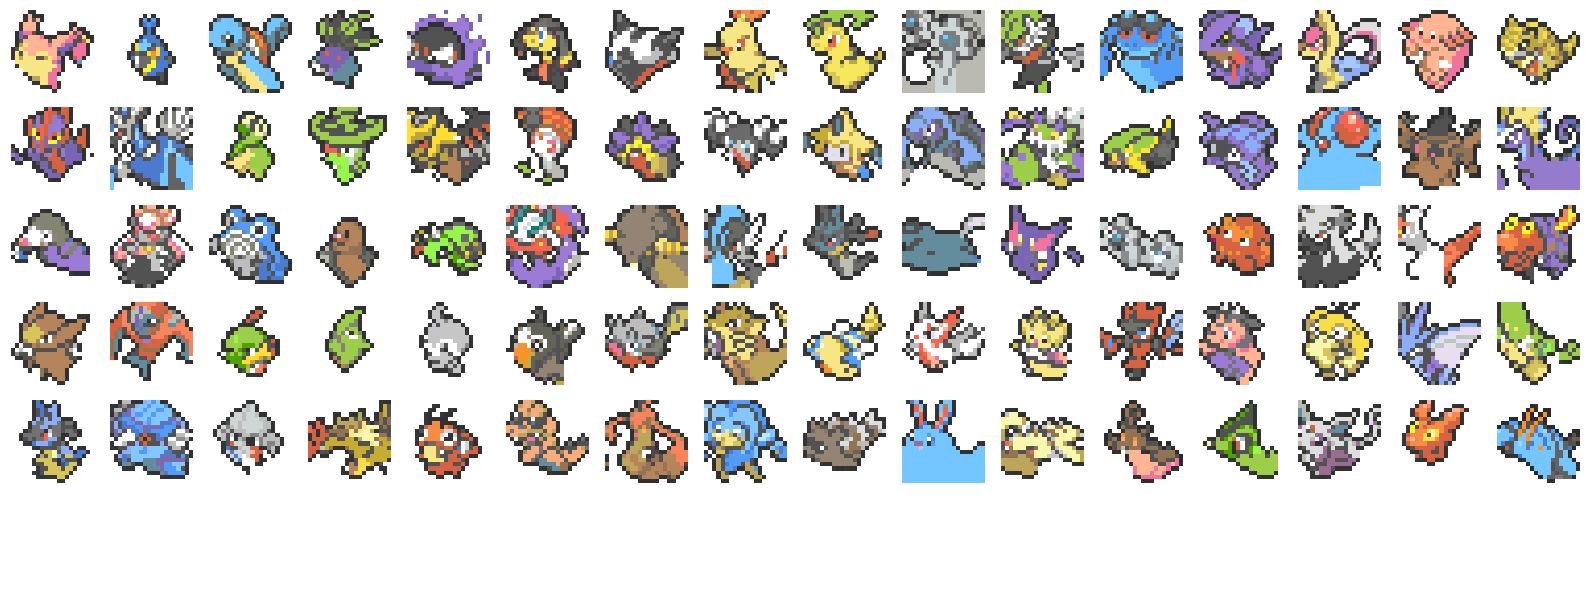

Training Epoch 60/100: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


Epoch 60/100, Loss: 0.3379


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


Epoch 60/100, Reconstruction Accuracy: 0.3659
Model saved at checkpoints/best_model.pth (Loss: 0.3379, Epoch: 60)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


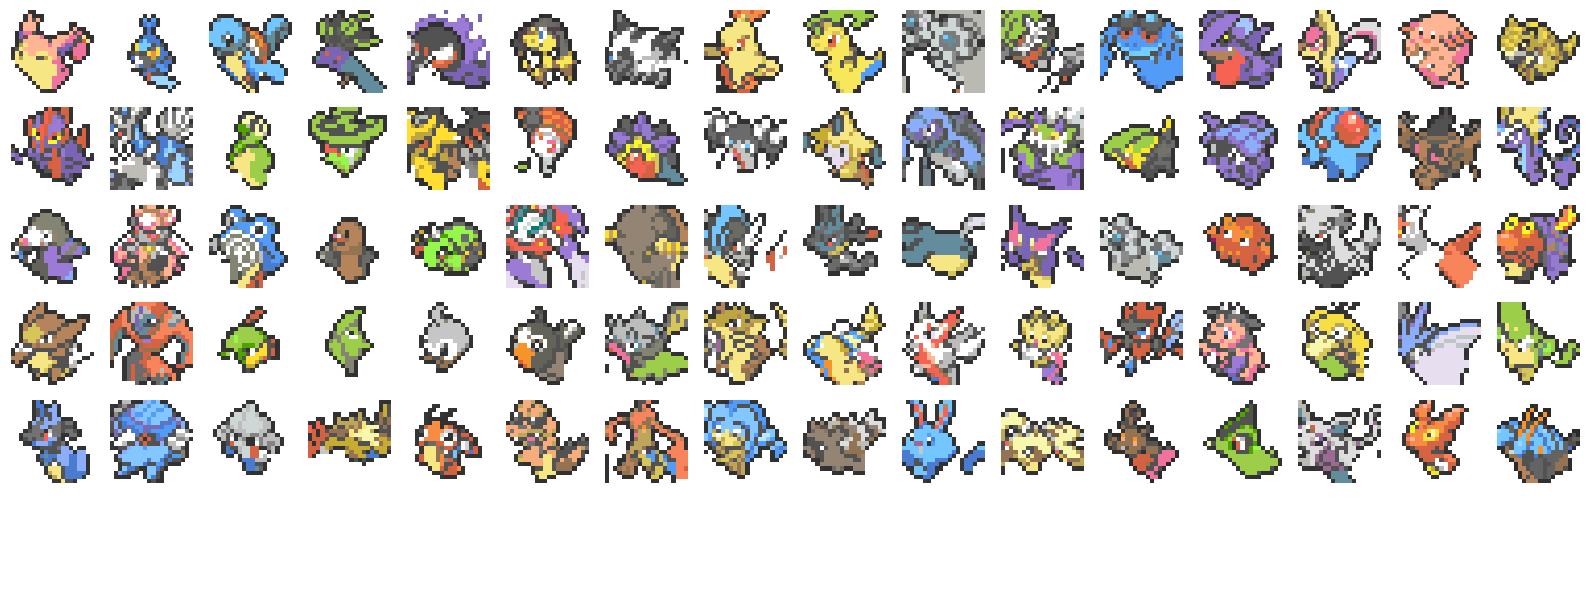

Training Epoch 61/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 61/100, Loss: 0.3425


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.75s/it]


Epoch 61/100, Reconstruction Accuracy: 0.3897


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.80s/it]


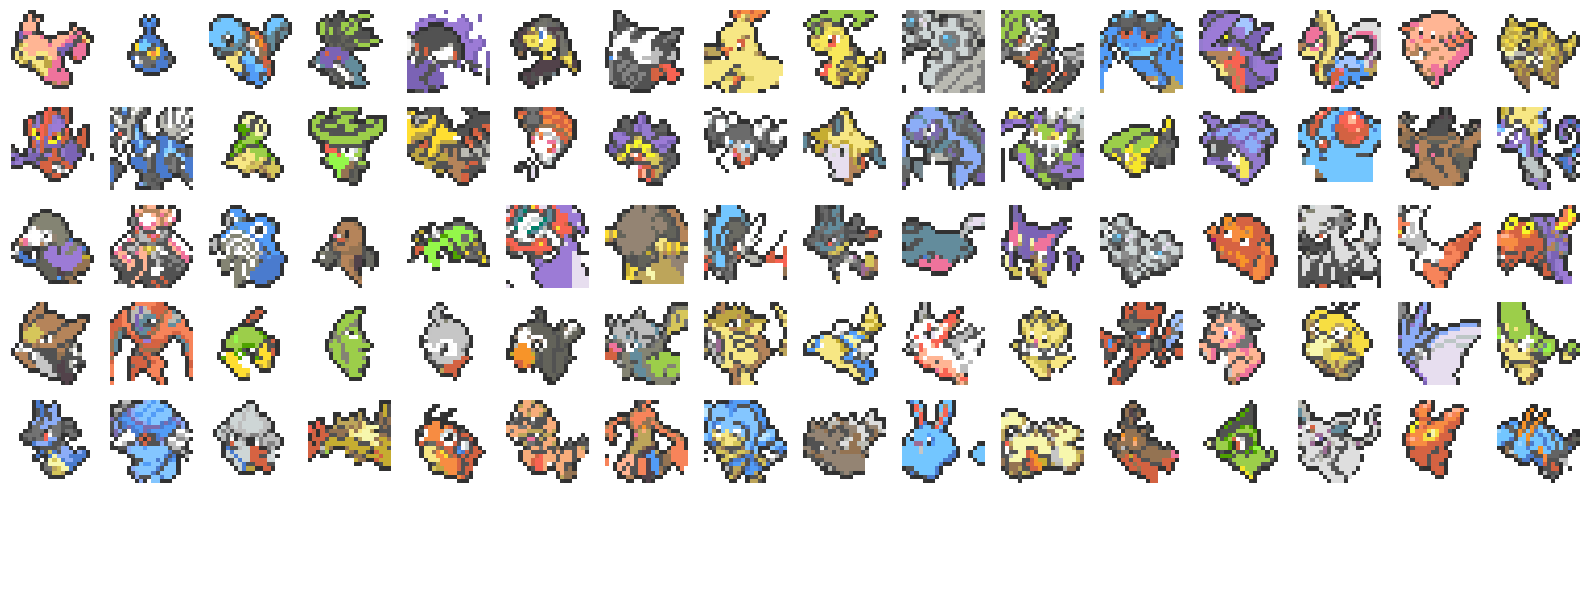

Training Epoch 62/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 62/100, Loss: 0.3408


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Epoch 62/100, Reconstruction Accuracy: 0.3920


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


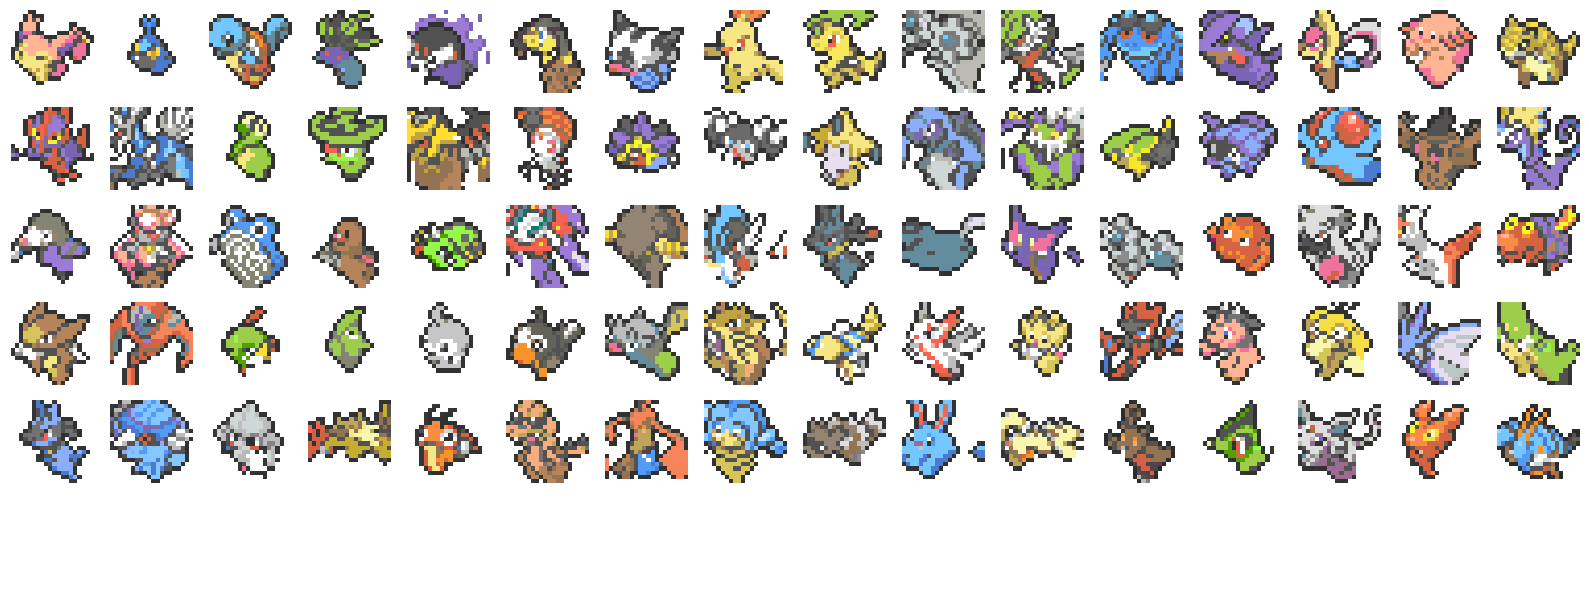

Training Epoch 63/100: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


Epoch 63/100, Loss: 0.3354


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 63/100, Reconstruction Accuracy: 0.3855
Model saved at checkpoints/best_model.pth (Loss: 0.3354, Epoch: 63)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


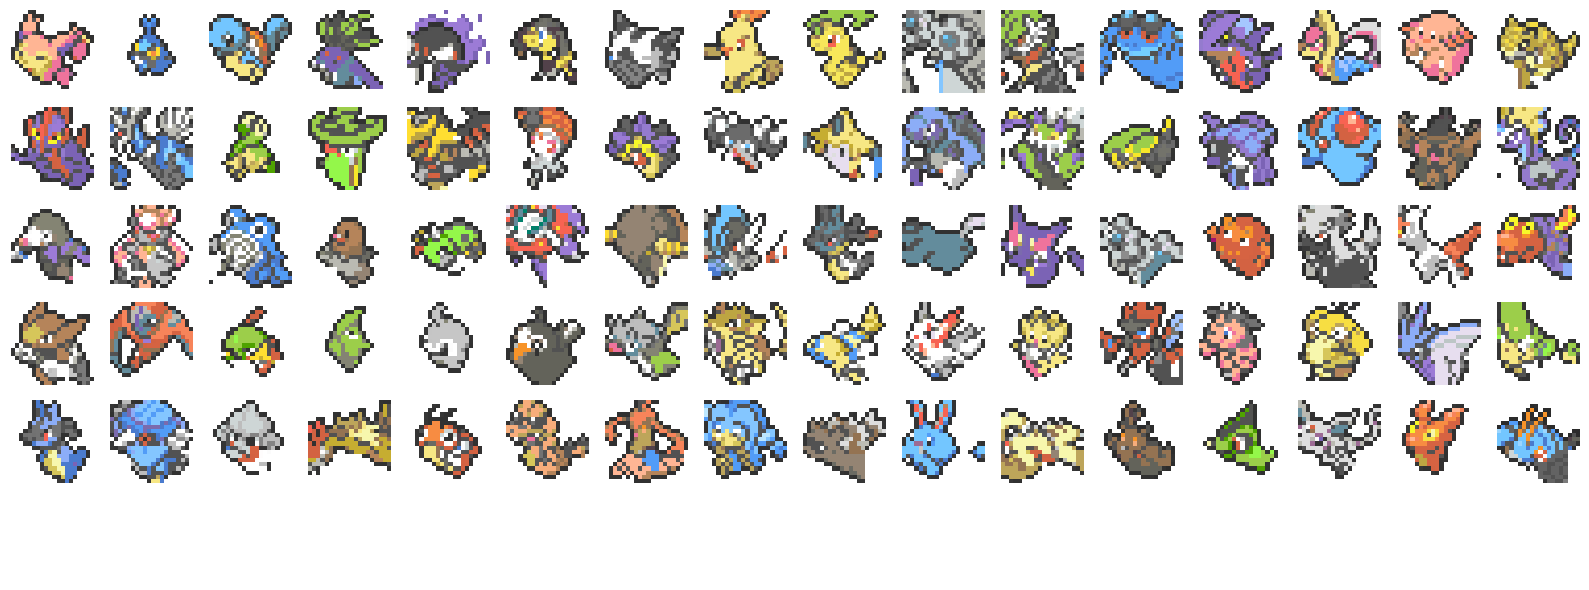

Training Epoch 64/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 64/100, Loss: 0.3242


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 64/100, Reconstruction Accuracy: 0.3801
Model saved at checkpoints/best_model.pth (Loss: 0.3242, Epoch: 64)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


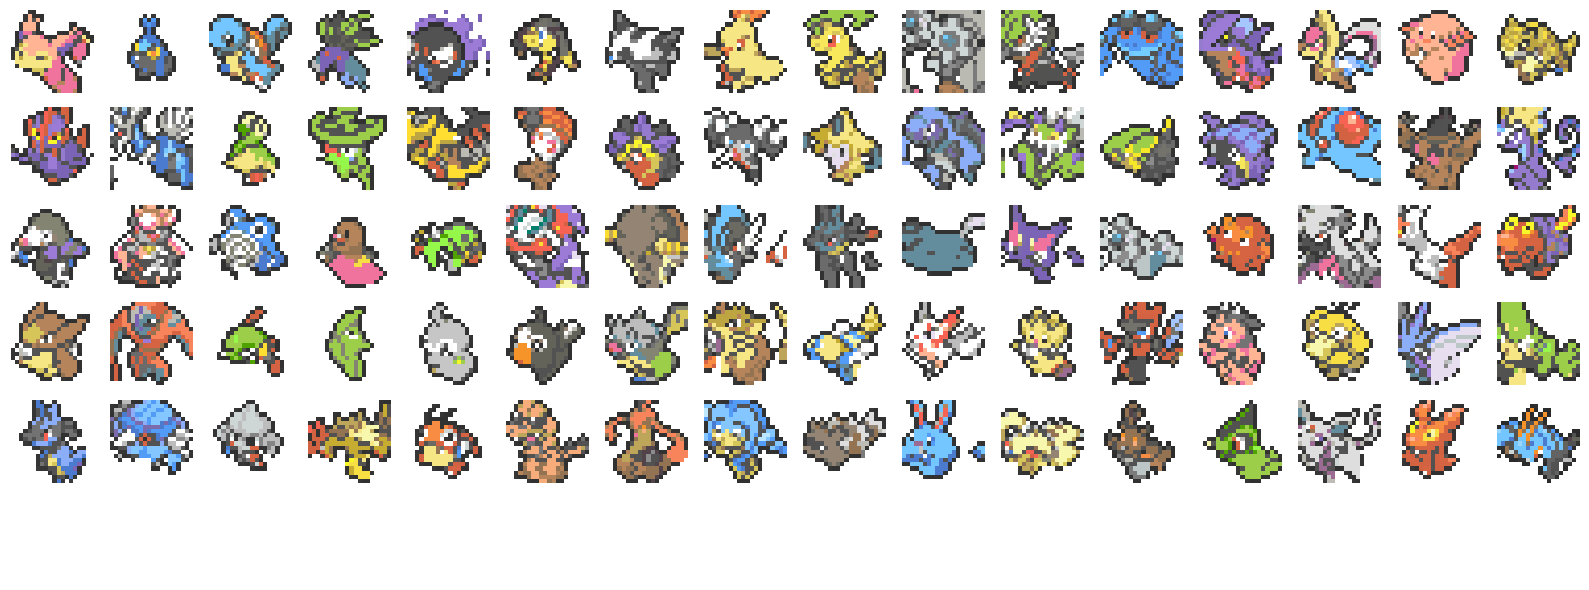

Training Epoch 65/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 65/100, Loss: 0.3266


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 65/100, Reconstruction Accuracy: 0.3993


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


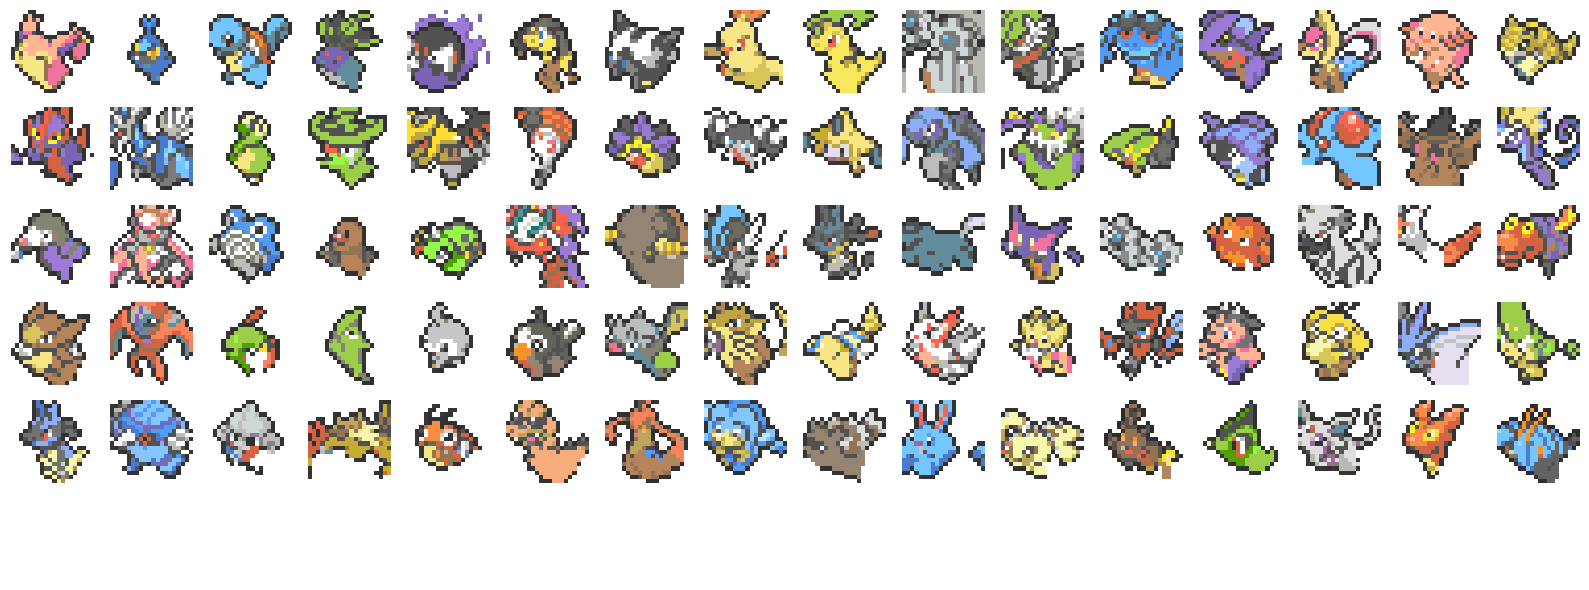

Training Epoch 66/100: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


Epoch 66/100, Loss: 0.3052


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 66/100, Reconstruction Accuracy: 0.3923
Model saved at checkpoints/best_model.pth (Loss: 0.3052, Epoch: 66)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.74s/it]


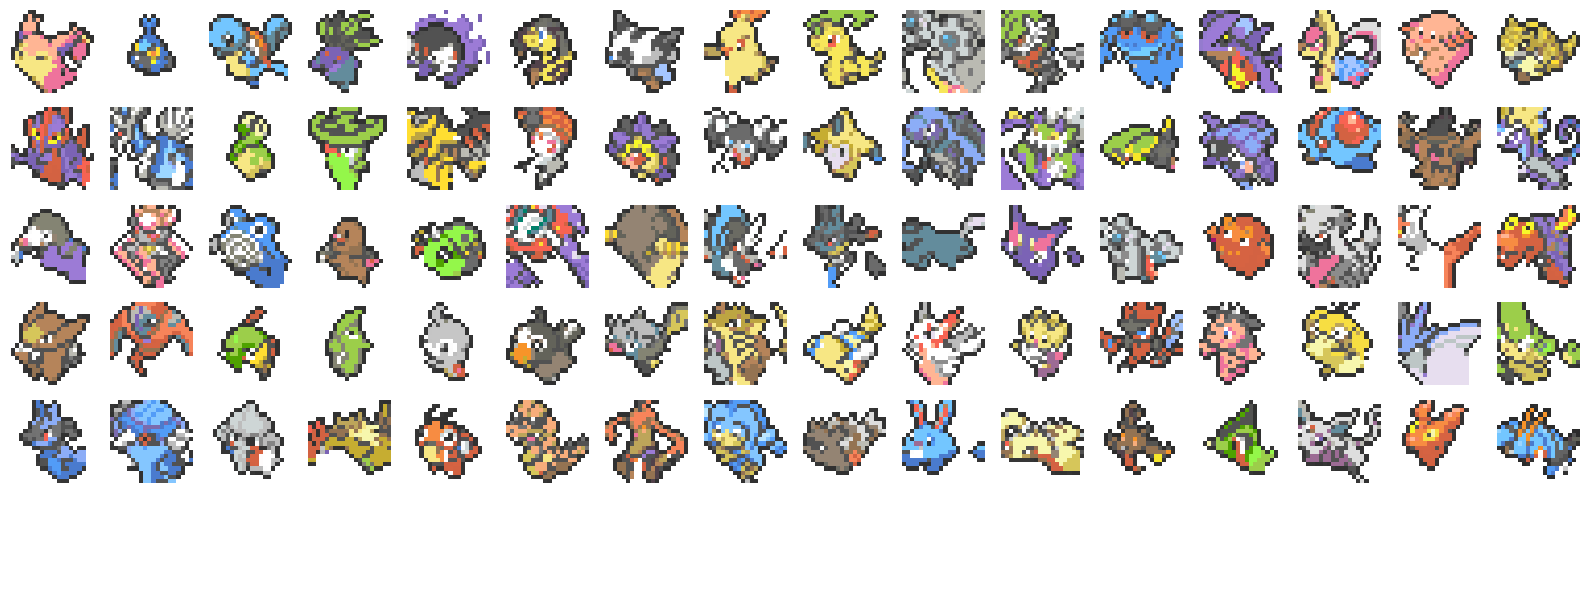

Training Epoch 67/100: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


Epoch 67/100, Loss: 0.3038


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 67/100, Reconstruction Accuracy: 0.3873
Model saved at checkpoints/best_model.pth (Loss: 0.3038, Epoch: 67)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.75s/it]


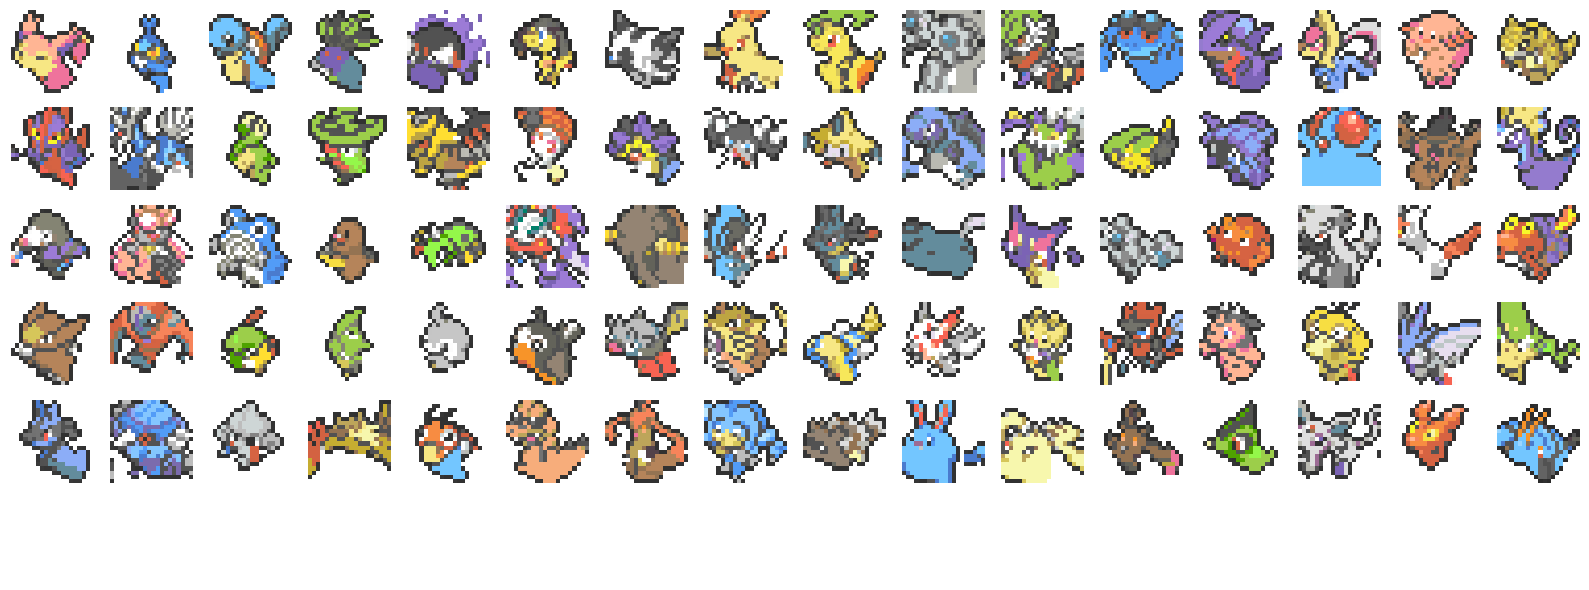

Training Epoch 68/100: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


Epoch 68/100, Loss: 0.2962


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


Epoch 68/100, Reconstruction Accuracy: 0.3796
Model saved at checkpoints/best_model.pth (Loss: 0.2962, Epoch: 68)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


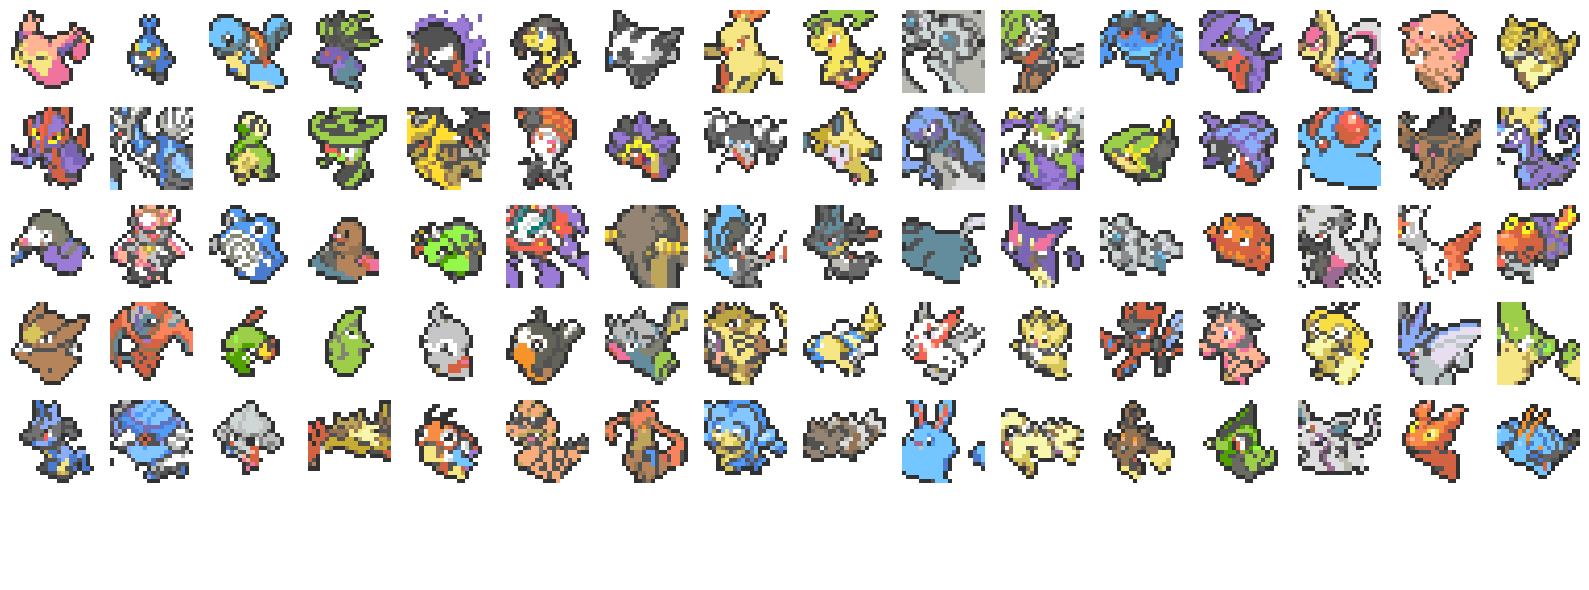

Training Epoch 69/100: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


Epoch 69/100, Loss: 0.2991


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.81s/it]


Epoch 69/100, Reconstruction Accuracy: 0.3938


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


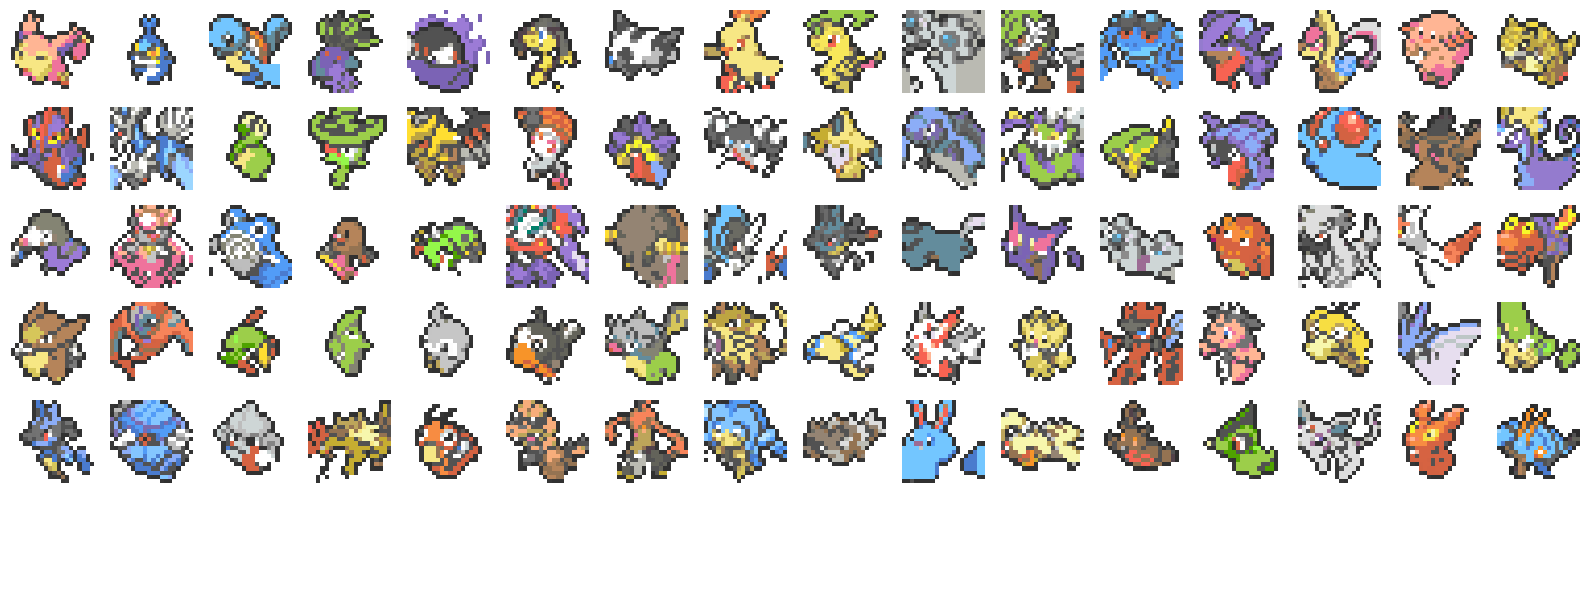

Training Epoch 70/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 70/100, Loss: 0.2969


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 70/100, Reconstruction Accuracy: 0.3959


Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.80s/it]


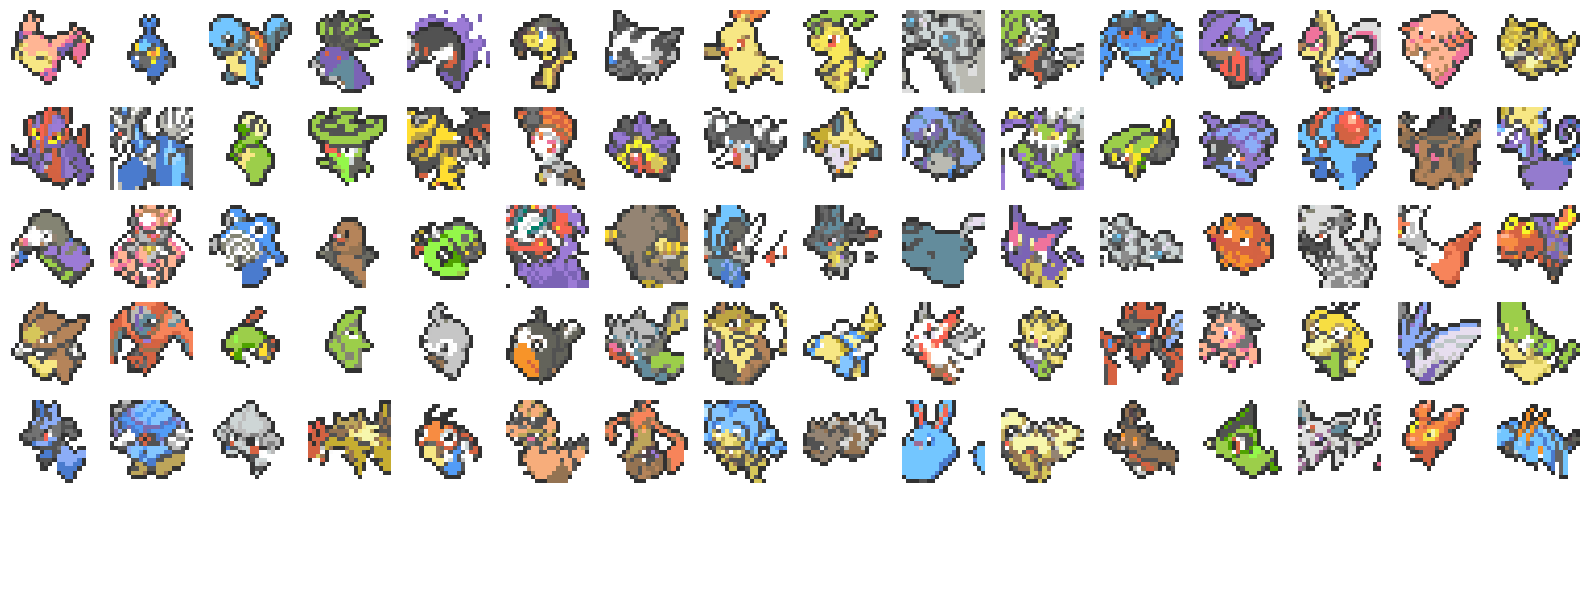

Training Epoch 71/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 71/100, Loss: 0.2951


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 71/100, Reconstruction Accuracy: 0.3821
Model saved at checkpoints/best_model.pth (Loss: 0.2951, Epoch: 71)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


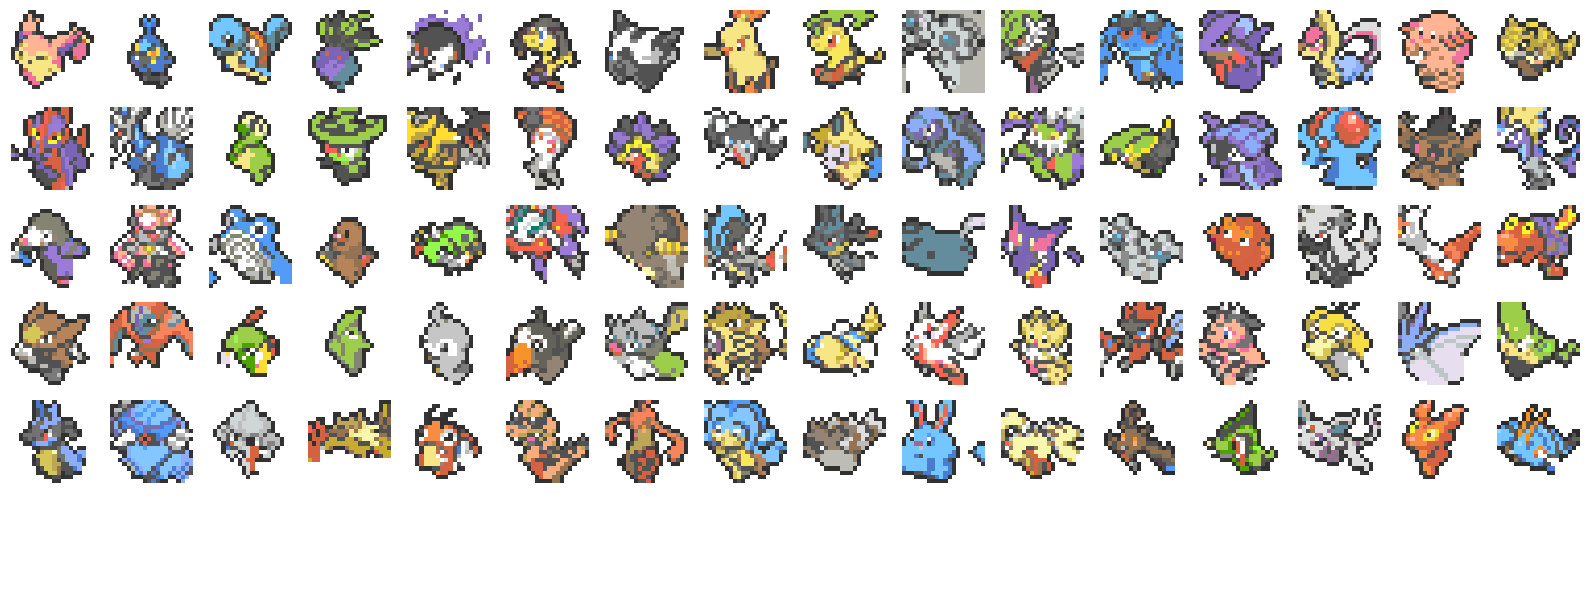

Training Epoch 72/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 72/100, Loss: 0.2847


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.80s/it]


Epoch 72/100, Reconstruction Accuracy: 0.3787
Model saved at checkpoints/best_model.pth (Loss: 0.2847, Epoch: 72)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


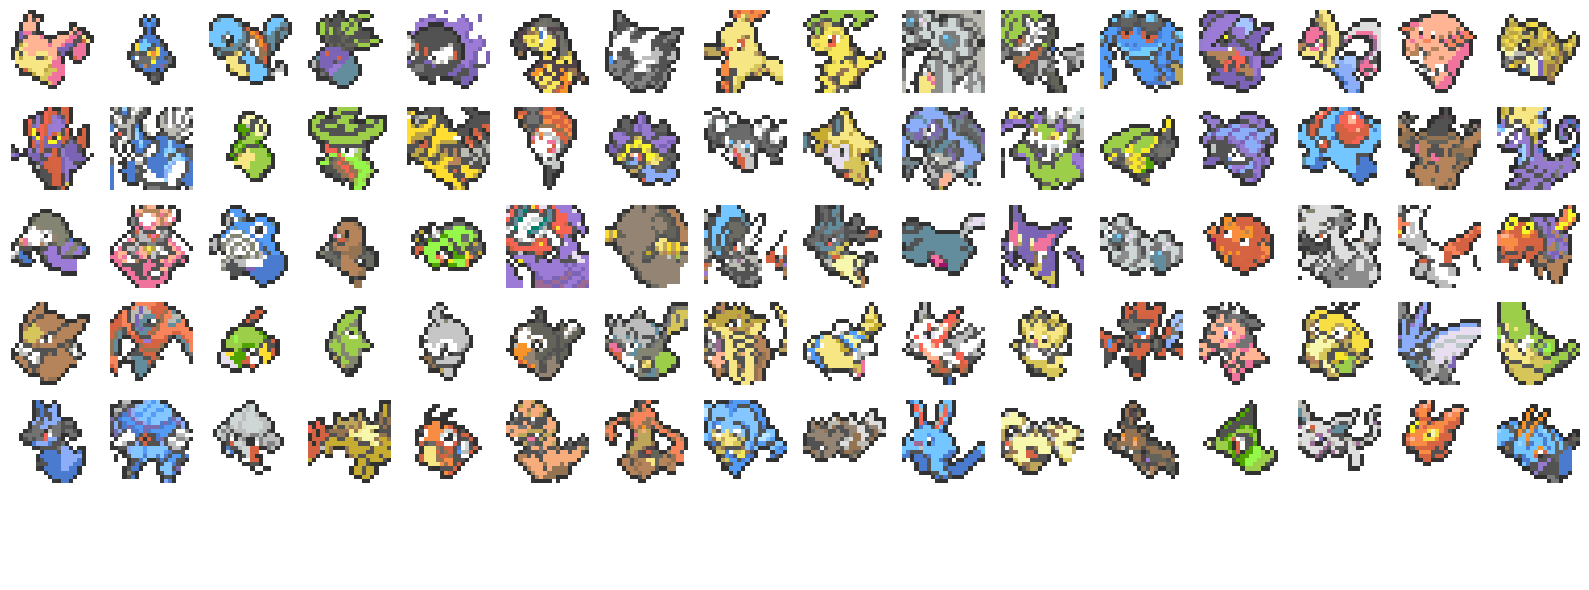

Training Epoch 73/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 73/100, Loss: 0.2943


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 73/100, Reconstruction Accuracy: 0.3870


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


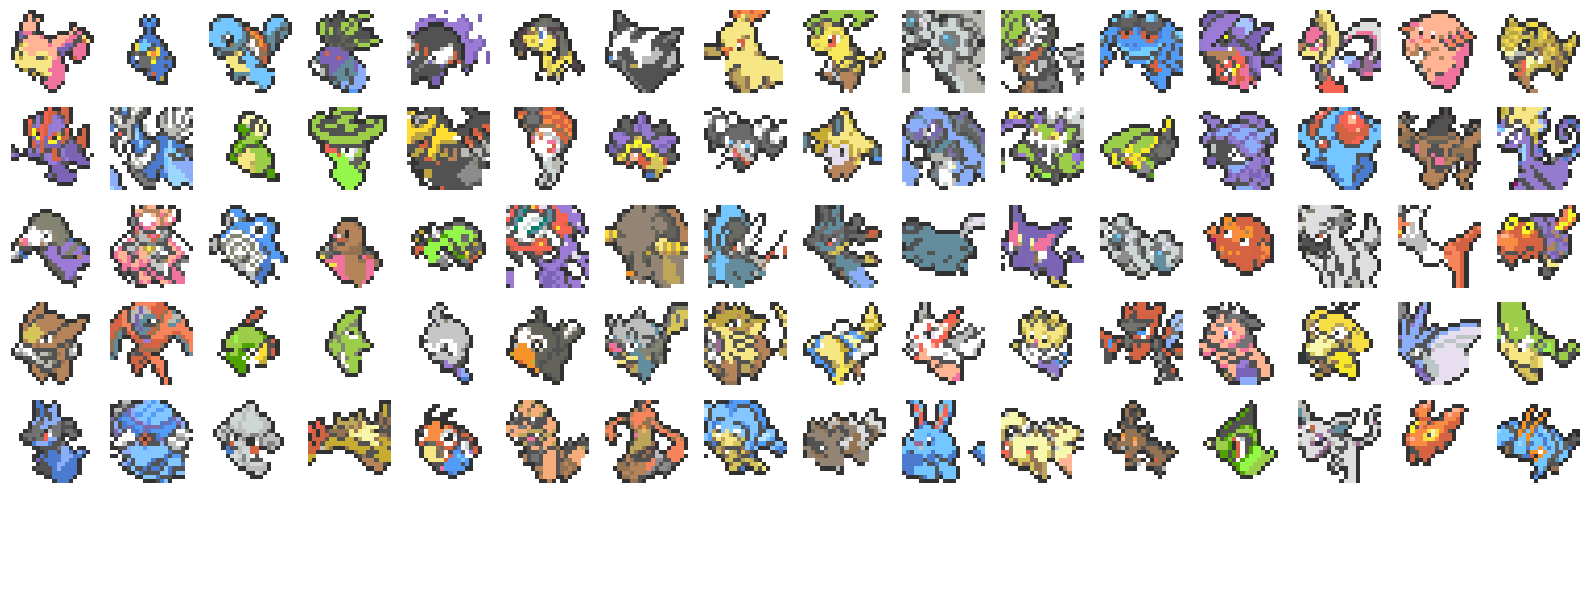

Training Epoch 74/100: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


Epoch 74/100, Loss: 0.2970


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.80s/it]


Epoch 74/100, Reconstruction Accuracy: 0.3820


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


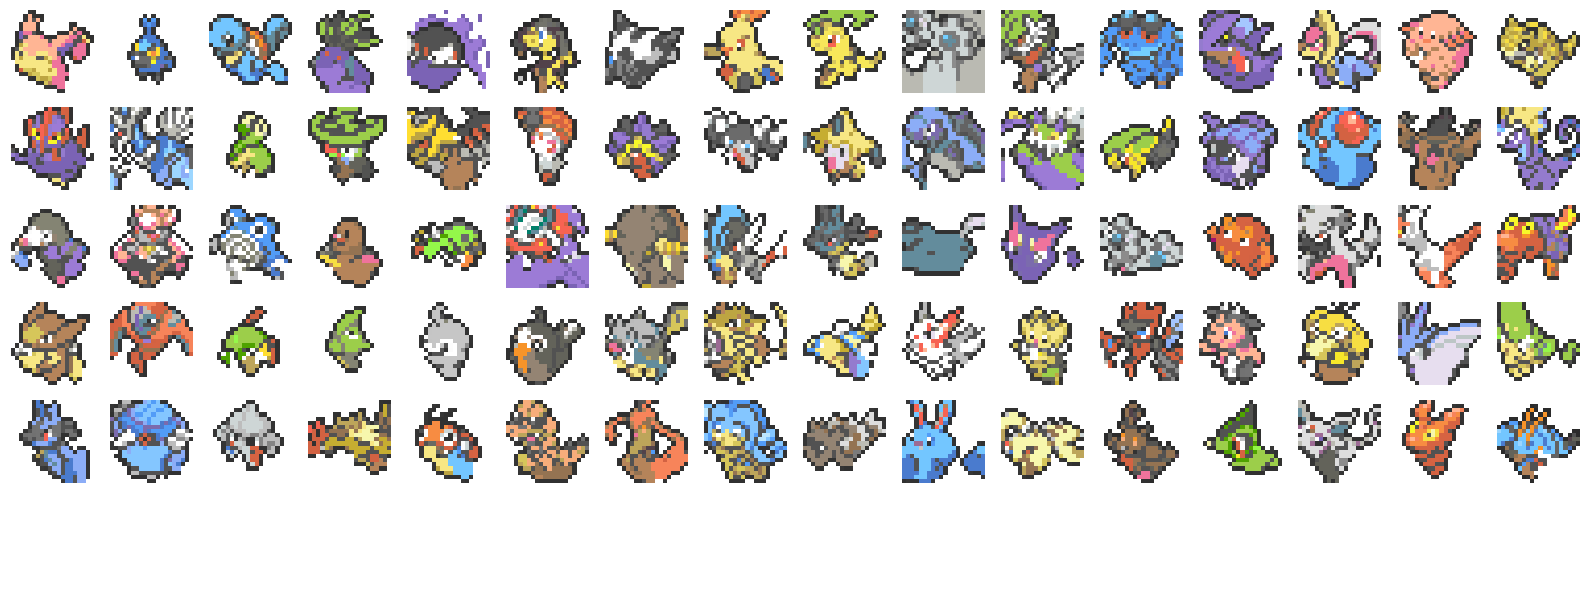

Training Epoch 75/100: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


Epoch 75/100, Loss: 0.2766


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.80s/it]


Epoch 75/100, Reconstruction Accuracy: 0.3873
Model saved at checkpoints/best_model.pth (Loss: 0.2766, Epoch: 75)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


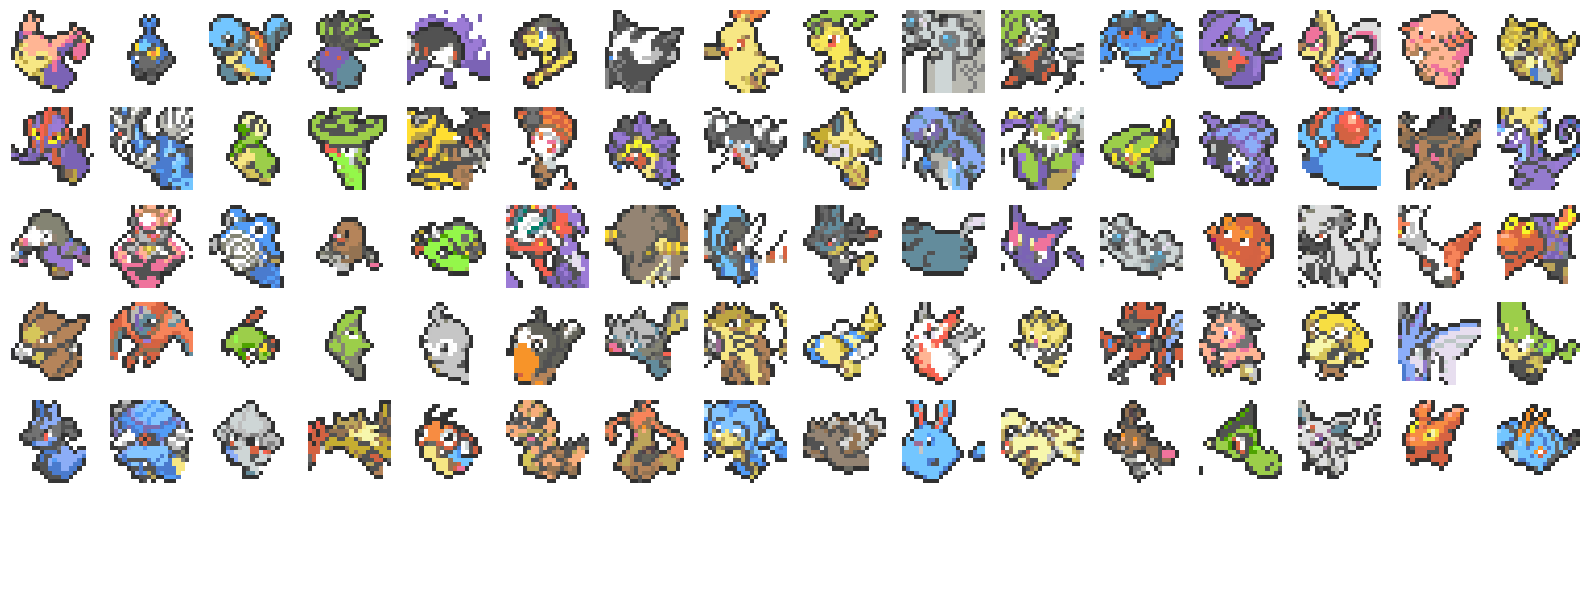

Training Epoch 76/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 76/100, Loss: 0.2934


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 76/100, Reconstruction Accuracy: 0.3932


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


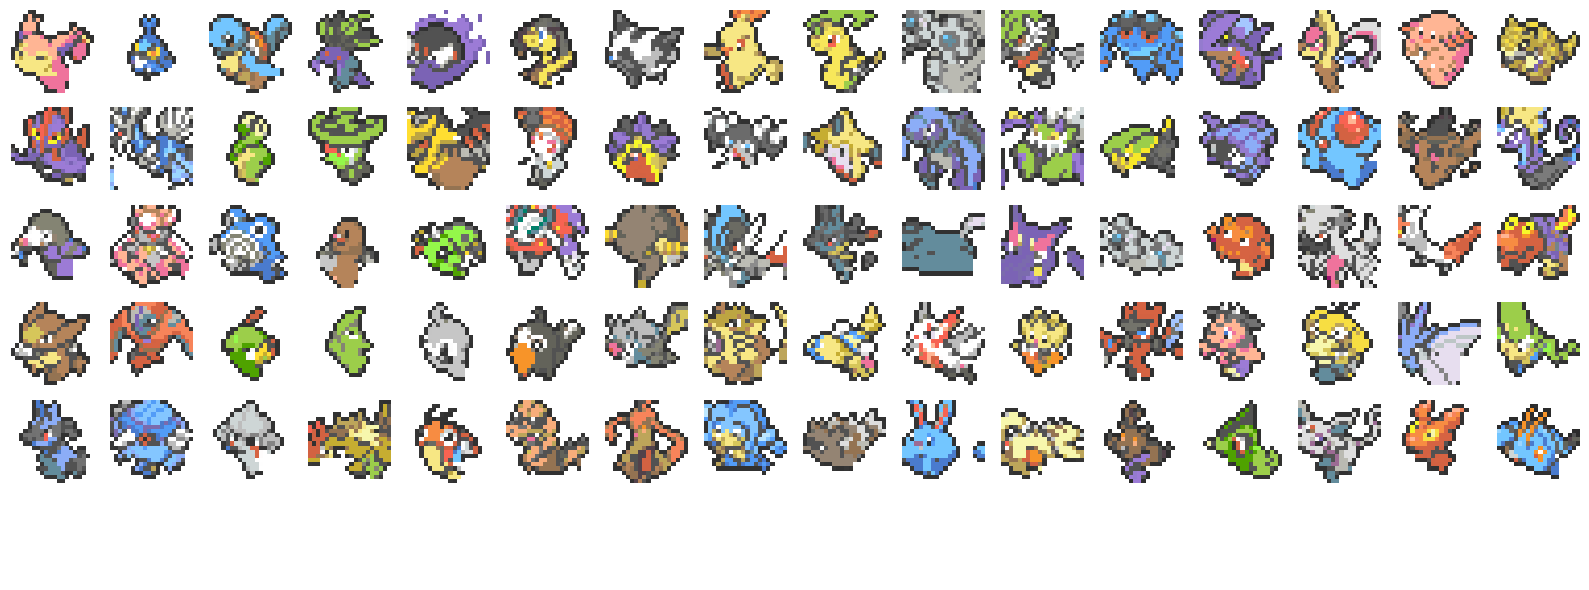

Training Epoch 77/100: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


Epoch 77/100, Loss: 0.2880


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 77/100, Reconstruction Accuracy: 0.3930


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


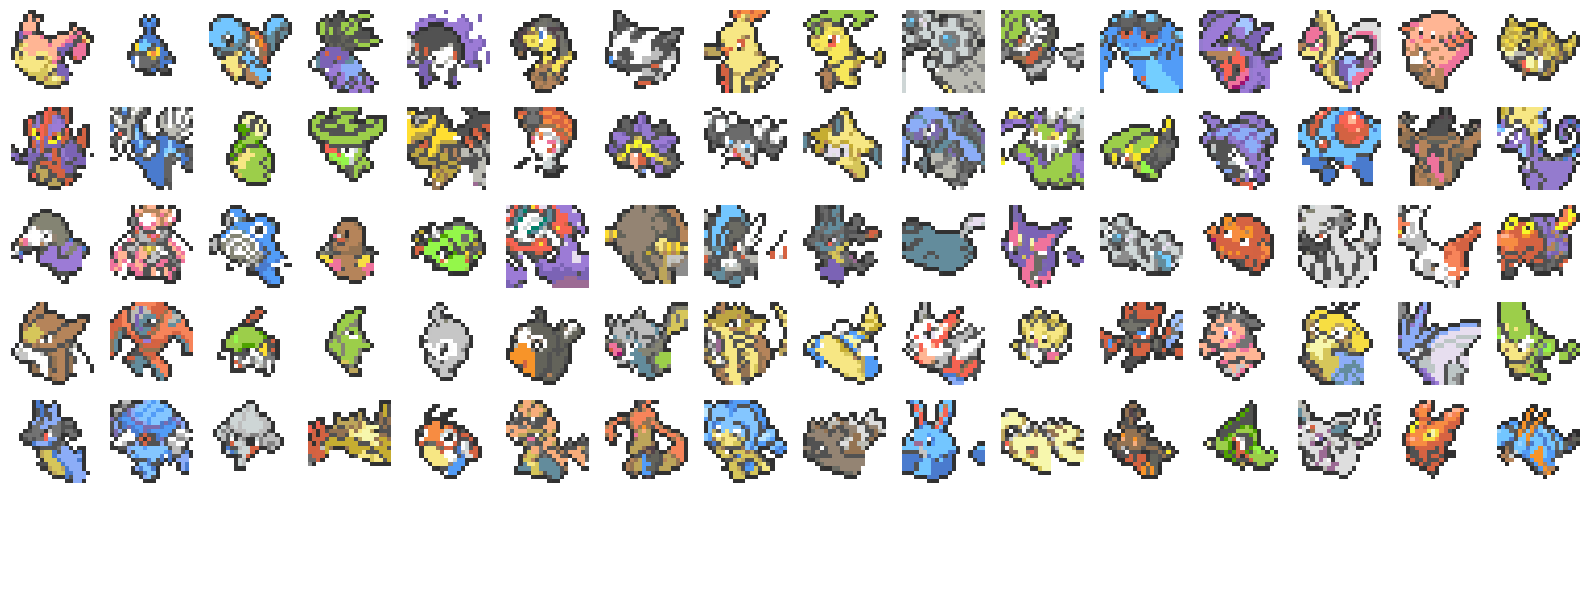

Training Epoch 78/100: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


Epoch 78/100, Loss: 0.2738


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 78/100, Reconstruction Accuracy: 0.3941
Model saved at checkpoints/best_model.pth (Loss: 0.2738, Epoch: 78)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


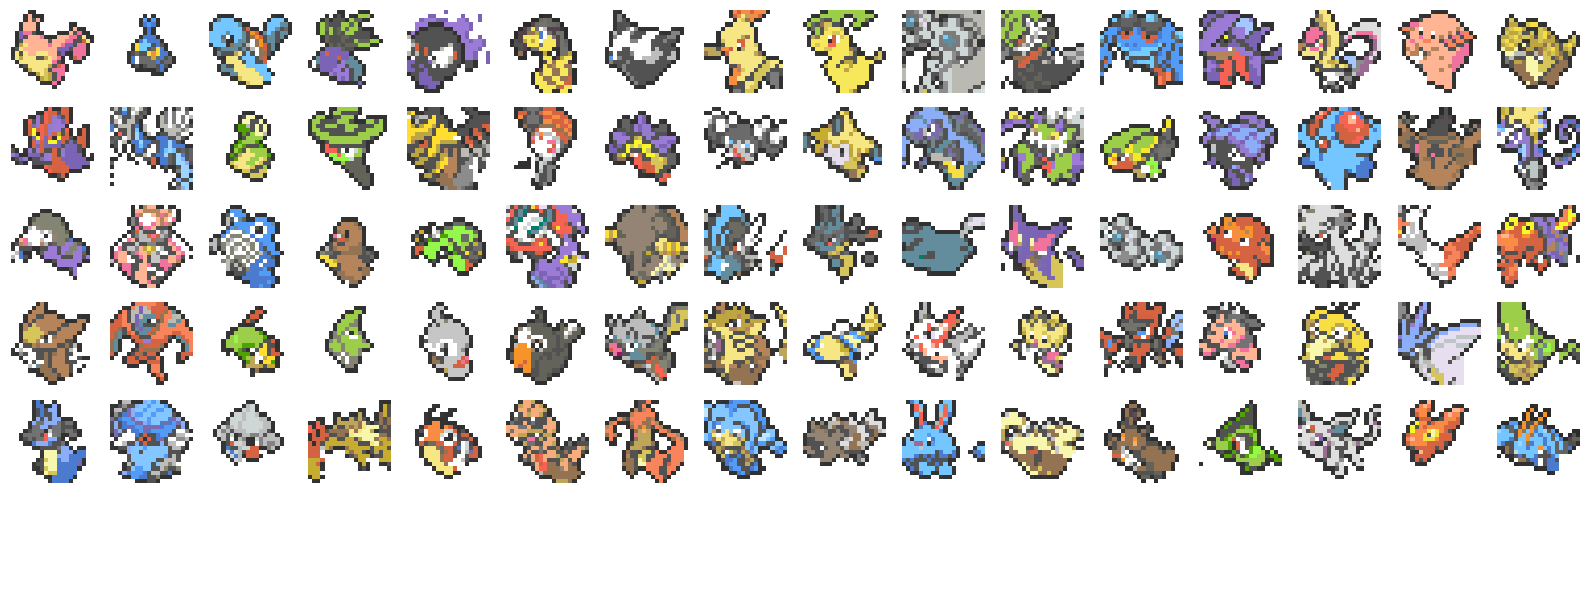

Training Epoch 79/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 79/100, Loss: 0.2751


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 79/100, Reconstruction Accuracy: 0.3939


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


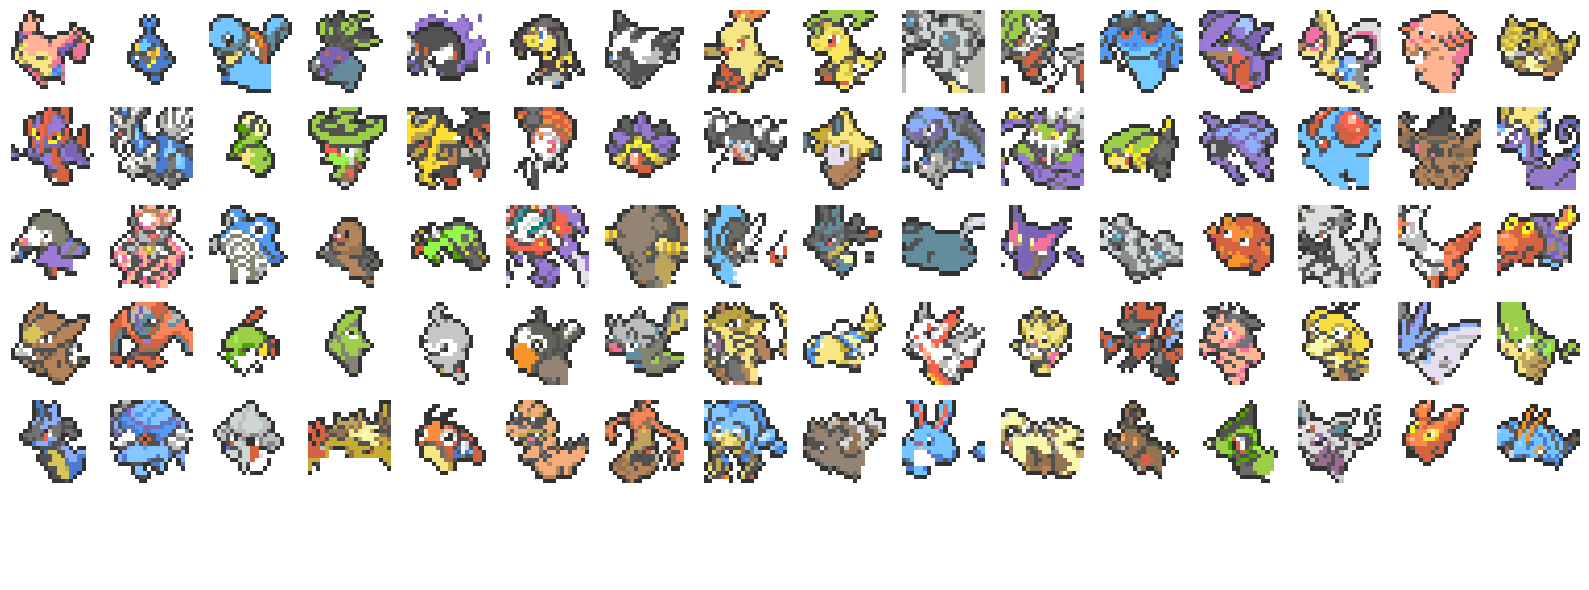

Training Epoch 80/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 80/100, Loss: 0.2725


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 80/100, Reconstruction Accuracy: 0.3957
Model saved at checkpoints/best_model.pth (Loss: 0.2725, Epoch: 80)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


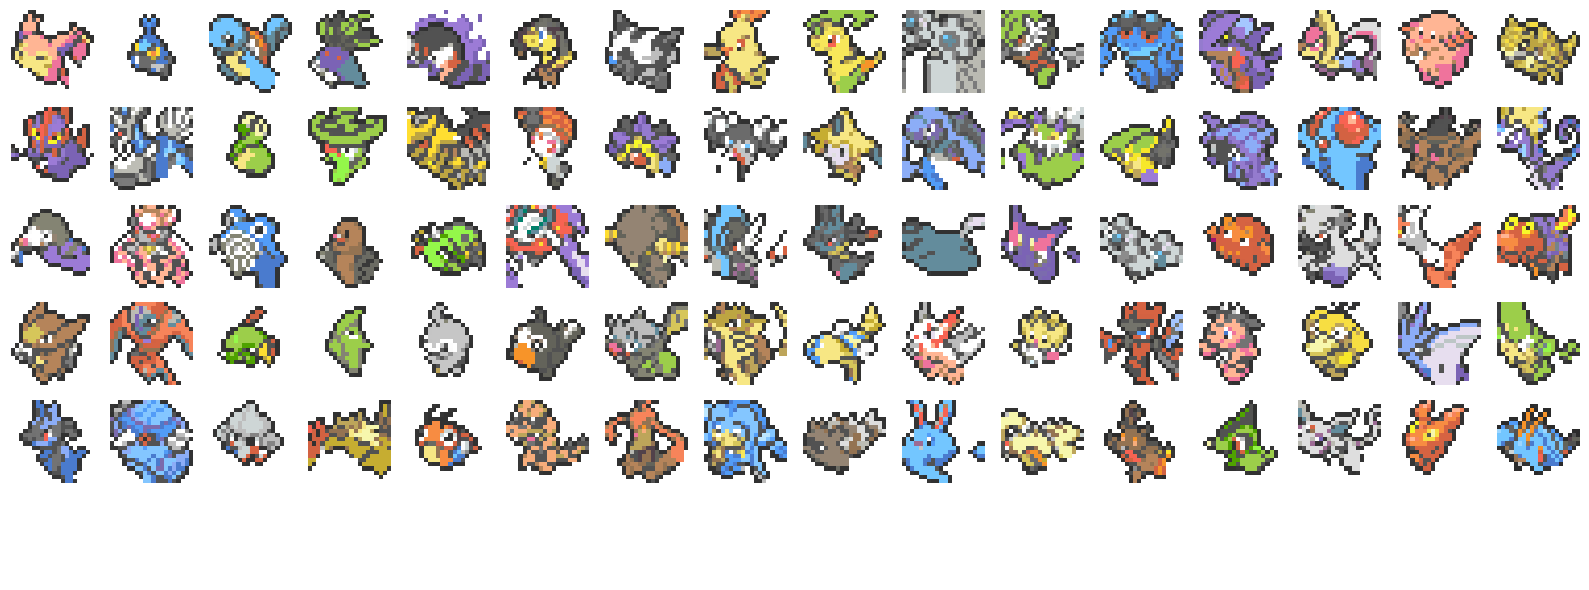

Training Epoch 81/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 81/100, Loss: 0.2717


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.80s/it]


Epoch 81/100, Reconstruction Accuracy: 0.3882
Model saved at checkpoints/best_model.pth (Loss: 0.2717, Epoch: 81)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


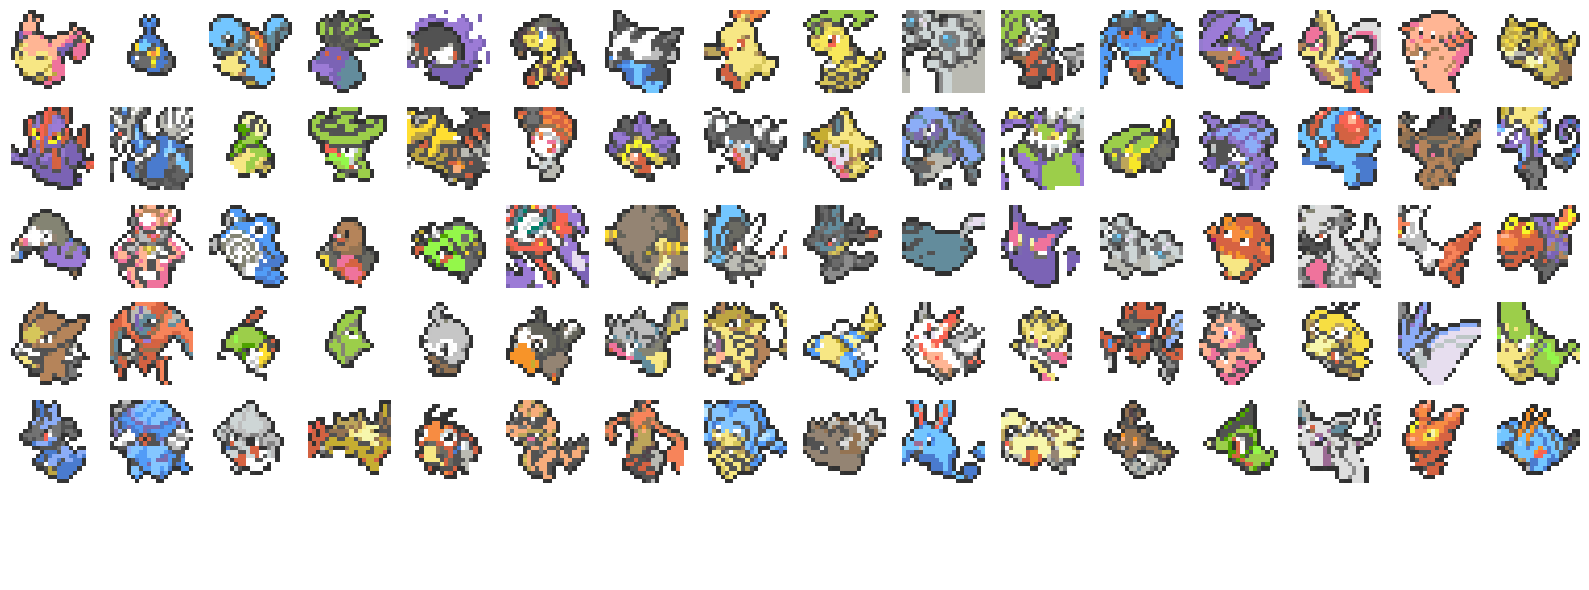

Training Epoch 82/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 82/100, Loss: 0.2624


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Epoch 82/100, Reconstruction Accuracy: 0.3846
Model saved at checkpoints/best_model.pth (Loss: 0.2624, Epoch: 82)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


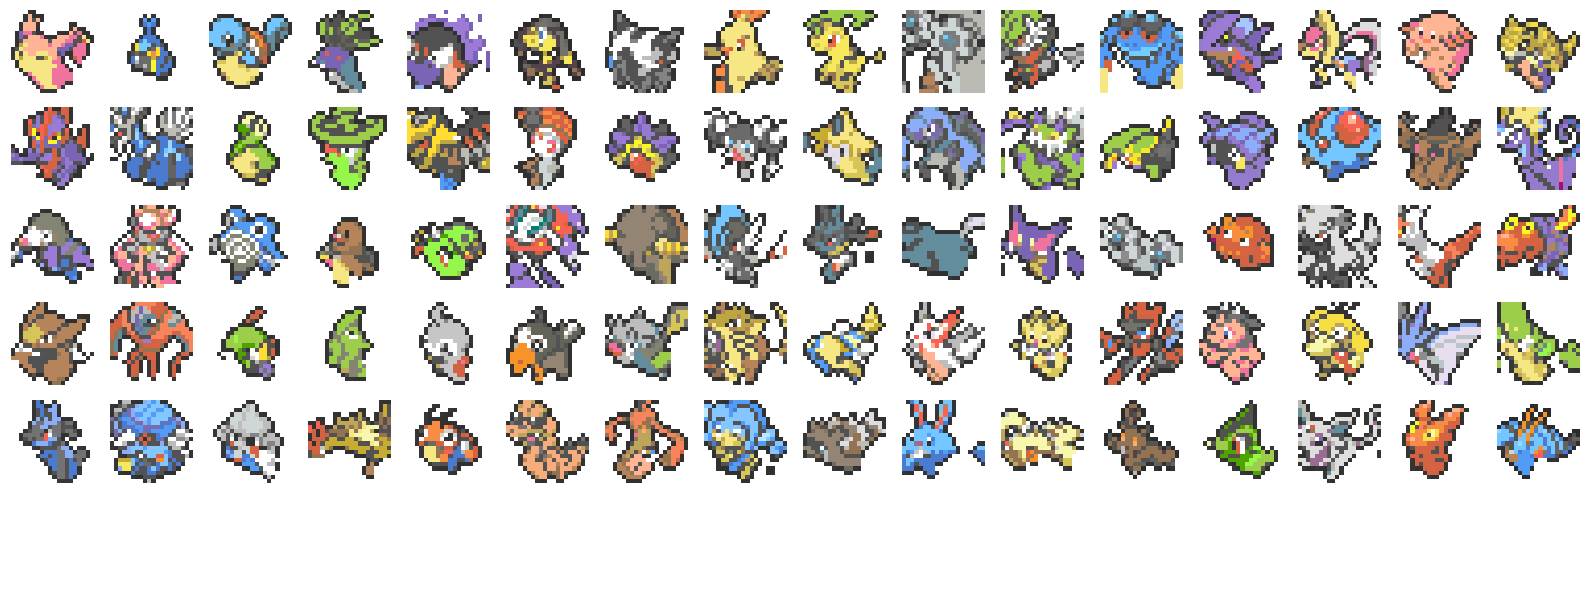

Training Epoch 83/100: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


Epoch 83/100, Loss: 0.2790


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.81s/it]


Epoch 83/100, Reconstruction Accuracy: 0.3859


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


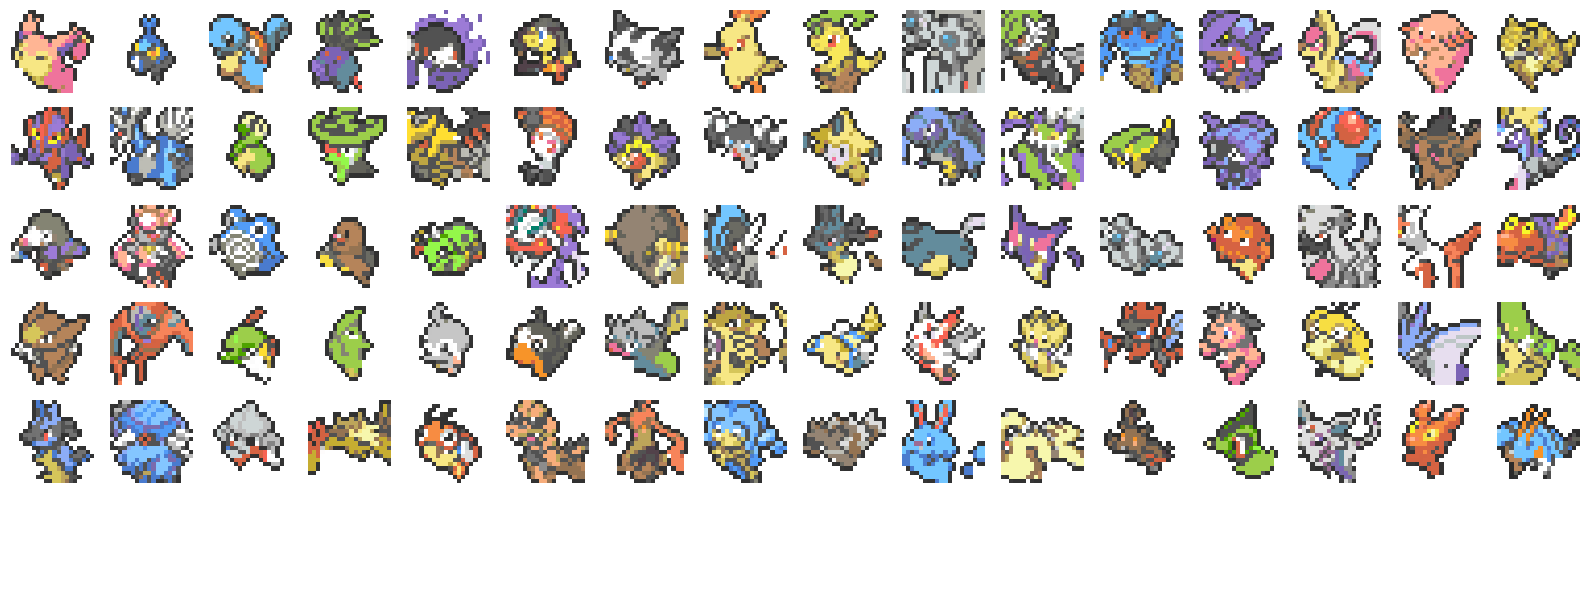

Training Epoch 84/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 84/100, Loss: 0.2665


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.80s/it]


Epoch 84/100, Reconstruction Accuracy: 0.4030


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


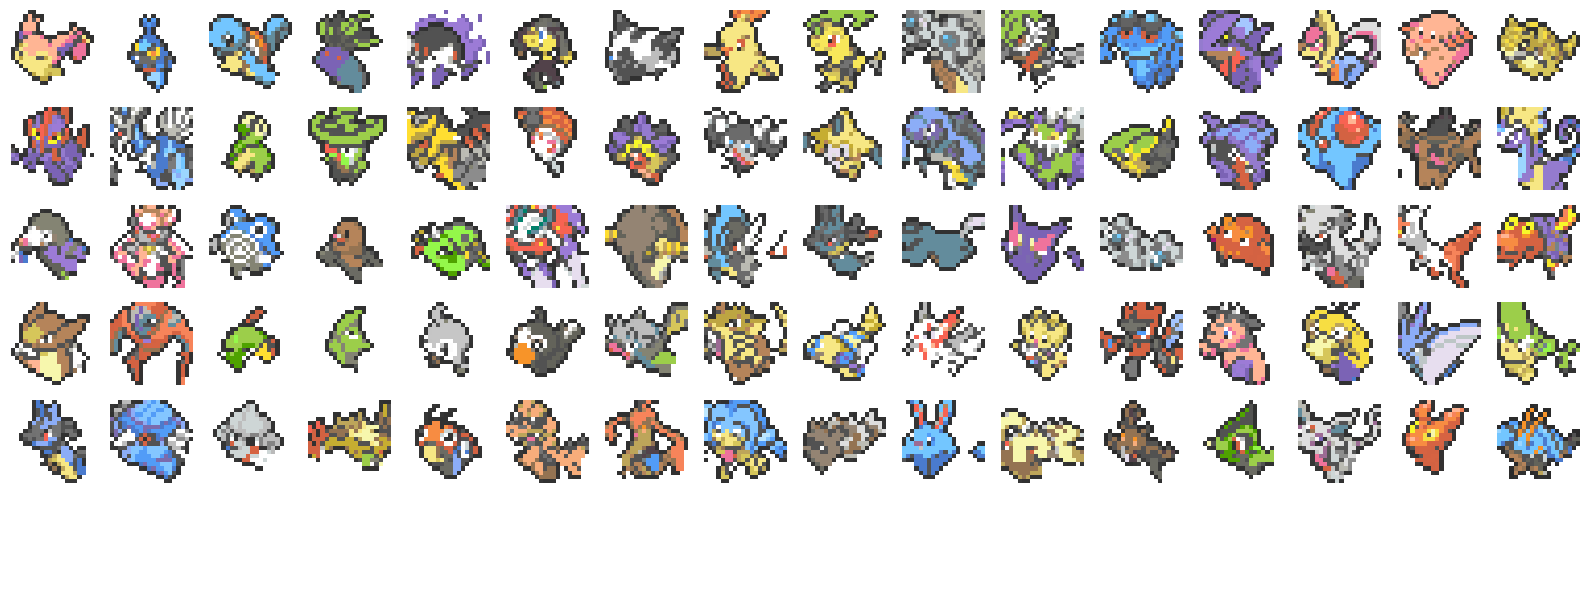

Training Epoch 85/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 85/100, Loss: 0.2689


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Epoch 85/100, Reconstruction Accuracy: 0.3900


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


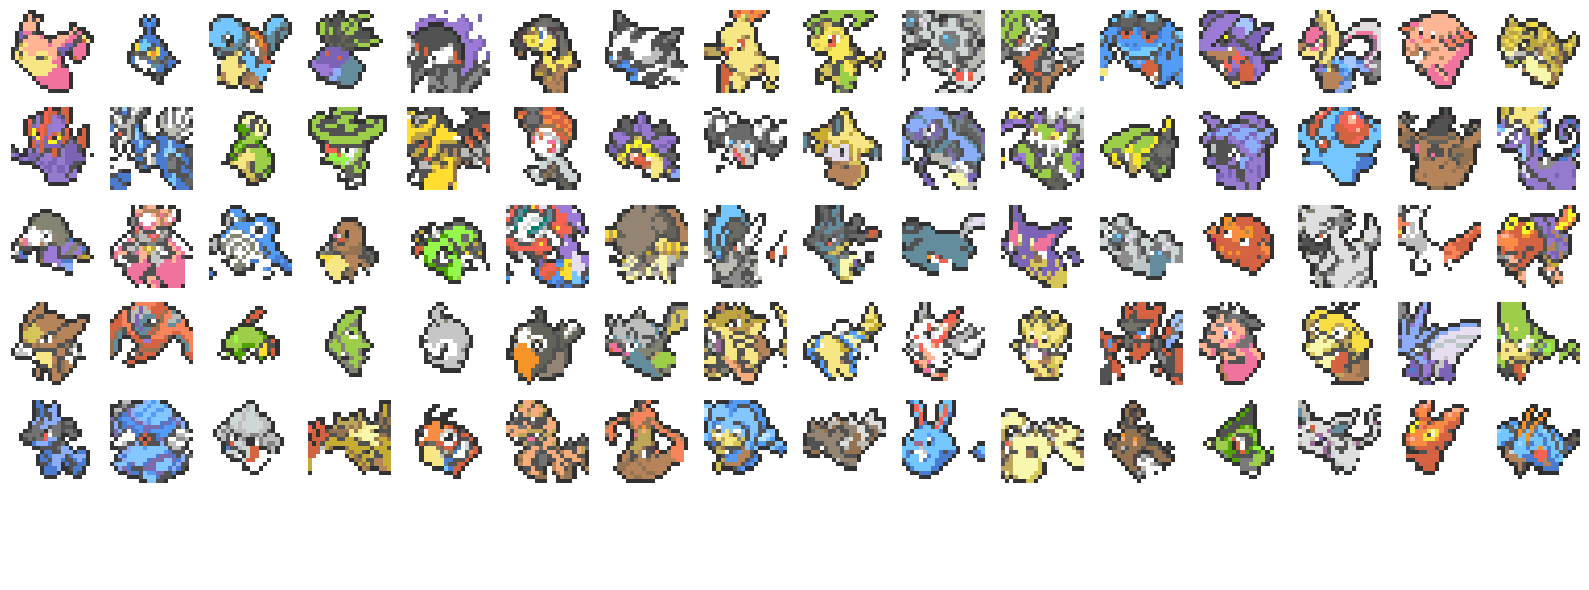

Training Epoch 86/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 86/100, Loss: 0.2662


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.80s/it]


Epoch 86/100, Reconstruction Accuracy: 0.3999


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


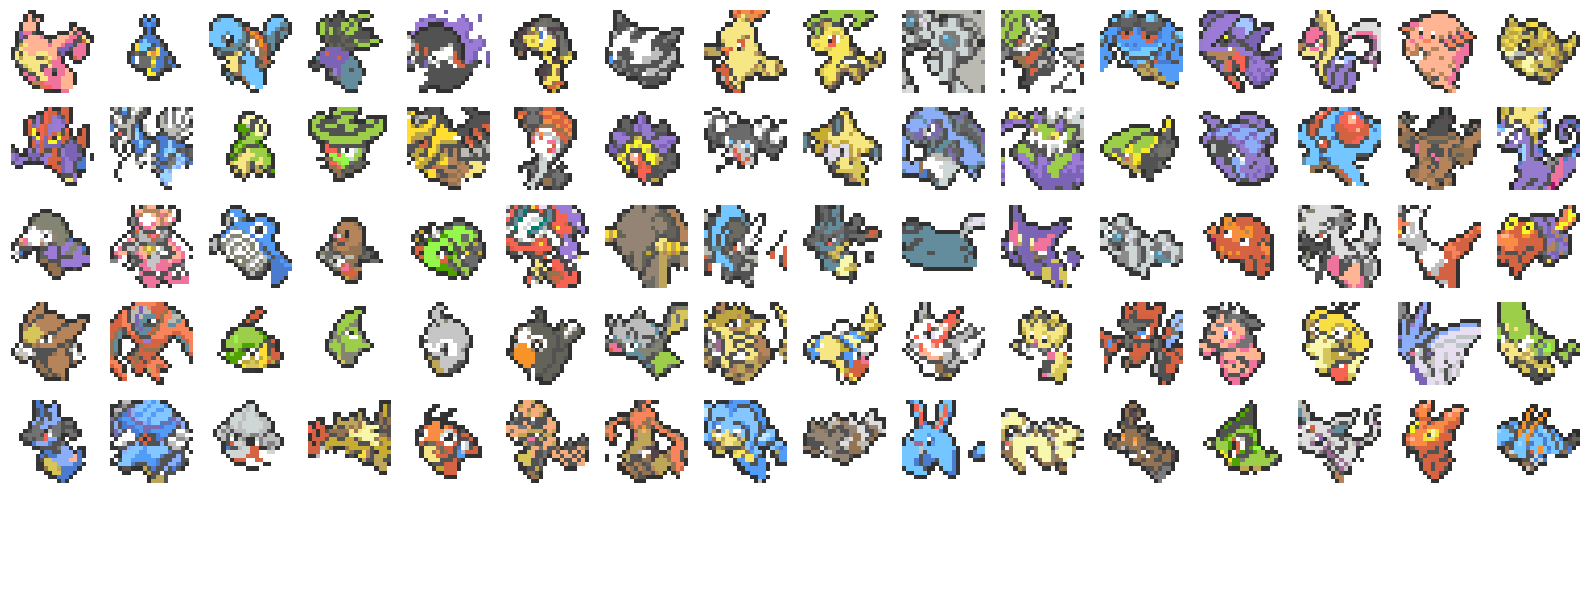

Training Epoch 87/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 87/100, Loss: 0.2691


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 87/100, Reconstruction Accuracy: 0.3855


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


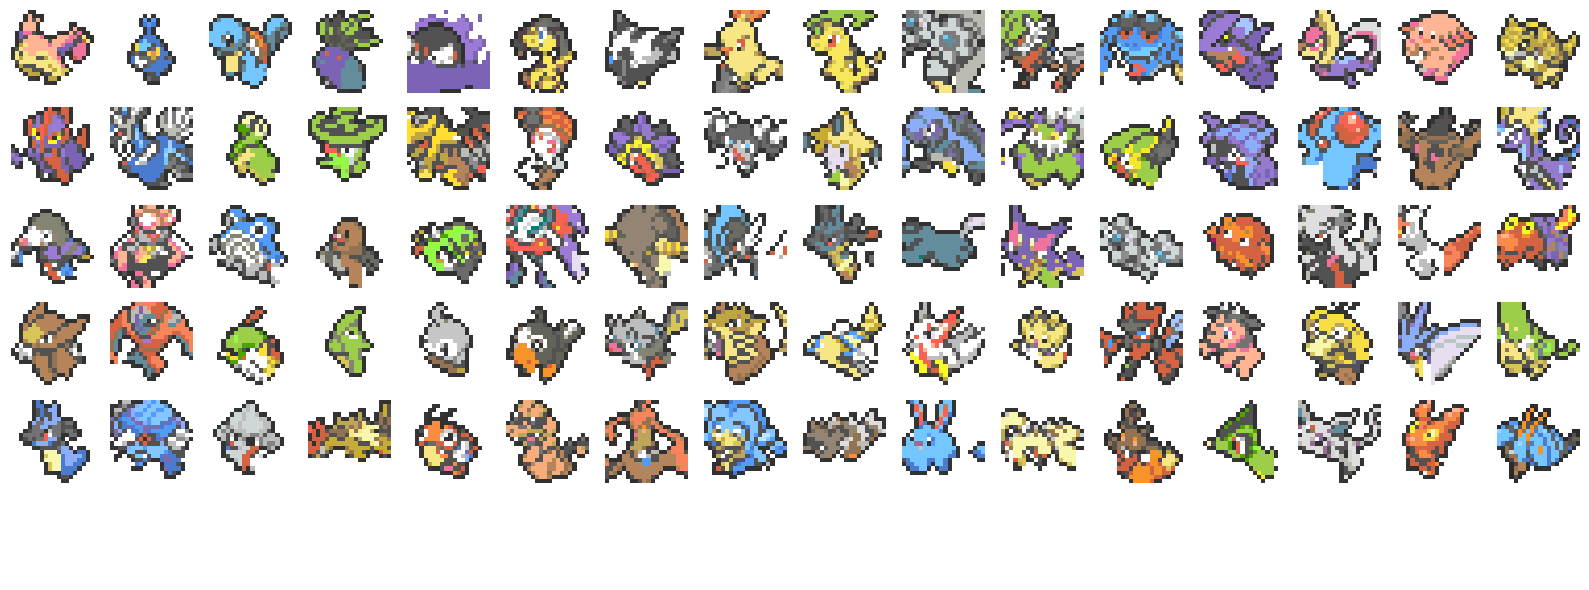

Training Epoch 88/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 88/100, Loss: 0.2693


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


Epoch 88/100, Reconstruction Accuracy: 0.3967


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


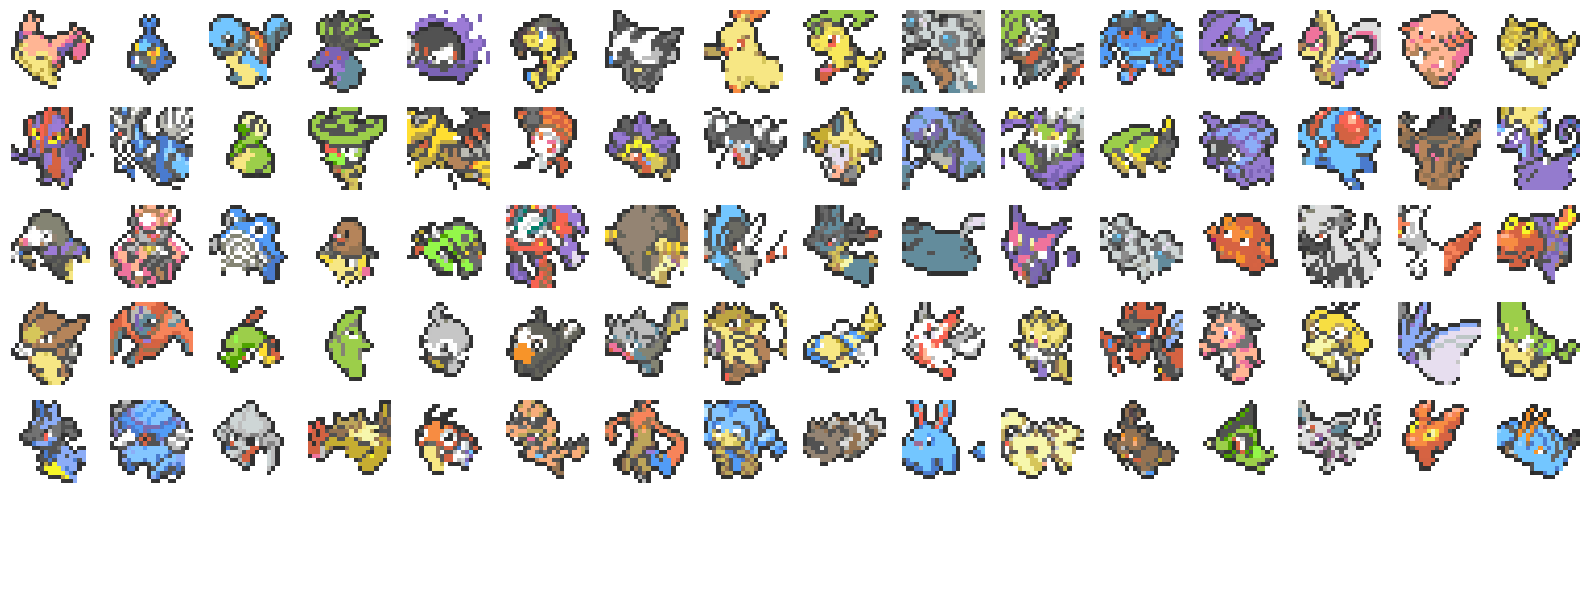

Training Epoch 89/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 89/100, Loss: 0.2660


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 89/100, Reconstruction Accuracy: 0.3872


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


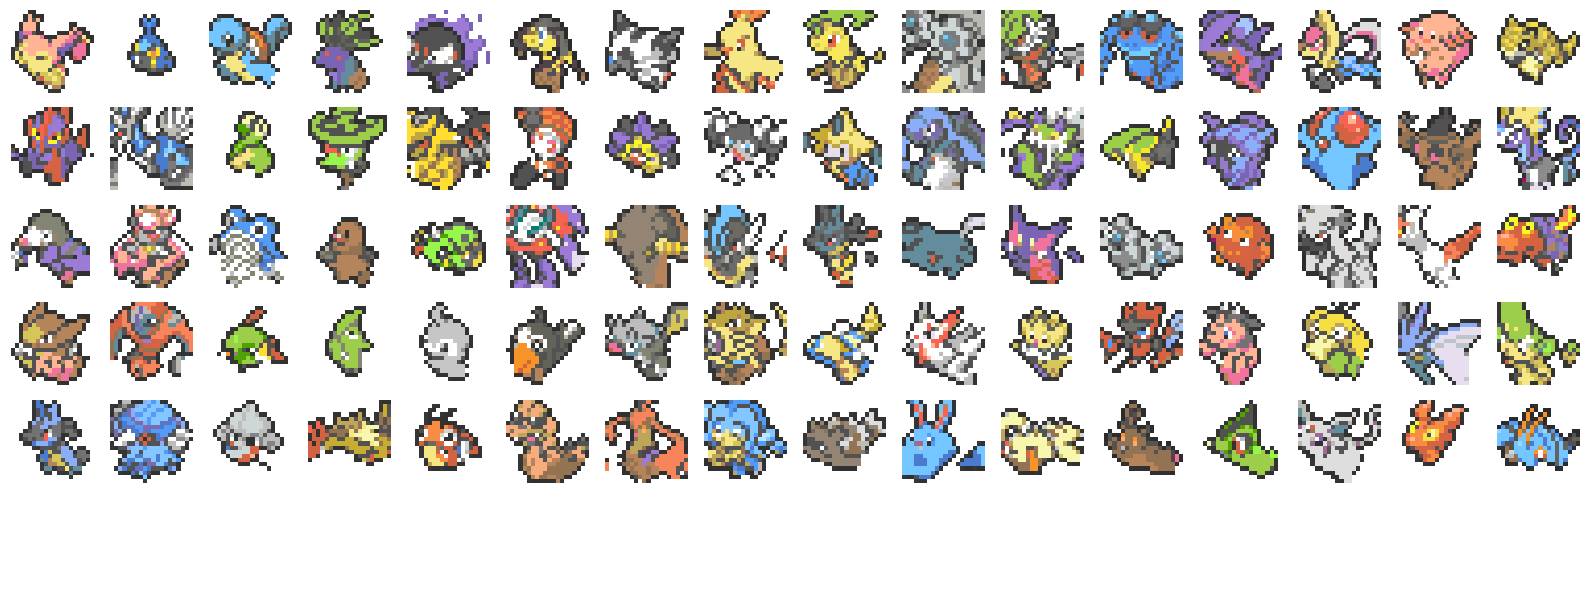

Training Epoch 90/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 90/100, Loss: 0.2583


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.80s/it]


Epoch 90/100, Reconstruction Accuracy: 0.4003
Model saved at checkpoints/best_model.pth (Loss: 0.2583, Epoch: 90)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


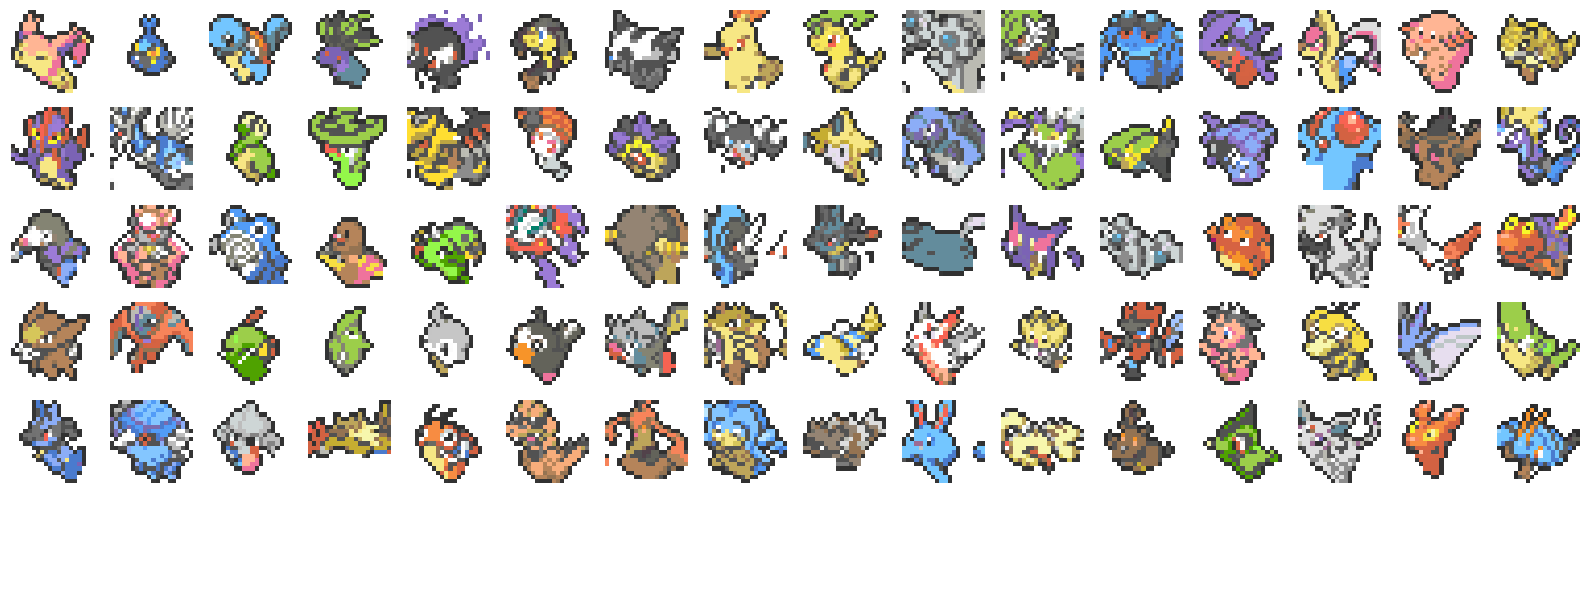

Training Epoch 91/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 91/100, Loss: 0.2467


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.80s/it]


Epoch 91/100, Reconstruction Accuracy: 0.3938
Model saved at checkpoints/best_model.pth (Loss: 0.2467, Epoch: 91)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


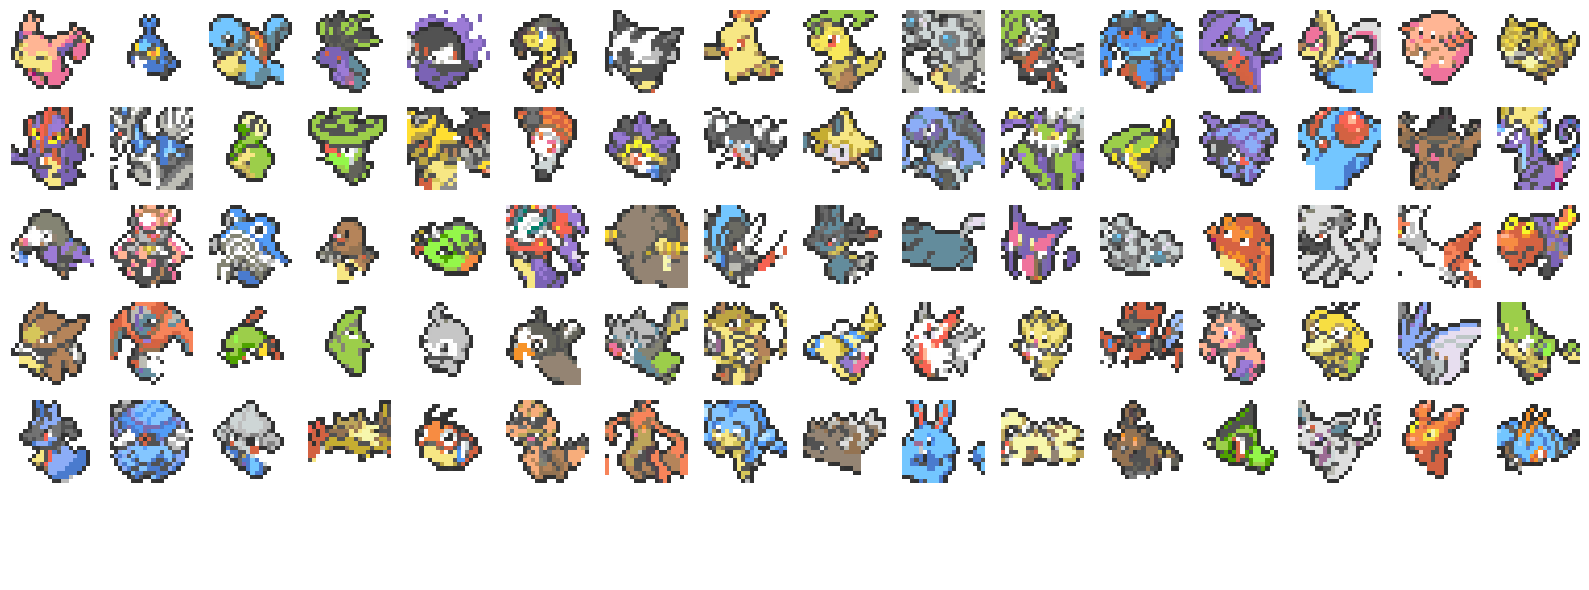

Training Epoch 92/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 92/100, Loss: 0.2541


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Epoch 92/100, Reconstruction Accuracy: 0.3972


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


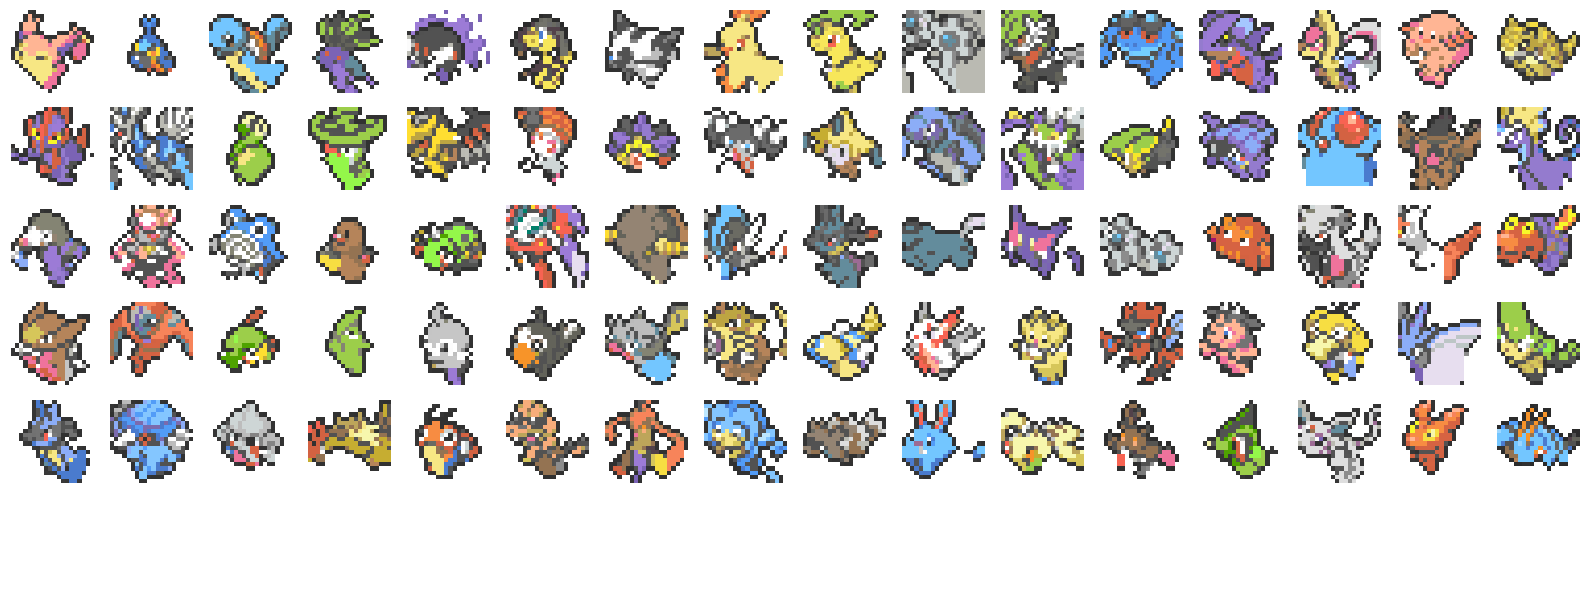

Training Epoch 93/100: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


Epoch 93/100, Loss: 0.2399


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.80s/it]


Epoch 93/100, Reconstruction Accuracy: 0.3769
Model saved at checkpoints/best_model.pth (Loss: 0.2399, Epoch: 93)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


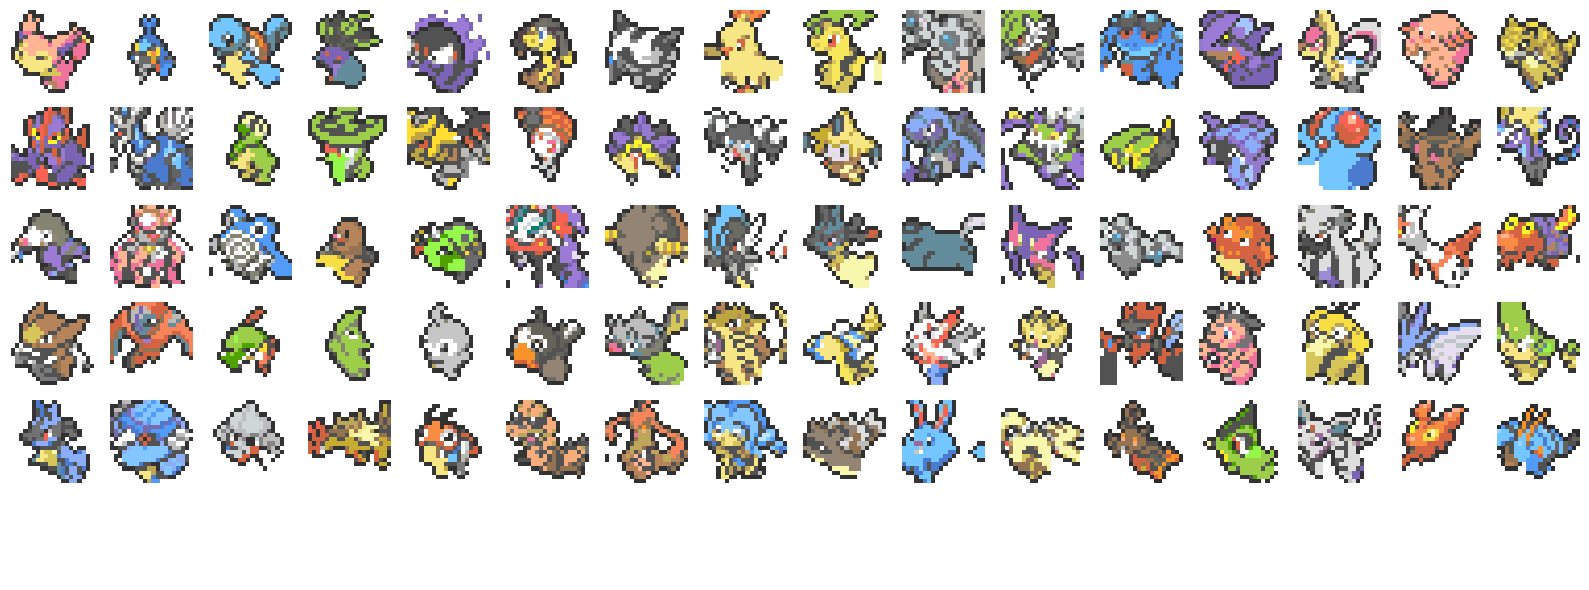

Training Epoch 94/100: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


Epoch 94/100, Loss: 0.2430


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.75s/it]


Epoch 94/100, Reconstruction Accuracy: 0.3829


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


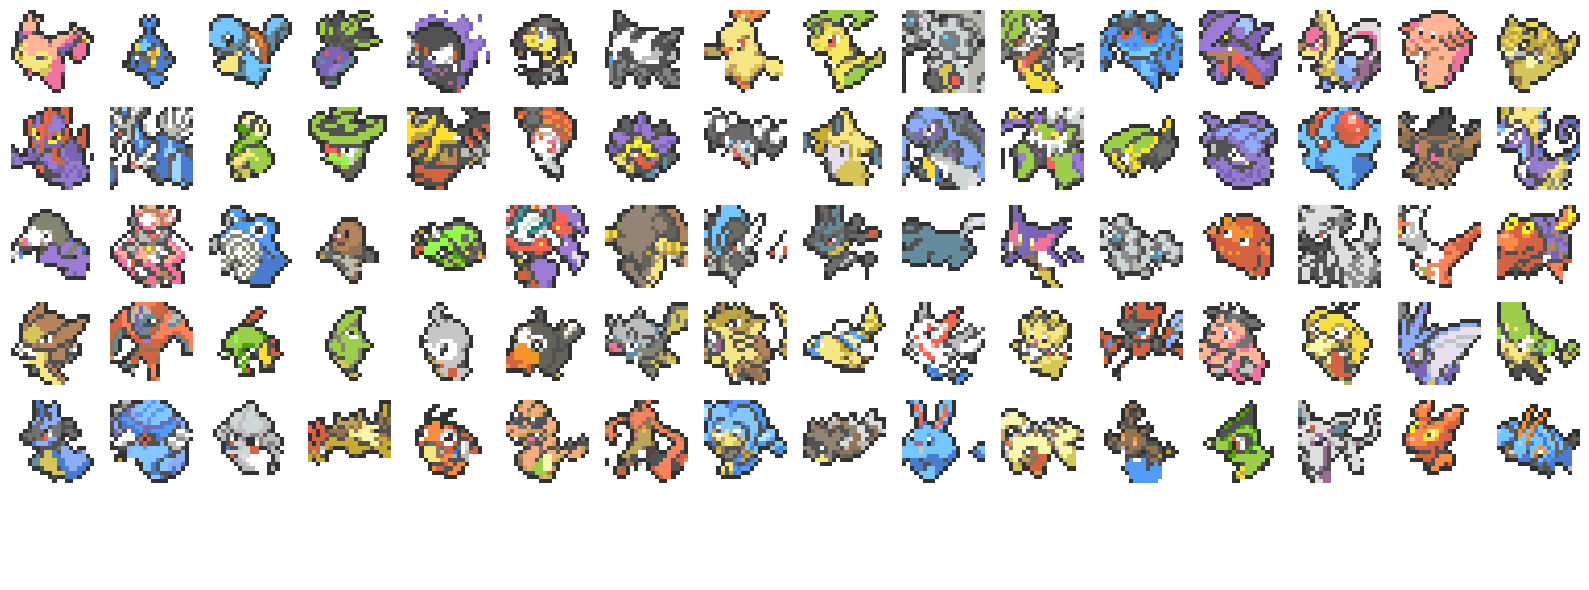

Training Epoch 95/100: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


Epoch 95/100, Loss: 0.2407


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 95/100, Reconstruction Accuracy: 0.3838


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


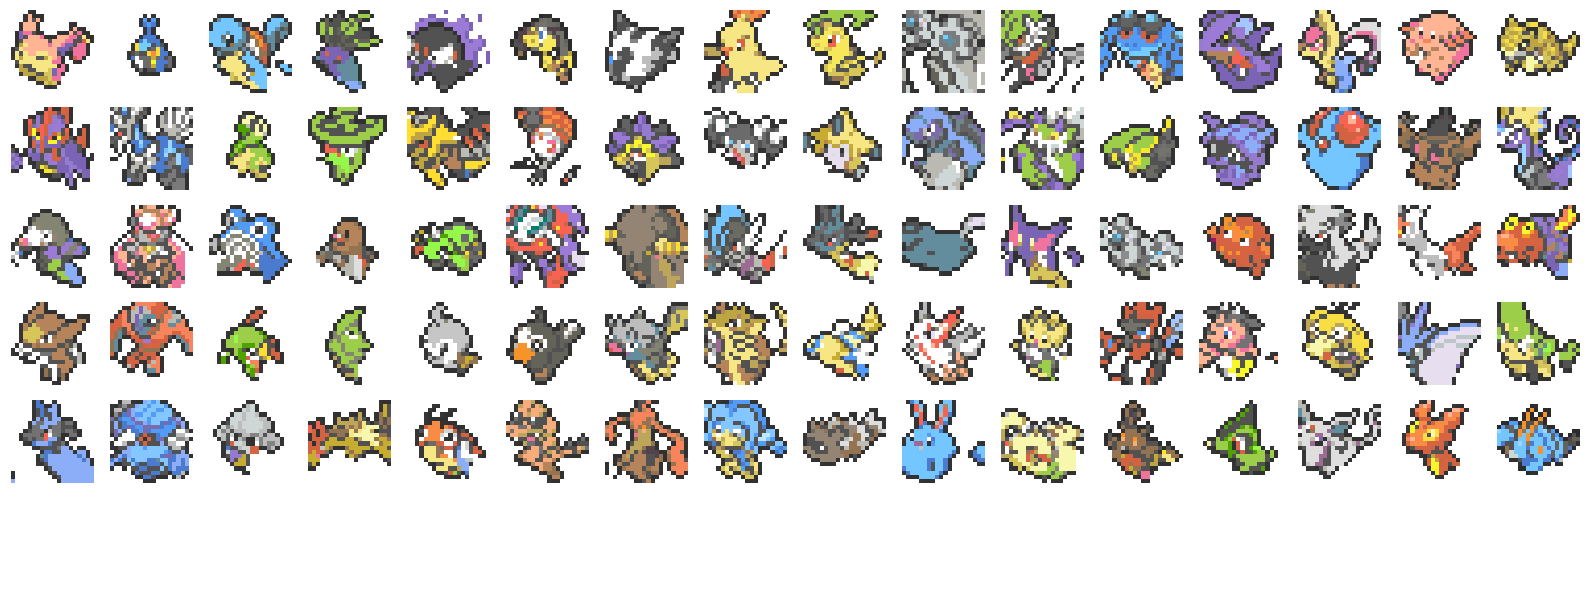

Training Epoch 96/100: 100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


Epoch 96/100, Loss: 0.2477


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.80s/it]


Epoch 96/100, Reconstruction Accuracy: 0.3789


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.80s/it]


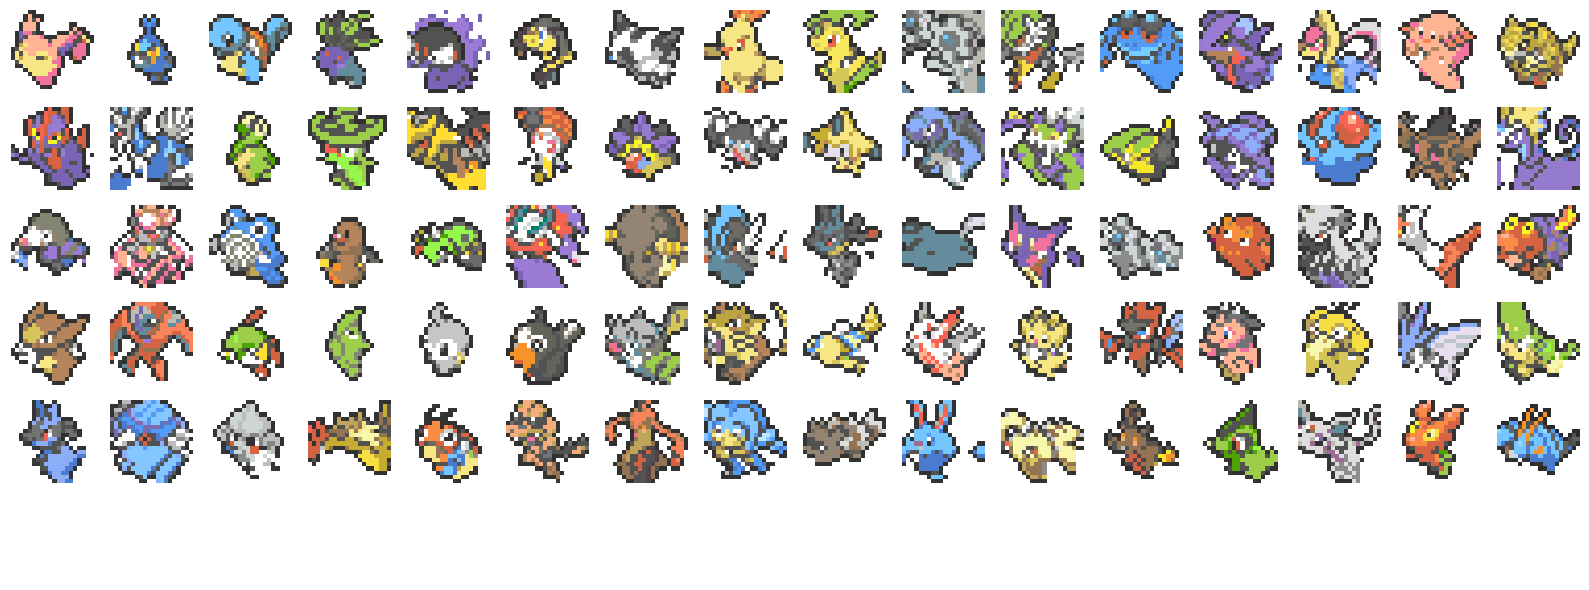

Training Epoch 97/100: 100%|██████████| 40/40 [01:41<00:00,  2.54s/it]


Epoch 97/100, Loss: 0.2439


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 97/100, Reconstruction Accuracy: 0.3891


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


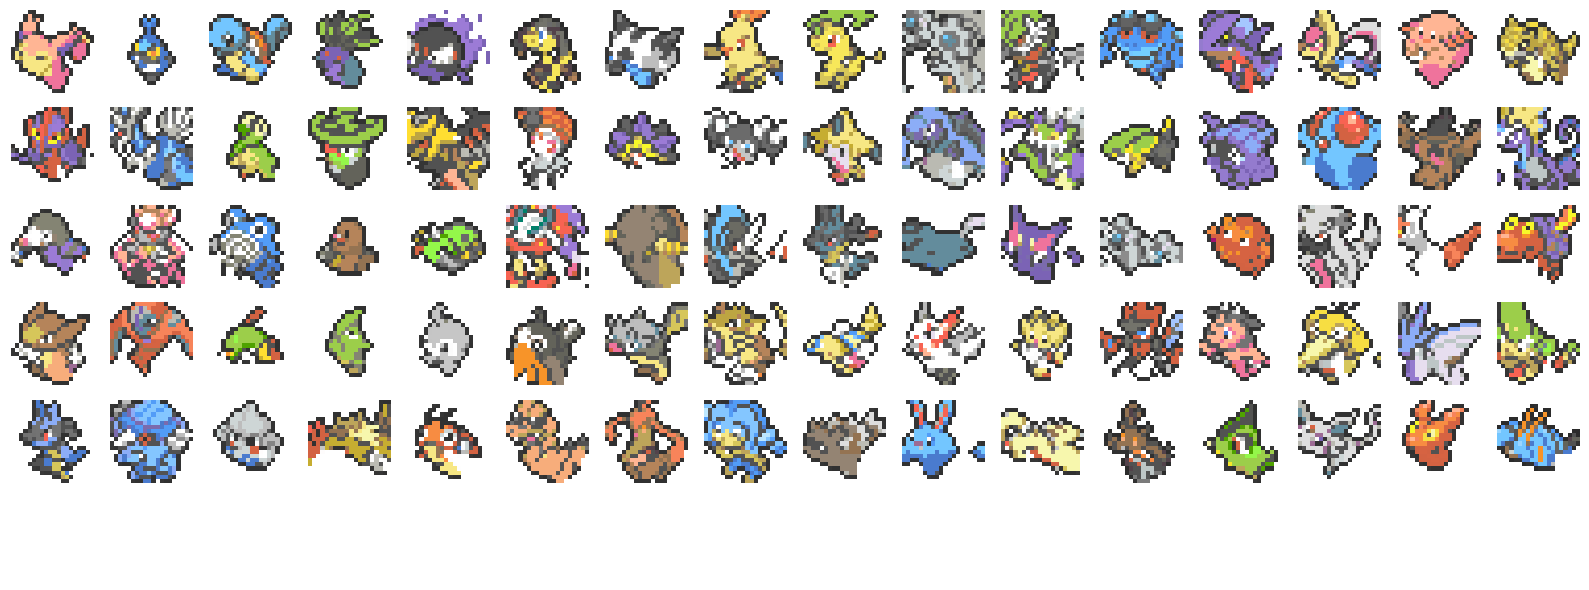

Training Epoch 98/100: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


Epoch 98/100, Loss: 0.2376


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 98/100, Reconstruction Accuracy: 0.3891
Model saved at checkpoints/best_model.pth (Loss: 0.2376, Epoch: 98)


Generating Outputs: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


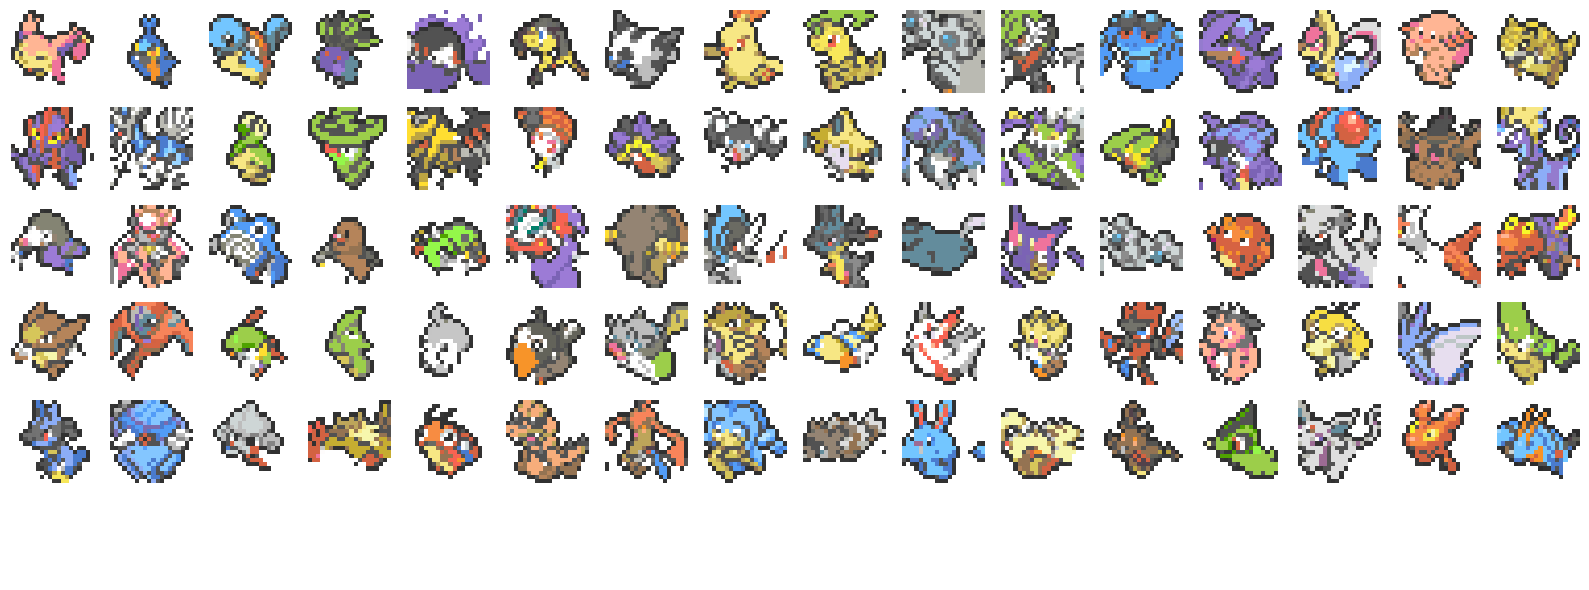

Training Epoch 99/100: 100%|██████████| 40/40 [01:44<00:00,  2.61s/it]


Epoch 99/100, Loss: 0.2479


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.87s/it]


Epoch 99/100, Reconstruction Accuracy: 0.3916


Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.93s/it]


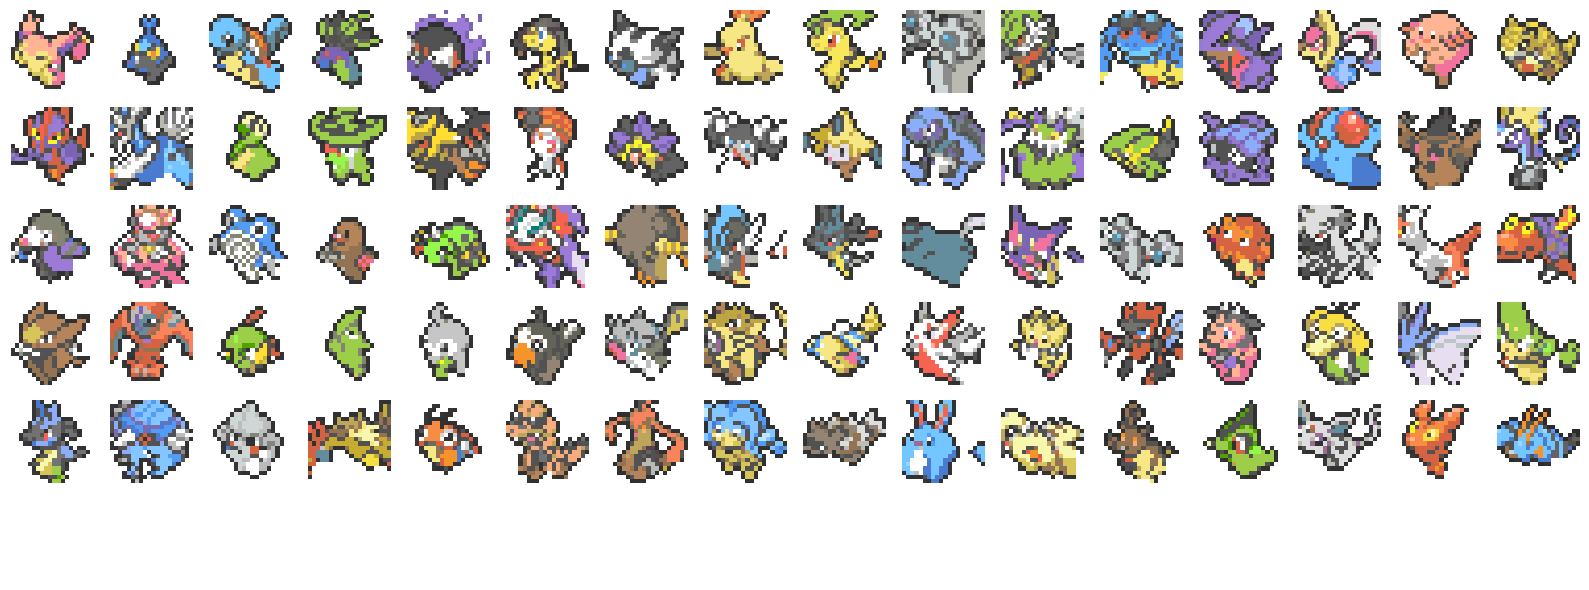

Training Epoch 100/100: 100%|██████████| 40/40 [01:45<00:00,  2.63s/it]


Epoch 100/100, Loss: 0.2431


Evaluating: 100%|██████████| 5/5 [00:29<00:00,  5.88s/it]


Epoch 100/100, Reconstruction Accuracy: 0.3855


Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.89s/it]


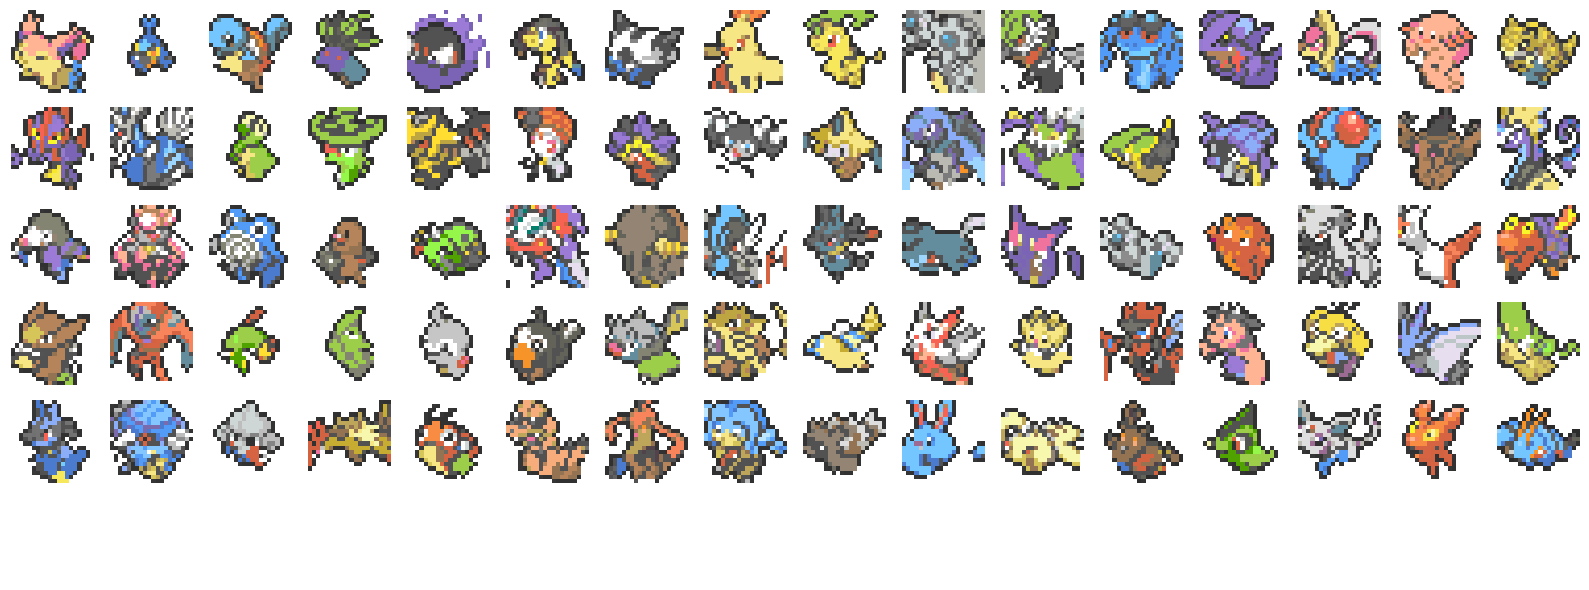

In [19]:
# Create save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
# Initialize best loss as positive infinity for comparison during model checkpointing
best_loss: float = float('inf')
# Move model to the appropriate device (GPU or CPU)
model.to(device)

# Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize the epoch loss

    # Iterate over training data batches
    for input_ids, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids, labels = input_ids.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass through the model to get logits (output probabilities)
        outputs = model(input_ids=input_ids).logits.view(-1, config.vocab_size)
        labels = labels.view(-1)  # Flatten labels to match logits shape

        # Calculate loss using CrossEntropyLoss
        loss = criterion(outputs, labels)

        # Backpropagation and optimizer step
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()     # Compute gradients
        optimizer.step()     # Update model weights

        # Accumulate the loss for the epoch
        epoch_loss += loss.item()

    # Compute average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

    # Evaluation Loop (Validation)
    model.eval()      # Set the model to evaluation mode (disables dropout, etc.)
    total_accuracy = 0  # Initialize total accuracy
    num_batches = 0   # Initialize batch counter

    with torch.no_grad():  # Disable gradient calculation for validation
        # Iterate over validation data batches
        for inputs, labels in tqdm(dev_dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move validation data to device
            attention_mask = torch.ones_like(inputs)          # Attention mask to ensure valid token positions

            # Perform batch inference using the model
            generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

            # Extract the last 160 tokens from generated outputs and labels
            generated_outputs = generated_outputs[:, -160:]

            # Calculate accuracy for the batch
            accuracy = (generated_outputs == labels).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1

    # Compute average reconstruction accuracy for the epoch
    avg_accuracy = total_accuracy / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Accuracy: {avg_accuracy:.4f}")

    # If the current epoch loss is better (lower) than the best loss, save the model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss                   # Update best loss
        save_model(model, optimizer, epoch, best_loss, save_dir)  # Save the model with the best loss

    # show test image
    # Testing Loop with Batch Inference
    results: list = []  # List to store the generated sequences from the model
    
    with torch.no_grad():  # Disable gradient calculations for inference
        # Iterate over test data in batches
        for inputs in tqdm(test_dataloader, desc="Generating Outputs"):
            inputs = inputs.to(device)         # Move model to the appropriate device (GPU or CPU)
            attention_mask = torch.ones_like(inputs)  # Attention mask (ensure valid token positions)
    
            # Generate predictions for the entire batch
            generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)
    
            # Convert batch outputs to a list and append to results
            batch_results = generated_outputs.cpu().numpy().tolist()
            results.extend(batch_results)  # Extend the results list with batch results
    predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
    show_images(predicted_images)

### Inference

In [20]:
# Load the best model from the saved checkpoint
best_model_path = os.path.join(save_dir, "best_model.pth")              # Path to the best model checkpoint
checkpoint = torch.load(best_model_path, weights_only=True, map_location=device)  # Load checkpoint from the file
model.load_state_dict(checkpoint["model_state_dict"])                  # Load the model weights from checkpoint
model.eval()                                        # Set the model to evaluation mode (disables dropout, etc.)

# Testing Loop with Batch Inference
results: list = []  # List to store the generated sequences from the model

with torch.no_grad():  # Disable gradient calculations for inference
    # Iterate over test data in batches
    for inputs in tqdm(test_dataloader, desc="Generating Outputs"):
        inputs = inputs.to(device)         # Move model to the appropriate device (GPU or CPU)
        attention_mask = torch.ones_like(inputs)  # Attention mask (ensure valid token positions)

        # Generate predictions for the entire batch
        generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

        # Convert batch outputs to a list and append to results
        batch_results = generated_outputs.cpu().numpy().tolist()
        results.extend(batch_results)  # Extend the results list with batch results

# Save the results to a file
output_file: str = "reconstructed_results.txt"  # File to save the output sequences
with open(output_file, "w") as f:
    # Write each sequence to the file
    for seq in results:
        f.write(" ".join(map(str, seq)) + "\n")

print(f"Reconstructed results saved to {output_file}")  # Confirmation message

Generating Outputs: 100%|██████████| 5/5 [00:29<00:00,  5.93s/it]

Reconstructed results saved to reconstructed_results.txt


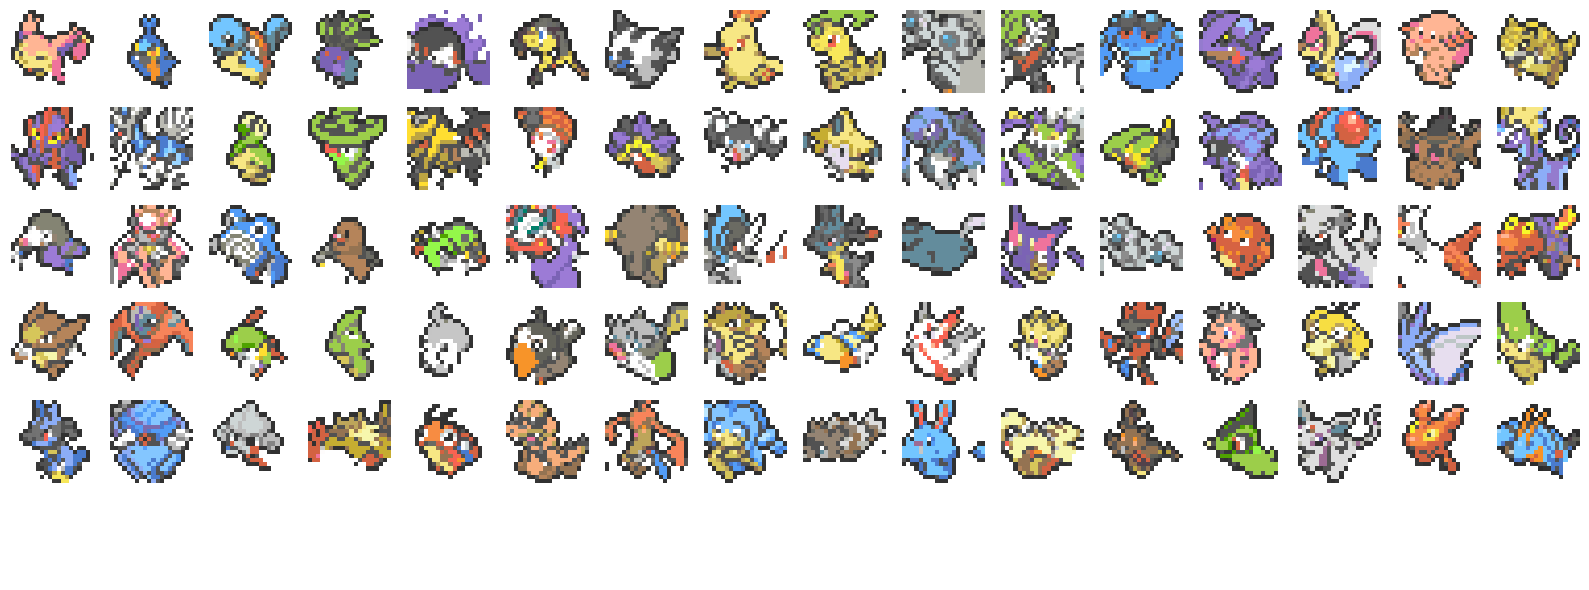

In [21]:
# Visualize generated test images
predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
show_images(predicted_images)